# Importation librairies

In [1]:
# things we need for NLP
import nltk
#from nltk.stem.lancaster import LancasterStemmer
#stemmer = LancasterStemmer()
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

In [2]:
# things we need for Tensorflow
import numpy as np
import keras
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pandas as pd
from nltk import word_tokenize

# Nettoyage texte (stopwords, stemming) et vectorisation

## Code stemming, stop words et vectorisation

In [81]:
# import our chat-bot intents file
import json

def import_corpus(jsonfile): #permet d'importer le corpus
    try:
        with open(jsonfile, encoding='utf-8') as json_data:
            intents = json.load(json_data)
        return intents

    except OSError as err:
        print("OS error: {0}".format(err))
    except ValueError:
        print("Your .json is wrong, look at https://jsonlint.com/")
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise
        
corpus = import_corpus('intents.json')
corpus

{'intents': [{'tag': 'bienvenue',
   'patterns': ['Salut',
    'Salut à tous',
    'Bonjour à tous',
    'Bonjour',
    'Coucou',
    'Comment ca-va?',
    'Comment tu vas?',
    "je recherche de l'aide",
    'oyez oyez',
    'hey'],
   'responses': ['Bonjour, comment puis-je vous aider?'],
   'context': ['']},
  {'tag': 'raison_isen',
   'patterns': ['Pourquoi l’isen ?',
    'description isen',
    "école d'ingénieur généraliste",
    'C’est quoi la différence avec les autres écoles d’ingénieurs ?',
    'Quelle est la différence avec les autres écoles d’ingénieurs ?',
    'différence autres écoles ingénieurs',
    "en quoi l'isen est meilleur?",
    "Pourquoi choisir l'isen?",
    "quelles sont les avantages offert par l'isen?",
    "qu'offre l'isen en termes d'enseignement?",
    "quelles performances peut-on retrouvés à l'isen"],
   'responses': ['La maîtrise de ces compétences est au cœur de la formation ISEN. Elle permet une approche métier transdisciplinaire dans des domaines d’a

In [82]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

def extraction_data_X_y(jsonfile): #permet d'obtenir les patterns (X_text) et les tags (y_text)
    corpus = import_corpus(jsonfile)
    
    X_texte = []
    y_texte = []
    
    ponctuation = [".", "?", "!", ",", ";", ":", "(",  ")", "[", "]", "«", "»", '"', "/", "}", "{", "'", "#","-","’"]
    try :
        for doc in corpus['intents']: #'intents
            #print(doc['tag']) #obtenir chaque tag
            for p in doc['patterns']: #'patterns'
                #print(p) #obtenir chaque phrase/patterns par tags 
                
                for element in ponctuation:
                    p = p.replace(element," ")
                
                #filtered_phrase = clean_text(p)
                filtered_phrase = p
                
                
                
                
                #X_texte.append(" ".join(filtered_phrase)) Bonne version avec stemming
                X_texte.append(filtered_phrase)
                
                y_texte.append(doc['tag']) 
                #y_texte.append(doc['tag']) #on rajoute un 2e même tag car on double le dataset
                
        X_train, X_test, y_train, y_test = train_test_split(X_texte,y_texte,train_size=0.8)
        return X_texte, y_texte, X_train, X_test, y_train, y_test
    except:
        print("l'extraction des patterns et tags n'a pas fonctionnée, allez voir la fonction extraction data_X_y")
X_text = []
y_text = []
X_texte, y_texte, X_train, X_test, y_train, y_test = extraction_data_X_y('intents.json')
print(X_texte)
print("\n\n")
print(y_texte)

['Salut', 'Salut à tous', 'Bonjour à tous', 'Bonjour', 'Coucou', 'Comment ca va ', 'Comment tu vas ', 'je recherche de l aide', 'oyez oyez', 'hey', 'Pourquoi l isen  ', 'description isen', 'école d ingénieur généraliste', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'différence autres écoles ingénieurs', 'en quoi l isen est meilleur ', 'Pourquoi choisir l isen ', 'quelles sont les avantages offert par l isen ', 'qu offre l isen en termes d enseignement ', 'quelles performances peut on retrouvés à l isen', 'C est quoi l ISEN  ', 'cursus isen', 'années scolarité', 'En combien d années se déroule l ISEN  ', 'Qu est ce que l ISEN', 'C est quoi le cursus de l école', 'Combien d années d études post bac ', 'temps post bac', 'peut on intégrer l école après le bac', 'comment foncionne l ISEN', 'comment est on formé à l isen ', 'quelles sont les différentes possibilités suivant mon profil ', 'quels sont les e

In [114]:
from sklearn.preprocessing import LabelBinarizer,LabelEncoder

enc1=LabelEncoder()
enc1.fit(y_texte) #enc1.fit(X_train) --> supprimer les mots inconnues de la base de test --> enc1.transform(X_train) & enc1.transform(X_test)
dicoLabel=enc1.transform(y_texte)
tdico=zip(np.unique(dicoLabel),np.unique(y_texte))
dic_dico={i:j for i,j in tdico} #pour associer les n° de tag à leur nom --> {0: 'Bourses', 1: 'Clubs_etudiants', 2: 'Handicap', 3: 'ISEN_logement' ...}
#print(dic_dico)
#print(list(t))
enc=LabelBinarizer()
enc.fit(y_texte)
y_transf= enc.transform(y_texte)
#dic_dico[np.argwhere(y_transf[0]==1)]

{0: 'Bourses', 1: 'Clubs_etudiants', 2: 'Handicap', 3: 'ISEN_logement', 4: 'ISEN_restauration', 5: 'Job_ISEN', 6: 'La vie à Brest', 7: 'Nombre_etudiants_alumni_etudiants', 8: 'SHN', 9: 'Taux_insertion', 10: 'Yncrea', 11: 'bienvenue', 12: 'campus_ouest', 13: 'certifications', 14: 'cursus_isen', 15: 'raison_isen', 16: 'tarif_BIAST', 17: 'tarif_BIOST', 18: 'tarif_CENT', 19: 'tarif_CGSI', 20: 'tarif_CIR', 21: 'tarif_EST', 22: 'tarif_cycle_ingenieur', 23: 'visite_virtuelle_PO'}
[]


'bienvenue'

In [45]:
ponctuation = [".", "?", "!", ",", ";", ":", "(",  ")", "[", "]", "«", "»", '"', "/", "}", "{", "'", "#","-","’"]
phrase = "Pourquoi ' l'isen a-t-il ?"
#phrase = "Pourquoi l'isen a-t-il ?"
for element in ponctuation:
    phrase = phrase.replace(element," ")
phrase

'Pourquoi   l isen a t il  '

In [62]:
X_texte

['Salut',
 'Salut à tous',
 'à tous',
 'Bonjour',
 'Coucou',
 'Comment ca va ',
 'je recherche de l aide',
 'oyez oyez',
 'hey',
 'Pourquoi l isen  ',
 'C est quoi la différence avec les autres écoles d ingénieurs  ',
 'Quelle est la différence avec les autres écoles d ingénieurs  ',
 'différence autres écoles ingénieurs',
 'en quoi l isen est meilleur ',
 'Pourquoi choisir l isen ',
 'quelles sont les avantages offert par l isen ',
 'qu offre l isen en termes d enseignement ',
 'quelles performances peut on retrouvés à l isen',
 'C est quoi l ISEN  ',
 'En combien d années se déroule l ISEN  ',
 'Qu est ce que l ISEN',
 'C est quoi le cursus de l école',
 'Combien d années d études post bac ',
 'peut on intégrer l école après le bac',
 'comment foncionne l ISEN',
 'comment est on formé à l isen ',
 'quelles sont les différentes possibilités suivant mon profil ',
 'quelles sont les enseignements à l isen ',
 'C est quoi Yncréa Ouest  ',
 'Combien y a t il d écoles dans l ouest ',
 'Que

In [5]:
from nltk.corpus import wordnet
from collections import OrderedDict
from deep_translator import GoogleTranslator

In [6]:
def find_synonyms(word):
    translated_word = GoogleTranslator(source='fr', target='en').translate(word)
    
    synonyms = []
    for synset in wordnet.synsets(translated_word):
        for syn in synset.lemma_names():
            synonyms.append(GoogleTranslator(source='en', target='fr').translate(syn))
            #print(syn,"sa traduction en français",GoogleTranslator(source='en', target='fr').translate(syn))
            
    # using this to drop duplicates while maintaining word order (closest synonyms comes first)
    synonyms_without_duplicates = list(OrderedDict.fromkeys(synonyms))
    return list(OrderedDict.fromkeys(synonyms)) #synonyms #synonyms_without_duplicates
find_synonyms("hey")

[]

In [7]:
from nltk import word_tokenize
def create_set_of_new_sentences(sentence, max_syn_per_word = 6, nbr_new_sentences = 1): #nbr_new_sentences est le nombre de "nouvelle" phrase crée par phrase, si =1 on va doubler le dataset par exemple
    try:
        new_sentences = []
        for word in nltk.word_tokenize(sentence):
            #print("\n")
            if len(word)<=3 : continue #les petits mots ont souvent des erreurs en synonymes
            for synonym in find_synonyms(word)[0:max_syn_per_word]:
                
                #print(synonym, word)
                synonym = synonym.replace('_', ' ') #restore space character
                new_sentence = sentence.replace(word,synonym)
                new_sentences.append(new_sentence)
        return new_sentences[1:nbr_new_sentences+1] #le premier correspond à la phrase initiale
    except:
        print("Peut être que votre phrase n'est pas dans la bonne langue (Français) ou que vous n'avez rien mis en entrée de la fonction")

In [8]:
def data_augmentation_syn(X_train,y_train, nbr_new_sentences = 1): #need X_train et y_train au format texte
    print(f"\nX_train {X_train} de taille {len(X_train)}")
    print(f"\ny_train {y_train} de taille {len(y_train)}")
    
    
    X_train_complete=[] #pour stocker les phrases complètes
    
    X_train_augmented = [] #[[0] for i in range(len(X_train)*(1+nbr_new_sentences))] #pour créer une liste de bonne taille
    y_train_augmented= [] #X_train_augmented #y_train_augmented sera de même taille que X_train_augmented
        
    #Pour avoir les phrases complètes (et pas des listes de mots pour une phrase) (ex: on veut [phrase1,phrase2,phrase3] et X_train est au départ sous format [[mot1_phrase1,mot2_phase1],[mot1_phrase2...
    for phrase in X_train :
        X_train_complete.append(phrase) 
    #print(f"X_train_complete {X_train_complete} et taille : {len(X_train_complete)}")
    
    
    i=0
    for phrase_initiale in X_train:
        print(f"\nphrase initiale : {phrase_initiale}")
        X_train_augmented.append(phrase_initiale)
        y_train_augmented.append(y_train[i])
        new_phrases=create_set_of_new_sentences(phrase_initiale, None, nbr_new_sentences)
        print(new_phrases)
        
        try :
            for new_phrase in new_phrases:
                print(f"NOUVELLE phrase : {new_phrase}")
                X_train_augmented.append(new_phrase)
                y_train_augmented.append(y_train[i])
            i+=1
        except : 
            print(f"{phrase_initiale} n'a pas pu avoir de phrases synonymes")
            
    print(f"\nX_train_augmented {X_train_augmented} de taille {len(X_train_augmented)}")
    print(f"\ny_train_augmented {y_train_augmented} de taille {len(y_train_augmented)}")
    return (X_train_augmented, y_train_augmented)
    
        
    

In [29]:
X_train_augmented,y_train_augmented = data_augmentation_syn(X_text[10:12],y_text[10:12],nbr_new_sentences=2)


X_train ['C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la différence avec les autres écoles d’ingénieurs ?'] de taille 2

y_train ['raison_isen', 'raison_isen'] de taille 2
ici
['C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?']
là
là
ici
['Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?']
là
là

X_train_augmented ['C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?', 'Quelle est la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?'] de taille 6

y_train_augmented ['raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'rai

In [9]:
from nltk.corpus import stopwords

from nltk.stem.snowball import FrenchStemmer
import string


def clean_text(phrase, test = False, list_word_train = []): #fait du french stemming et du stop words sur une phrase
    """
    test = True indique que la phrase fait parti du dataset de test --> donc on rajoute aux stop_words TOUS les mots du dataset train
    """
    #print(f"----------------------Début clean_text ------------------")
    try:
        
        
        stemmer = FrenchStemmer()
        
        alphabet = list(string.ascii_lowercase)
        une_lettre = ["é", "â", "ê", "î", "ô", "û", "è", "ç", "ä", "ë", "ï", "ö", "ü", "ÿ"]
        for lettre in une_lettre:
            alphabet.append(lettre)
            
        stop_words=stopwords.words("French")
        for element in alphabet:
            stop_words.append(element)
        
        
        
        filtered_sentence=[]

        #enlever les stop words
        for mot in nltk.word_tokenize((phrase.lower())):
                    
                    #print(mot)
                    if mot not in stop_words:
                        filtered_sentence.append(mot)
        #print(filtered_sentence)

        #stemming en français
        if test == False:
     #       print("dans cas données train")

            stemmed = [stemmer.stem(i) for i in filtered_sentence] #stemmer.stem(i) bonne version avec stemming 
        else: #si on a une phrase du dataset de test, on enleve les mots qui n'ont pas été rencontrés à l'entrainement
      #      print("dans cas données test\n")

            stemmed = []
            for i in filtered_sentence:
       #         print("i:",i)
        #        print(f"list_word_train : {list_word_train}")
                if stemmer.stem(i) in list_word_train:
                    #print("test")
         #           print(f"i : {i} est dans list_word_train")
                    stemmed.append(stemmer.stem(i))   
                    
        #print(f"----------------------Fin clean_text ------------------")
        return stemmed
    
    except:
        print("stemming et stop_words n'ont pas fonctionnés")
    
test=clean_text(X_train)#, test = True, list_word_train = ["yncréa","quelles"])
test

stemming et stop_words n'ont pas fonctionnés


In [15]:
phrase = "j'aime le poulet et #les viandes."
ponctuation = ["'", "#"]
for element in ponctuation:
    phrase = phrase.replace(element," ")

phrase
               

'j aime le poulet et  les viandes.'

In [68]:
for phrase in X_train:
    print(clean_text(phrase)) #enlever les ' " (les ponctuations) et les remplacer par des espaces avant le tokenize

['peut', 'travaill', 'isen']
['quel', 'prix', 'bac+3']
['anné', 'cycl', 'agronom', 'ça', 'cout', 'combien']
['salut']
['aménag', 'horair', 'possibl', 'si', 'sportif', 'haut', 'niveau']
['quel', 'offre', 'emploi']
['quel', 'associ', 'étudi']
['prix', 'cent']
['comment', 'peut', 'découvr', 'bât']
['quel', 'lieux', 'mang']
['comment', 'form', 'isen']
['quel', 'club', 'bdd']
['comment', 'vi', 'finister']
['puis', 'continu', 'activ', 'sportiv', 'haut', 'niveau', 'integr', 'isen']
['prix', 'cgsi']
['coucou']
['peut', 'être', 'sport', 'haut', 'niveau']
['quel', 'frais', 'scolar', 'cycl', 'biast']
['quel', 'mont', 'anné', 'cycl', 'général']
['quel', 'mont', 'anné', 'cycl', 'environ']
['quel', 'frais', 'scolar', 'cycl', 'biost']
['peut', 'ven', 'fauteuil', 'roul']
['conseil', 'où', 'log', 'integr', 'isen']
['erasmus', 'disponibl', 'pai', 'isen']
['isen', 'loin', 'restaur', 'universitair']
['quel', 'frais', 'scolar', 'anné', '3', '4', '5']
['offre', 'isen', 'dehor', 'enseign', 'obligatoir']
['qu

In [10]:
#print(X_train_augmented)
def nettoyage(X_to_clean, test = False, list_word_train = []):
    X_cleaned=[]
    try :
        if test == False : #on est sur les données d'entrainement
            #print("dans cas données train")
            for phrase in X_to_clean:
             #   print(f"phrase: {phrase}")
                X_cleaned.append(clean_text(phrase, False, []))
            #print(f"X_cleaned : {X_cleaned}")
            #on récupère la liste des mots utilisés pour le dataset d'entrainement, -> on veut les rajouter aux stop words pour le nettoyage du dataset de test
            list_word_train=[]
            for phrase in X_cleaned:
                for mot in phrase:
                    list_word_train.append(mot)
            #print(f"list_word_train : {list_word_train}\n")
            return X_cleaned, list_word_train
        
        else: #on est sur les données de test
            #print("dans cas données test")
            for phrase in X_to_clean:
             #   print(f"phrase : {phrase}")
                X_cleaned.append(clean_text(phrase, test = True, list_word_train = list_word_train))
            #print(f"X_cleaned : {X_cleaned}")    
            return X_cleaned
            #print("ok")
    except : 
        print(f"nettoyage n'a pas marché sur {X_to_clean}")


In [11]:
train = ["Je suis content et j'aime les frites chaudes"]
test = ["Je suis content et j'aime les frites chaudes et les bananes congelées"]
X_train_augmented, list_word_train_X = nettoyage(train, test = False)
print("\n------------------------------------------\n")
X_test = nettoyage(test, test = True, list_word_train = list_word_train_X)


print("\n------------------------------------------\n")

print(f"les mots récupérés de l'entrainement : {list_word_train_X}")

print(f"X_train_augmented : {X_train_augmented}")
print(f"X_test : {X_test}")


------------------------------------------


------------------------------------------

les mots récupérés de l'entrainement : ['content', "j'aim", 'frit', 'chaud']
X_train_augmented : [['content', "j'aim", 'frit', 'chaud']]
X_test : [['content', "j'aim", 'frit', 'chaud']]


In [234]:
L=[["l'isen", 'est-il', 'connaîtr', 'quelconqu', 'mani'],['quel', 'prix', 'bac+3']]
stop_words = []

for phrase in L:
    for mot in phrase:
        stop_words.append(mot)
print(stop_words)

def convert(s):
  
    # initialization of string to ""
    str1 = ""
  
    # using join function join the list s by 
    # separating words by str1
    return(str1.join(s))
      
# driver code   
s = ['g', 'e', 'e', 'k', 's', 'f', 'o', 'r', 'g', 'e', 'e', 'k', 's']
print(convert(s))

["l'isen", 'est-il', 'connaîtr', 'quelconqu', 'mani', 'quel', 'prix', 'bac+3']
geeksforgeeks


zone de test
---

In [73]:
def vectorizer(train = list,test = list): #list containing a frase
    cv = CountVectorizer()
    
    print(f"longueur train: {len(train)}\nlongueur test: {len(test)}")
    total_vec = cv.fit_transform(train+test)
    
    total_vec = total_vec.toarray()
    print(f"total_vec: {total_vec.shape}")
    
    #split
    train_vec = total_vec[0:len(train)]
    print(f"\ntrain_vec: {train_vec.shape}")
    
    test_vec = total_vec[len(train):]
    print(f"\ntest_vec: {test_vec.shape}")
    
    # --------------------------------------------
    #vect = cv.fit_transform(text_to_vect) # à tester avec méthode split screen de ce matin
    #vect = vect.toarray()
    
    #for i in range (len(vect)):
        #print(vect[i])
        #print(text_to_vect[i])
    
    return train_vec, test_vec 

#vectorizer(X_text)
    
    
X_test = ['nouveaumot1 nouveaumot2 isen']

X_train_augmented = ["L'isen est-il reconnu de quelconques manières?", "L'isen est-il reconnaître de quelconques manières?", "L'isen est-il connaître de quelconques manières?", 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Quels sont les tarifs du cycle CGSI ?', 'Quels ar les tarifs du cycle CGSI ?', 'Quels être les tarifs du cycle CGSI ?', "Quelle est le taux d'embauches après l'ISEN?", "Quelle est le charge per unit d'embauches après l'ISEN?", "Quelle est le rythme d'embauches après l'ISEN?", "peut-on intégrer l'école après le bac", 'peut-on intégrer école après le bac', 'peut-on intégrer scolarité après le bac', 'Quels sont les frais de scolarité en années 3, 4 et 5 ?', 'Quels ar les frais de scolarité en années 3, 4 et 5 ?', 'Quels être les frais de scolarité en années 3, 4 et 5 ?', 'quelles sont les différentes possibilités suivant mon profil?', 'quelles ar les différentes possibilités suivant mon profil?', 'quelles être les différentes possibilités suivant mon profil?', "Combien d'années d'études post bac?", "Combien années d'études post bac?", "Combien âge d'études post bac?", 'bourses d’ excellence', 'érudition d’ excellence', 'apprentissage d’ excellence', 'Combien coûte les années 1 et 2 en CENT ?', "quelles sont les avantages offert par l'isen?", "quelles ar les avantages offert par l'isen?", "quelles être les avantages offert par l'isen?", 'Peut-on y venir avec un fauteuil roulant', 'Peut-on y venir avec un fauteuil carillonner', 'Peut-on y venir avec un fauteuil carillon', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Peut-on en savoir plus sur la vie étudiante', 'Peut-on en savoir Thomas Plus sur la vie étudiante', 'Peut-on en savoir Sir Thomas Plus sur la vie étudiante', "Comment se restaurer quand on étudie à l'isen?", "Comment se reconstruire quand on étudie à l'isen?", "Comment se régénérer quand on étudie à l'isen?", 'Le batiment est-il accessible pour les personnes à mobilité réduite', 'Le édifice est-il accessible pour les personnes à mobilité réduite', 'Le construction est-il accessible pour les personnes à mobilité réduite', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', "je recherche de l'aide", "je enquête de l'aide", "je chercher de l'aide", 'à tous', 'à entièrement', 'à complètement', 'Peut-on être SHN?', 'Quelles sont les Offres d’emploi', 'Quelles ar les Offres d’emploi', 'Quelles être les Offres d’emploi', "L'isen propose-t-elle des emplois rémunérés aux étudiants?", "L'isen propose-t-elle des affaires rémunérés aux étudiants?", "L'isen propose-t-elle des travail rémunérés aux étudiants?", "L'isen possède-t-elle des associations pour développer la vie étudiante?", "L'isen possède-t-elle des connexion pour développer la vie étudiante?", "L'isen possède-t-elle des rapport pour développer la vie étudiante?", "où loger autour de l'école?", "où Sir Oliver Lodge autour de l'école?", "où Sir Oliver Joseph Lodge autour de l'école?", 'une année du cycle agronomie, ça coute combien?', 'une classer du cycle agronomie, ça coute combien?', 'une année du cycle agronomie, ça coute combien?', 'Quelles sont les résidences étudiantes?', 'Quelles ar les résidences étudiantes?', 'Quelles être les résidences étudiantes?', "L'isen est-elle loin des restaurants universitaires?", "L'isen est-elle ALIR des restaurants universitaires?", "L'isen est-elle Anciennes forces armées des restaurants universitaires?", 'Combien coûte les années 1 et 2 en BIOST?', 'Combien valeur monétaire les années 1 et 2 en BIOST?', 'Combien le prix les années 1 et 2 en BIOST?', "Je suis en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je Un m en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je numéro atomique 95 en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", 'Quels sont les lieux de travail après diplôme ?', 'Quels ar les lieux de travail après diplôme ?', 'Quels être les lieux de travail après diplôme ?', "comment est-on formé à l'isen?", "comment est-on forme lexicale à l'isen?", "comment est-on signifiant à l'isen?", "Quelle est la populatiion de l'isen?", "Quelle est la univers de l'isen?", 'une année du cycle biologique, ça coute combien?', 'une classer du cycle biologique, ça coute combien?', 'une année du cycle biologique, ça coute combien?', 'Quels sont les tarifs du cycle EST?', 'Quels ar les tarifs du cycle EST?', 'Quels être les tarifs du cycle EST?', "Pourquoi choisir l'isen?", "pour cette raison choisir l'isen?", "Pourquoi choisir l'isen?", 'MESR', 'Quels sont les tarifs du cycle BIOST?', 'Quels ar les tarifs du cycle BIOST?', 'Quels être les tarifs du cycle BIOST?', "Comment trouver un logement à proximité de l'isen?", "Comment trouver un hébergement à proximité de l'isen?", "Comment trouver un logements de vie à proximité de l'isen?", 'Quelles sont les bourses disponibles?', 'Quelles ar les bourses disponibles?', 'Quelles être les bourses disponibles?', 'L’isen est-il sous contrat avec le MESR ?', 'L’isen est-il en dessous de contrat avec le MESR ?', 'L’isen est-il au dessous de contrat avec le MESR ?', 'Quels sont les tarifs du cycle BIAST?', 'Quels ar les tarifs du cycle BIAST?', 'Quels être les tarifs du cycle BIAST?', 'Quels sont les tarifs du cycle ingénieur?', 'Quels ar les tarifs du cycle ingénieur?', 'Quels être les tarifs du cycle ingénieur?', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', "Puis-je continuer mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je continue mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je procéder mon activité sportive de haut-niveau en intégrant l'isen?", "y'a-t-il une possibilité de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une hypothèse de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une théorie de rencontrer les professeurs et visiter l'établissement?", 'Combien coûte les années 3 à 5 ?', 'Combien valeur monétaire les années 3 à 5 ?', 'Combien le prix les années 3 à 5 ?', 'Comment est la vie en finistère', 'Comment financer mes études ? ', 'Comment financer mes enquête ? ', 'Comment financer mes étude ? ', "l'accès aux bourses est-elle possible en intégrant l'isen?", "accéder aux bourses est-elle possible en intégrant l'isen?", "accession aux bourses est-elle possible en intégrant l'isen?", 'prix CIR', 'le prix CIR', 'Coût CIR', "comment foncionne l'ISEN", "comment œuvres l'ISEN", "comment installation industrielle l'ISEN", 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Est-on obligé de travailler sur paris après notre diplome?', 'Est-on obligé de travailler sur Paris après notre diplome?', 'Est-on obligé de travailler sur Ville de lumière après notre diplome?', 'A-t-on des aménagements handicaps', 'A-t-on des conforts de créature handicaps', 'A-t-on des Agréments handicaps', 'Coucou', 'Tiens', 'salut', 'Comment ca-va?', "Quelle est le montant d'une année du cycle economie?", "Quelle est le somme d'argent d'une année du cycle economie?", "Quelle est le montant d'une année du cycle economie?", 'Comment puis-je manger?', "peut-on découvrir l'isen lors de portes ouvertes?", "peut-on observer l'isen lors de portes ouvertes?", "peut-on trouver l'isen lors de portes ouvertes?", 'une année du cycle supérieur, ça coute combien?', 'une classer du cycle supérieur, ça coute combien?', 'une année du cycle supérieur, ça coute combien?', 'Bonjour', 'Tiens', 'salut', "Peut-t-on prendre un emploi étudiant au sein de l'isen?", "Peut-t-on publier un emploi étudiant au sein de l'isen?", "Peut-t-on prendre un emploi étudiant au sein de l'isen?", 'C’est quoi Yncréa Ouest ?', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CENT ?', "Y a t'il une cafeteria?", 'Un aménagement des horaires est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des ordre du jour est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des rôle est-il possible si je suis sportif de haut-niveau?', 'Pourquoi Yncrea?', 'pour cette raison Yncrea?', 'prix EST', 'le prix EST', 'Coût EST', "Quelle est le montant d'une année du cycle agronomie?", "Quelle est le somme d'argent d'une année du cycle agronomie?", "Quelle est le montant d'une année du cycle agronomie?", 'Quels sont les tarifs du cycle CIR?', 'Quels ar les tarifs du cycle CIR?', 'Quels être les tarifs du cycle CIR?', "L'école est-elle adaptée aux Handicaps", 'école est-elle adaptée aux Handicaps', 'scolarité est-elle adaptée aux Handicaps', 'une année du cycle généraliste, ça coute combien?', 'une classer du cycle généraliste, ça coute combien?', 'une année du cycle généraliste, ça coute combien?', "Quelle est le montant d'une année du cycle environnement?", "Quelle est le somme d'argent d'une année du cycle environnement?", "Quelle est le montant d'une année du cycle environnement?", 'Quelles sont les avantages de vivre à Brest?', 'Quelles ar les avantages de vivre à Brest?', 'Quelles être les avantages de vivre à Brest?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Sciences et Technologies', "Quelle est le montant d'une année du cycle généraliste?", "Quelle est le somme d'argent d'une année du cycle généraliste?", "Quelle est le montant d'une année du cycle généraliste?", "Des conseils sur où se loger en intégrant l'ISEN?", "Des conseils sur où se Loge en intégrant l'ISEN?", "Des conseils sur où se Sir Oliver Lodge en intégrant l'ISEN?", 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', "Quels sont les logements autour de l'école", "Quels ar les logements autour de l'école", "Quels être les logements autour de l'école", 'Peut-on être accompagner en tant que sportif?', 'Peut-on être accompagner en tant que sportif?', 'Peut-on être viens avec en tant que sportif?', "quelles performances peut-on retrouvés à l'isen", "quelles présentation publique peut-on retrouvés à l'isen", "quelles exécution peut-on retrouvés à l'isen", 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', "Qu'offre l'isen en dehors des enseignements obligatoires?", "Qu'offre l'isen en extérieur des enseignements obligatoires?", "Qu'offre l'isen en externe des enseignements obligatoires?", "L'isen dispose-t-elle de bourses d'études?", "L'isen dispose-t-elle de érudition d'études?", "L'isen dispose-t-elle de apprentissage d'études?", 'Pourquoi l’isen ?', 'pour cette raison l’isen ?', "Quelles est le chiffre d'étudiants à l'isen?", "Quelles est le figure d'étudiants à l'isen?", "Quelles est le corps humain d'étudiants à l'isen?", "Trouve-t-on facilement du diplôme après l'isen?", "Trouve-t-on facile du diplôme après l'isen?", "Trouve-t-on bien du diplôme après l'isen?", 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'En combien d’années se déroule l’ISEN ?', 'En combien d’années se déroule l’ISEN ?', 'En combien d’âge se déroule l’ISEN ?', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Combien y a t’il d’enseignants permanents?', 'Combien y a t’il d’instructeur permanents?', 'Combien y a t’il d’enseignants vague permanente?', 'Comment peut-on découvrir le bâtiment', 'Comment peut-on observer le bâtiment', 'Comment peut-on trouver le bâtiment', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT ?', 'Pleut-il vraiment à Brest', 'Pleut-il véritablement à Brest', 'Pleut-il en fait à Brest', 'L’isen est-il sous contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il en dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il au dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', "quelles sont les enseignements à l'isen?", "quelles ar les enseignements à l'isen?", "quelles être les enseignements à l'isen?", 'C’est quoi Yncrea ?', 'taux d’insertion', 'charge per unit d’insertion', 'rythme d’insertion', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Pourrais je avoir des informations sur les habitations autour?', 'Pourrais je avoir des Info sur les habitations autour?', 'Pourrais je avoir des Les données sur les habitations autour?', 'Qu’est ce que l’ISEN', 'Quelle est la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'une année du cycle economie, ça coute combien?', 'une classer du cycle economie, ça coute combien?', 'une année du cycle economie, ça coute combien?', 'Quels sont les moyens de restauration?', 'Quels ar les moyens de restauration?', 'Quels être les moyens de restauration?', "Quelle est la vie étudiante au sein de l'ISEN?", "Quelle est la vie instruit au sein de l'ISEN?", "Quelle est la vie savant au sein de l'ISEN?", "l'isen possède-t-elle une cafétaria?", 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Yncrea ouest', 'Yncrea', 'Où sont embauchés les jeunes diplômés ?', 'Où ar embauchés les jeunes diplômés ?', 'Où être embauchés les jeunes diplômés ?', 'Combien y a t’il d’étudiants ?', 'Combien y a t’il d’instruit ?', 'Combien y a t’il d’savant ?', 'Comment puis-je payer la formation?', 'Comment puis-je Payer la formation?', 'Comment puis-je gains la formation?', 'Combien coûte les années 1 et 2 en BIAST?', 'Combien valeur monétaire les années 1 et 2 en BIAST?', 'Combien le prix les années 1 et 2 en BIAST?', 'Quelles sont les certifications d’Yncréa ?', 'Quelles ar les certifications d’Yncréa ?', 'Quelles être les certifications d’Yncréa ?', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'Combien y a t’il d’alumnis ?', 'Combien y a t’il d’ancienne élève ?', 'Combien y a t’il d’alun ?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien y a t’il d’écoles dans l’ouest?', 'Combien y a t’il d’école dans l’ouest?', 'Combien y a t’il d’scolarité dans l’ouest?', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', "Y-a-t'il un Internat?", 'une année du cycle environnement, ça coute combien?', 'une classer du cycle environnement, ça coute combien?', 'une année du cycle environnement, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'une classer du cycle informatique, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'Comment puis-je payer l’ISEN?', 'Comment puis-je Payer l’ISEN?', 'Comment puis-je gains l’ISEN?', "gage de qualité de l'isen", "griller de qualité de l'isen", "assurance de qualité de l'isen", "Quelle est le montant d'une année du cycle informatique?", "Quelle est le somme d'argent d'une année du cycle informatique?", "Quelle est le montant d'une année du cycle informatique?", 'Combien coûte les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Quels sont les frais de scolarité du cycle CGSI ?', 'Quels ar les frais de scolarité du cycle CGSI ?', 'Quels être les frais de scolarité du cycle CGSI ?', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', "lieu d'embauche", "placement d'embauche", "localiser d'embauche", "L'isen est-elle habilité a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle passe a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle dégager a accueillir les étudiants ayant besoin d'aménagement spécifiques?", 'Junia', 'Peut-on avoir un tiers temps', 'Peut-on avoir un la troisième temps', 'Peut-on avoir un tierce temps', "Quelle différences entre l'isen et l'Yncrea?", "Quelle déviation entre l'isen et l'Yncrea?", "Quelle divergence entre l'isen et l'Yncrea?", 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', "Où peut-on étudier à l'ISEN?", 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', "A quoi m'attendre de Brest?", 'BDA', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix des années 3, 4 et 5', 'le prix des années 3, 4 et 5', 'Coût des années 3, 4 et 5', 'Puis-je visiter l’isen', 'une bourse est-elle décrochable selon nos perfomances académiques?', 'une bourse est-elle oblitérable selon nos perfomances académiques?', 'une bourse est-elle décrochable selon nos performance académiques?', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?', "Qu'offre l'ISEN en terme d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en état d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en terme complet d'assurrance de reconnaissance du niveau de sortie?", "L'isen est-elle adaptée pour le Sport de compétition?", "L'isen est-elle accommoder pour le Sport de compétition?", "L'isen est-elle régler pour le Sport de compétition?", 'Quels sont les campus de l’ISEN Ouest ?', 'Quels ar les campus de l’ISEN Ouest ?', 'Quels être les campus de l’ISEN Ouest ?', "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en le prix d'enseignement?"]
y_train_augmented = ['certifications', 'certifications', 'certifications', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'raison_isen', 'raison_isen', 'raison_isen', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Handicap', 'Handicap', 'Handicap', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'SHN', 'SHN', 'SHN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Handicap', 'Handicap', 'Handicap', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'raison_isen', 'certifications', 'certifications', 'certifications', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'bienvenue', 'bienvenue', 'bienvenue', 'Job_ISEN', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Handicap', 'Handicap', 'Handicap', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'SHN', 'SHN', 'SHN', 'raison_isen', 'raison_isen', 'raison_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Bourses', 'Bourses', 'Bourses', 'raison_isen', 'raison_isen', 'raison_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'certifications', 'certifications', 'certifications', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CGSI', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CGSI', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Yncrea', 'Yncrea', 'Nombre_etudiants_alumni_etudiants', 'campus_ouest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'raison_isen', 'raison_isen', 'raison_isen'] 

vectorizer(['mot1 mot2 mot3 mot4','mot1 mot2 mot4'],['mot1 mot2 mot5'])
#vectorizer(X_train_augmented, X_test)

longueur train: 2
longueur test: 1
total_vec: (3, 5)

train_vec: (2, 5)

test_vec: (1, 5)


(array([[1, 1, 1, 1, 0],
        [1, 1, 0, 1, 0]], dtype=int64),
 array([[1, 1, 0, 0, 1]], dtype=int64))

In [97]:
X_test = ['Quels sont les clubs isen', 'Combien coûte les années 1 et 2 en CSI ?', "ERASMUS est-il disponible pour payer l'isen", "L'isen fait elle est partie d'un groupe?", 'hey', 'tarif CENT', "en quoi l'isen est meilleur?", 'Quel est le tarif du cycle ingénieur?', 'Comment puis-je payer l’école ?', "Peut-on visiter l'isen", 'La vie brestoise est-t-elle compliqué ou chère?', 'Combien coûte les années 1 et 2 en EST?', 'Quels sont les frais de scolarité du cycle BIOST?', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', "quelles sont les centre de formation de l'isen?", 'Peut-on être en Sport de Haut Niveau?', 'Peut-on travailler à Yncrea', 'Quel est le taux d’insertion des jeunes diplômés ?', 'Quels sont les frais de scolarité du cycle BIAST?', 'Peut-on Travailler à l’ISEN', 'Brest, Caen, Nantes et Rennes', "Quelle est le montant d'une année du cycle biologique?", 'C’est quoi le cursus de l’école', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Comment est la ville de Brest', 'Quels sont les frais de scolarité du cycle CIR?', "Quelle est le montant d'une année du cycle supérieur?", 'Quel est le club digitaldesign', 'C’est quoi l’ISEN ?', 'Combien coûte les années 1 et 2 en CIR?', "Où habiter si j'intègre l'isen?", "quelle est la localisation de l'ISEN?", 'Qu’est ce que Yncréa ?', 'Puis je manger au Super u?', 'Quels sont les frais de scolarité du cycle EST?', 'Sportif de Haut Niveau', 'tarif CGSI', 'Quelles sont les associations étudiantes', 'Salut', "L'isen est-elle adaptée pour les Sportifs?"]
X_train_augmented = ["L'isen est-il reconnu de quelconques manières?", "L'isen est-il reconnaître de quelconques manières?", "L'isen est-il connaître de quelconques manières?", 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Quels sont les tarifs du cycle CGSI ?', 'Quels ar les tarifs du cycle CGSI ?', 'Quels être les tarifs du cycle CGSI ?', "Quelle est le taux d'embauches après l'ISEN?", "Quelle est le charge per unit d'embauches après l'ISEN?", "Quelle est le rythme d'embauches après l'ISEN?", "peut-on intégrer l'école après le bac", 'peut-on intégrer école après le bac', 'peut-on intégrer scolarité après le bac', 'Quels sont les frais de scolarité en années 3, 4 et 5 ?', 'Quels ar les frais de scolarité en années 3, 4 et 5 ?', 'Quels être les frais de scolarité en années 3, 4 et 5 ?', 'quelles sont les différentes possibilités suivant mon profil?', 'quelles ar les différentes possibilités suivant mon profil?', 'quelles être les différentes possibilités suivant mon profil?', "Combien d'années d'études post bac?", "Combien années d'études post bac?", "Combien âge d'études post bac?", 'bourses d’ excellence', 'érudition d’ excellence', 'apprentissage d’ excellence', 'Combien coûte les années 1 et 2 en CENT ?', "quelles sont les avantages offert par l'isen?", "quelles ar les avantages offert par l'isen?", "quelles être les avantages offert par l'isen?", 'Peut-on y venir avec un fauteuil roulant', 'Peut-on y venir avec un fauteuil carillonner', 'Peut-on y venir avec un fauteuil carillon', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Peut-on en savoir plus sur la vie étudiante', 'Peut-on en savoir Thomas Plus sur la vie étudiante', 'Peut-on en savoir Sir Thomas Plus sur la vie étudiante', "Comment se restaurer quand on étudie à l'isen?", "Comment se reconstruire quand on étudie à l'isen?", "Comment se régénérer quand on étudie à l'isen?", 'Le batiment est-il accessible pour les personnes à mobilité réduite', 'Le édifice est-il accessible pour les personnes à mobilité réduite', 'Le construction est-il accessible pour les personnes à mobilité réduite', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', "je recherche de l'aide", "je enquête de l'aide", "je chercher de l'aide", 'à tous', 'à entièrement', 'à complètement', 'Peut-on être SHN?', 'Quelles sont les Offres d’emploi', 'Quelles ar les Offres d’emploi', 'Quelles être les Offres d’emploi', "L'isen propose-t-elle des emplois rémunérés aux étudiants?", "L'isen propose-t-elle des affaires rémunérés aux étudiants?", "L'isen propose-t-elle des travail rémunérés aux étudiants?", "L'isen possède-t-elle des associations pour développer la vie étudiante?", "L'isen possède-t-elle des connexion pour développer la vie étudiante?", "L'isen possède-t-elle des rapport pour développer la vie étudiante?", "où loger autour de l'école?", "où Sir Oliver Lodge autour de l'école?", "où Sir Oliver Joseph Lodge autour de l'école?", 'une année du cycle agronomie, ça coute combien?', 'une classer du cycle agronomie, ça coute combien?', 'une année du cycle agronomie, ça coute combien?', 'Quelles sont les résidences étudiantes?', 'Quelles ar les résidences étudiantes?', 'Quelles être les résidences étudiantes?', "L'isen est-elle loin des restaurants universitaires?", "L'isen est-elle ALIR des restaurants universitaires?", "L'isen est-elle Anciennes forces armées des restaurants universitaires?", 'Combien coûte les années 1 et 2 en BIOST?', 'Combien valeur monétaire les années 1 et 2 en BIOST?', 'Combien le prix les années 1 et 2 en BIOST?', "Je suis en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je Un m en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je numéro atomique 95 en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", 'Quels sont les lieux de travail après diplôme ?', 'Quels ar les lieux de travail après diplôme ?', 'Quels être les lieux de travail après diplôme ?', "comment est-on formé à l'isen?", "comment est-on forme lexicale à l'isen?", "comment est-on signifiant à l'isen?", "Quelle est la populatiion de l'isen?", "Quelle est la univers de l'isen?", 'une année du cycle biologique, ça coute combien?', 'une classer du cycle biologique, ça coute combien?', 'une année du cycle biologique, ça coute combien?', 'Quels sont les tarifs du cycle EST?', 'Quels ar les tarifs du cycle EST?', 'Quels être les tarifs du cycle EST?', "Pourquoi choisir l'isen?", "pour cette raison choisir l'isen?", "Pourquoi choisir l'isen?", 'MESR', 'Quels sont les tarifs du cycle BIOST?', 'Quels ar les tarifs du cycle BIOST?', 'Quels être les tarifs du cycle BIOST?', "Comment trouver un logement à proximité de l'isen?", "Comment trouver un hébergement à proximité de l'isen?", "Comment trouver un logements de vie à proximité de l'isen?", 'Quelles sont les bourses disponibles?', 'Quelles ar les bourses disponibles?', 'Quelles être les bourses disponibles?', 'L’isen est-il sous contrat avec le MESR ?', 'L’isen est-il en dessous de contrat avec le MESR ?', 'L’isen est-il au dessous de contrat avec le MESR ?', 'Quels sont les tarifs du cycle BIAST?', 'Quels ar les tarifs du cycle BIAST?', 'Quels être les tarifs du cycle BIAST?', 'Quels sont les tarifs du cycle ingénieur?', 'Quels ar les tarifs du cycle ingénieur?', 'Quels être les tarifs du cycle ingénieur?', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', "Puis-je continuer mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je continue mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je procéder mon activité sportive de haut-niveau en intégrant l'isen?", "y'a-t-il une possibilité de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une hypothèse de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une théorie de rencontrer les professeurs et visiter l'établissement?", 'Combien coûte les années 3 à 5 ?', 'Combien valeur monétaire les années 3 à 5 ?', 'Combien le prix les années 3 à 5 ?', 'Comment est la vie en finistère', 'Comment financer mes études ? ', 'Comment financer mes enquête ? ', 'Comment financer mes étude ? ', "l'accès aux bourses est-elle possible en intégrant l'isen?", "accéder aux bourses est-elle possible en intégrant l'isen?", "accession aux bourses est-elle possible en intégrant l'isen?", 'prix CIR', 'le prix CIR', 'Coût CIR', "comment foncionne l'ISEN", "comment œuvres l'ISEN", "comment installation industrielle l'ISEN", 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Est-on obligé de travailler sur paris après notre diplome?', 'Est-on obligé de travailler sur Paris après notre diplome?', 'Est-on obligé de travailler sur Ville de lumière après notre diplome?', 'A-t-on des aménagements handicaps', 'A-t-on des conforts de créature handicaps', 'A-t-on des Agréments handicaps', 'Coucou', 'Tiens', 'salut', 'Comment ca-va?', "Quelle est le montant d'une année du cycle economie?", "Quelle est le somme d'argent d'une année du cycle economie?", "Quelle est le montant d'une année du cycle economie?", 'Comment puis-je manger?', "peut-on découvrir l'isen lors de portes ouvertes?", "peut-on observer l'isen lors de portes ouvertes?", "peut-on trouver l'isen lors de portes ouvertes?", 'une année du cycle supérieur, ça coute combien?', 'une classer du cycle supérieur, ça coute combien?', 'une année du cycle supérieur, ça coute combien?', 'Bonjour', 'Tiens', 'salut', "Peut-t-on prendre un emploi étudiant au sein de l'isen?", "Peut-t-on publier un emploi étudiant au sein de l'isen?", "Peut-t-on prendre un emploi étudiant au sein de l'isen?", 'C’est quoi Yncréa Ouest ?', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CENT ?', "Y a t'il une cafeteria?", 'Un aménagement des horaires est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des ordre du jour est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des rôle est-il possible si je suis sportif de haut-niveau?', 'Pourquoi Yncrea?', 'pour cette raison Yncrea?', 'prix EST', 'le prix EST', 'Coût EST', "Quelle est le montant d'une année du cycle agronomie?", "Quelle est le somme d'argent d'une année du cycle agronomie?", "Quelle est le montant d'une année du cycle agronomie?", 'Quels sont les tarifs du cycle CIR?', 'Quels ar les tarifs du cycle CIR?', 'Quels être les tarifs du cycle CIR?', "L'école est-elle adaptée aux Handicaps", 'école est-elle adaptée aux Handicaps', 'scolarité est-elle adaptée aux Handicaps', 'une année du cycle généraliste, ça coute combien?', 'une classer du cycle généraliste, ça coute combien?', 'une année du cycle généraliste, ça coute combien?', "Quelle est le montant d'une année du cycle environnement?", "Quelle est le somme d'argent d'une année du cycle environnement?", "Quelle est le montant d'une année du cycle environnement?", 'Quelles sont les avantages de vivre à Brest?', 'Quelles ar les avantages de vivre à Brest?', 'Quelles être les avantages de vivre à Brest?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Sciences et Technologies', "Quelle est le montant d'une année du cycle généraliste?", "Quelle est le somme d'argent d'une année du cycle généraliste?", "Quelle est le montant d'une année du cycle généraliste?", "Des conseils sur où se loger en intégrant l'ISEN?", "Des conseils sur où se Loge en intégrant l'ISEN?", "Des conseils sur où se Sir Oliver Lodge en intégrant l'ISEN?", 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', "Quels sont les logements autour de l'école", "Quels ar les logements autour de l'école", "Quels être les logements autour de l'école", 'Peut-on être accompagner en tant que sportif?', 'Peut-on être accompagner en tant que sportif?', 'Peut-on être viens avec en tant que sportif?', "quelles performances peut-on retrouvés à l'isen", "quelles présentation publique peut-on retrouvés à l'isen", "quelles exécution peut-on retrouvés à l'isen", 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', "Qu'offre l'isen en dehors des enseignements obligatoires?", "Qu'offre l'isen en extérieur des enseignements obligatoires?", "Qu'offre l'isen en externe des enseignements obligatoires?", "L'isen dispose-t-elle de bourses d'études?", "L'isen dispose-t-elle de érudition d'études?", "L'isen dispose-t-elle de apprentissage d'études?", 'Pourquoi l’isen ?', 'pour cette raison l’isen ?', "Quelles est le chiffre d'étudiants à l'isen?", "Quelles est le figure d'étudiants à l'isen?", "Quelles est le corps humain d'étudiants à l'isen?", "Trouve-t-on facilement du diplôme après l'isen?", "Trouve-t-on facile du diplôme après l'isen?", "Trouve-t-on bien du diplôme après l'isen?", 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'En combien d’années se déroule l’ISEN ?', 'En combien d’années se déroule l’ISEN ?', 'En combien d’âge se déroule l’ISEN ?', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Combien y a t’il d’enseignants permanents?', 'Combien y a t’il d’instructeur permanents?', 'Combien y a t’il d’enseignants vague permanente?', 'Comment peut-on découvrir le bâtiment', 'Comment peut-on observer le bâtiment', 'Comment peut-on trouver le bâtiment', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT ?', 'Pleut-il vraiment à Brest', 'Pleut-il véritablement à Brest', 'Pleut-il en fait à Brest', 'L’isen est-il sous contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il en dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il au dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', "quelles sont les enseignements à l'isen?", "quelles ar les enseignements à l'isen?", "quelles être les enseignements à l'isen?", 'C’est quoi Yncrea ?', 'taux d’insertion', 'charge per unit d’insertion', 'rythme d’insertion', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Pourrais je avoir des informations sur les habitations autour?', 'Pourrais je avoir des Info sur les habitations autour?', 'Pourrais je avoir des Les données sur les habitations autour?', 'Qu’est ce que l’ISEN', 'Quelle est la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'une année du cycle economie, ça coute combien?', 'une classer du cycle economie, ça coute combien?', 'une année du cycle economie, ça coute combien?', 'Quels sont les moyens de restauration?', 'Quels ar les moyens de restauration?', 'Quels être les moyens de restauration?', "Quelle est la vie étudiante au sein de l'ISEN?", "Quelle est la vie instruit au sein de l'ISEN?", "Quelle est la vie savant au sein de l'ISEN?", "l'isen possède-t-elle une cafétaria?", 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Yncrea ouest', 'Yncrea', 'Où sont embauchés les jeunes diplômés ?', 'Où ar embauchés les jeunes diplômés ?', 'Où être embauchés les jeunes diplômés ?', 'Combien y a t’il d’étudiants ?', 'Combien y a t’il d’instruit ?', 'Combien y a t’il d’savant ?', 'Comment puis-je payer la formation?', 'Comment puis-je Payer la formation?', 'Comment puis-je gains la formation?', 'Combien coûte les années 1 et 2 en BIAST?', 'Combien valeur monétaire les années 1 et 2 en BIAST?', 'Combien le prix les années 1 et 2 en BIAST?', 'Quelles sont les certifications d’Yncréa ?', 'Quelles ar les certifications d’Yncréa ?', 'Quelles être les certifications d’Yncréa ?', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'Combien y a t’il d’alumnis ?', 'Combien y a t’il d’ancienne élève ?', 'Combien y a t’il d’alun ?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien y a t’il d’écoles dans l’ouest?', 'Combien y a t’il d’école dans l’ouest?', 'Combien y a t’il d’scolarité dans l’ouest?', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', "Y-a-t'il un Internat?", 'une année du cycle environnement, ça coute combien?', 'une classer du cycle environnement, ça coute combien?', 'une année du cycle environnement, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'une classer du cycle informatique, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'Comment puis-je payer l’ISEN?', 'Comment puis-je Payer l’ISEN?', 'Comment puis-je gains l’ISEN?', "gage de qualité de l'isen", "griller de qualité de l'isen", "assurance de qualité de l'isen", "Quelle est le montant d'une année du cycle informatique?", "Quelle est le somme d'argent d'une année du cycle informatique?", "Quelle est le montant d'une année du cycle informatique?", 'Combien coûte les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Quels sont les frais de scolarité du cycle CGSI ?', 'Quels ar les frais de scolarité du cycle CGSI ?', 'Quels être les frais de scolarité du cycle CGSI ?', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', "lieu d'embauche", "placement d'embauche", "localiser d'embauche", "L'isen est-elle habilité a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle passe a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle dégager a accueillir les étudiants ayant besoin d'aménagement spécifiques?", 'Junia', 'Peut-on avoir un tiers temps', 'Peut-on avoir un la troisième temps', 'Peut-on avoir un tierce temps', "Quelle différences entre l'isen et l'Yncrea?", "Quelle déviation entre l'isen et l'Yncrea?", "Quelle divergence entre l'isen et l'Yncrea?", 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', "Où peut-on étudier à l'ISEN?", 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', "A quoi m'attendre de Brest?", 'BDA', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix des années 3, 4 et 5', 'le prix des années 3, 4 et 5', 'Coût des années 3, 4 et 5', 'Puis-je visiter l’isen', 'une bourse est-elle décrochable selon nos perfomances académiques?', 'une bourse est-elle oblitérable selon nos perfomances académiques?', 'une bourse est-elle décrochable selon nos performance académiques?', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?', "Qu'offre l'ISEN en terme d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en état d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en terme complet d'assurrance de reconnaissance du niveau de sortie?", "L'isen est-elle adaptée pour le Sport de compétition?", "L'isen est-elle accommoder pour le Sport de compétition?", "L'isen est-elle régler pour le Sport de compétition?", 'Quels sont les campus de l’ISEN Ouest ?', 'Quels ar les campus de l’ISEN Ouest ?', 'Quels être les campus de l’ISEN Ouest ?', "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en le prix d'enseignement?"]

for phrase in range (0,5):
    print(clean_text(X_test[phrase]))

['quel', 'club', 'isen']
['combien', 'coût', 'anné', '1', '2', 'csi']
['erasmus', 'est-il', 'disponibl', 'pai', "l'isen"]
["l'isen", 'fait', 'part', "d'un", 'group']
['hey']


**enlever tous les mots du test qui ne figurent pas dans le train**

In [251]:
X_test = ['Quels sont les clubs isen', 'Combien coûte les années 1 et 2 en CSI ?', "ERASMUS est-il disponible pour payer l'isen", "L'isen fait elle est partie d'un groupe?", 'hey', 'tarif CENT', "en quoi l'isen est meilleur?", 'Quel est le tarif du cycle ingénieur?', 'Comment puis-je payer l’école ?', "Peut-on visiter l'isen", 'La vie brestoise est-t-elle compliqué ou chère?', 'Combien coûte les années 1 et 2 en EST?', 'Quels sont les frais de scolarité du cycle BIOST?', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', "quelles sont les centre de formation de l'isen?", 'Peut-on être en Sport de Haut Niveau?', 'Peut-on travailler à Yncrea', 'Quel est le taux d’insertion des jeunes diplômés ?', 'Quels sont les frais de scolarité du cycle BIAST?', 'Peut-on Travailler à l’ISEN', 'Brest, Caen, Nantes et Rennes', "Quelle est le montant d'une année du cycle biologique?", 'C’est quoi le cursus de l’école', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Comment est la ville de Brest', 'Quels sont les frais de scolarité du cycle CIR?', "Quelle est le montant d'une année du cycle supérieur?", 'Quel est le club digitaldesign', 'C’est quoi l’ISEN ?', 'Combien coûte les années 1 et 2 en CIR?', "Où habiter si j'intègre l'isen?", "quelle est la localisation de l'ISEN?", 'Qu’est ce que Yncréa ?', 'Puis je manger au Super u?', 'Quels sont les frais de scolarité du cycle EST?', 'Sportif de Haut Niveau', 'tarif CGSI', 'Quelles sont les associations étudiantes', 'Salut', "L'isen est-elle adaptée pour les Sportifs?"]
y_test = ['Clubs_etudiants', 'tarif_CGSI', 'Bourses', 'Yncrea', 'bienvenue', 'tarif_CENT', 'raison_isen', 'tarif_cycle_ingenieur', 'Bourses', 'visite_virtuelle_PO', 'La vie à Brest', 'tarif_EST', 'tarif_BIOST', 'tarif_CENT', 'campus_ouest', 'SHN', 'Job_ISEN', 'Taux_insertion', 'tarif_BIAST', 'Job_ISEN', 'campus_ouest', 'tarif_BIOST', 'cursus_isen', 'tarif_CIR', 'La vie à Brest', 'tarif_CIR', 'tarif_cycle_ingenieur', 'Clubs_etudiants', 'cursus_isen', 'tarif_CIR', 'ISEN_logement', 'campus_ouest', 'Yncrea', 'ISEN_restauration', 'tarif_EST', 'SHN', 'tarif_CGSI', 'Clubs_etudiants', 'bienvenue', 'SHN']

X_train_augmented = ["L'isen est-il reconnu de quelconques manières?", "L'isen est-il reconnaître de quelconques manières?", "L'isen est-il connaître de quelconques manières?", 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Quels sont les tarifs du cycle CGSI ?', 'Quels ar les tarifs du cycle CGSI ?', 'Quels être les tarifs du cycle CGSI ?', "Quelle est le taux d'embauches après l'ISEN?", "Quelle est le charge per unit d'embauches après l'ISEN?", "Quelle est le rythme d'embauches après l'ISEN?", "peut-on intégrer l'école après le bac", 'peut-on intégrer école après le bac', 'peut-on intégrer scolarité après le bac', 'Quels sont les frais de scolarité en années 3, 4 et 5 ?', 'Quels ar les frais de scolarité en années 3, 4 et 5 ?', 'Quels être les frais de scolarité en années 3, 4 et 5 ?', 'quelles sont les différentes possibilités suivant mon profil?', 'quelles ar les différentes possibilités suivant mon profil?', 'quelles être les différentes possibilités suivant mon profil?', "Combien d'années d'études post bac?", "Combien années d'études post bac?", "Combien âge d'études post bac?", 'bourses d’ excellence', 'érudition d’ excellence', 'apprentissage d’ excellence', 'Combien coûte les années 1 et 2 en CENT ?', "quelles sont les avantages offert par l'isen?", "quelles ar les avantages offert par l'isen?", "quelles être les avantages offert par l'isen?", 'Peut-on y venir avec un fauteuil roulant', 'Peut-on y venir avec un fauteuil carillonner', 'Peut-on y venir avec un fauteuil carillon', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Peut-on en savoir plus sur la vie étudiante', 'Peut-on en savoir Thomas Plus sur la vie étudiante', 'Peut-on en savoir Sir Thomas Plus sur la vie étudiante', "Comment se restaurer quand on étudie à l'isen?", "Comment se reconstruire quand on étudie à l'isen?", "Comment se régénérer quand on étudie à l'isen?", 'Le batiment est-il accessible pour les personnes à mobilité réduite', 'Le édifice est-il accessible pour les personnes à mobilité réduite', 'Le construction est-il accessible pour les personnes à mobilité réduite', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', "je recherche de l'aide", "je enquête de l'aide", "je chercher de l'aide", 'à tous', 'à entièrement', 'à complètement', 'Peut-on être SHN?', 'Quelles sont les Offres d’emploi', 'Quelles ar les Offres d’emploi', 'Quelles être les Offres d’emploi', "L'isen propose-t-elle des emplois rémunérés aux étudiants?", "L'isen propose-t-elle des affaires rémunérés aux étudiants?", "L'isen propose-t-elle des travail rémunérés aux étudiants?", "L'isen possède-t-elle des associations pour développer la vie étudiante?", "L'isen possède-t-elle des connexion pour développer la vie étudiante?", "L'isen possède-t-elle des rapport pour développer la vie étudiante?", "où loger autour de l'école?", "où Sir Oliver Lodge autour de l'école?", "où Sir Oliver Joseph Lodge autour de l'école?", 'une année du cycle agronomie, ça coute combien?', 'une classer du cycle agronomie, ça coute combien?', 'une année du cycle agronomie, ça coute combien?', 'Quelles sont les résidences étudiantes?', 'Quelles ar les résidences étudiantes?', 'Quelles être les résidences étudiantes?', "L'isen est-elle loin des restaurants universitaires?", "L'isen est-elle ALIR des restaurants universitaires?", "L'isen est-elle Anciennes forces armées des restaurants universitaires?", 'Combien coûte les années 1 et 2 en BIOST?', 'Combien valeur monétaire les années 1 et 2 en BIOST?', 'Combien le prix les années 1 et 2 en BIOST?', "Je suis en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je Un m en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je numéro atomique 95 en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", 'Quels sont les lieux de travail après diplôme ?', 'Quels ar les lieux de travail après diplôme ?', 'Quels être les lieux de travail après diplôme ?', "comment est-on formé à l'isen?", "comment est-on forme lexicale à l'isen?", "comment est-on signifiant à l'isen?", "Quelle est la populatiion de l'isen?", "Quelle est la univers de l'isen?", 'une année du cycle biologique, ça coute combien?', 'une classer du cycle biologique, ça coute combien?', 'une année du cycle biologique, ça coute combien?', 'Quels sont les tarifs du cycle EST?', 'Quels ar les tarifs du cycle EST?', 'Quels être les tarifs du cycle EST?', "Pourquoi choisir l'isen?", "pour cette raison choisir l'isen?", "Pourquoi choisir l'isen?", 'MESR', 'Quels sont les tarifs du cycle BIOST?', 'Quels ar les tarifs du cycle BIOST?', 'Quels être les tarifs du cycle BIOST?', "Comment trouver un logement à proximité de l'isen?", "Comment trouver un hébergement à proximité de l'isen?", "Comment trouver un logements de vie à proximité de l'isen?", 'Quelles sont les bourses disponibles?', 'Quelles ar les bourses disponibles?', 'Quelles être les bourses disponibles?', 'L’isen est-il sous contrat avec le MESR ?', 'L’isen est-il en dessous de contrat avec le MESR ?', 'L’isen est-il au dessous de contrat avec le MESR ?', 'Quels sont les tarifs du cycle BIAST?', 'Quels ar les tarifs du cycle BIAST?', 'Quels être les tarifs du cycle BIAST?', 'Quels sont les tarifs du cycle ingénieur?', 'Quels ar les tarifs du cycle ingénieur?', 'Quels être les tarifs du cycle ingénieur?', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', "Puis-je continuer mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je continue mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je procéder mon activité sportive de haut-niveau en intégrant l'isen?", "y'a-t-il une possibilité de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une hypothèse de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une théorie de rencontrer les professeurs et visiter l'établissement?", 'Combien coûte les années 3 à 5 ?', 'Combien valeur monétaire les années 3 à 5 ?', 'Combien le prix les années 3 à 5 ?', 'Comment est la vie en finistère', 'Comment financer mes études ? ', 'Comment financer mes enquête ? ', 'Comment financer mes étude ? ', "l'accès aux bourses est-elle possible en intégrant l'isen?", "accéder aux bourses est-elle possible en intégrant l'isen?", "accession aux bourses est-elle possible en intégrant l'isen?", 'prix CIR', 'le prix CIR', 'Coût CIR', "comment foncionne l'ISEN", "comment œuvres l'ISEN", "comment installation industrielle l'ISEN", 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Est-on obligé de travailler sur paris après notre diplome?', 'Est-on obligé de travailler sur Paris après notre diplome?', 'Est-on obligé de travailler sur Ville de lumière après notre diplome?', 'A-t-on des aménagements handicaps', 'A-t-on des conforts de créature handicaps', 'A-t-on des Agréments handicaps', 'Coucou', 'Tiens', 'salut', 'Comment ca-va?', "Quelle est le montant d'une année du cycle economie?", "Quelle est le somme d'argent d'une année du cycle economie?", "Quelle est le montant d'une année du cycle economie?", 'Comment puis-je manger?', "peut-on découvrir l'isen lors de portes ouvertes?", "peut-on observer l'isen lors de portes ouvertes?", "peut-on trouver l'isen lors de portes ouvertes?", 'une année du cycle supérieur, ça coute combien?', 'une classer du cycle supérieur, ça coute combien?', 'une année du cycle supérieur, ça coute combien?', 'Bonjour', 'Tiens', 'salut', "Peut-t-on prendre un emploi étudiant au sein de l'isen?", "Peut-t-on publier un emploi étudiant au sein de l'isen?", "Peut-t-on prendre un emploi étudiant au sein de l'isen?", 'C’est quoi Yncréa Ouest ?', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CENT ?', "Y a t'il une cafeteria?", 'Un aménagement des horaires est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des ordre du jour est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des rôle est-il possible si je suis sportif de haut-niveau?', 'Pourquoi Yncrea?', 'pour cette raison Yncrea?', 'prix EST', 'le prix EST', 'Coût EST', "Quelle est le montant d'une année du cycle agronomie?", "Quelle est le somme d'argent d'une année du cycle agronomie?", "Quelle est le montant d'une année du cycle agronomie?", 'Quels sont les tarifs du cycle CIR?', 'Quels ar les tarifs du cycle CIR?', 'Quels être les tarifs du cycle CIR?', "L'école est-elle adaptée aux Handicaps", 'école est-elle adaptée aux Handicaps', 'scolarité est-elle adaptée aux Handicaps', 'une année du cycle généraliste, ça coute combien?', 'une classer du cycle généraliste, ça coute combien?', 'une année du cycle généraliste, ça coute combien?', "Quelle est le montant d'une année du cycle environnement?", "Quelle est le somme d'argent d'une année du cycle environnement?", "Quelle est le montant d'une année du cycle environnement?", 'Quelles sont les avantages de vivre à Brest?', 'Quelles ar les avantages de vivre à Brest?', 'Quelles être les avantages de vivre à Brest?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Sciences et Technologies', "Quelle est le montant d'une année du cycle généraliste?", "Quelle est le somme d'argent d'une année du cycle généraliste?", "Quelle est le montant d'une année du cycle généraliste?", "Des conseils sur où se loger en intégrant l'ISEN?", "Des conseils sur où se Loge en intégrant l'ISEN?", "Des conseils sur où se Sir Oliver Lodge en intégrant l'ISEN?", 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', "Quels sont les logements autour de l'école", "Quels ar les logements autour de l'école", "Quels être les logements autour de l'école", 'Peut-on être accompagner en tant que sportif?', 'Peut-on être accompagner en tant que sportif?', 'Peut-on être viens avec en tant que sportif?', "quelles performances peut-on retrouvés à l'isen", "quelles présentation publique peut-on retrouvés à l'isen", "quelles exécution peut-on retrouvés à l'isen", 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', "Qu'offre l'isen en dehors des enseignements obligatoires?", "Qu'offre l'isen en extérieur des enseignements obligatoires?", "Qu'offre l'isen en externe des enseignements obligatoires?", "L'isen dispose-t-elle de bourses d'études?", "L'isen dispose-t-elle de érudition d'études?", "L'isen dispose-t-elle de apprentissage d'études?", 'Pourquoi l’isen ?', 'pour cette raison l’isen ?', "Quelles est le chiffre d'étudiants à l'isen?", "Quelles est le figure d'étudiants à l'isen?", "Quelles est le corps humain d'étudiants à l'isen?", "Trouve-t-on facilement du diplôme après l'isen?", "Trouve-t-on facile du diplôme après l'isen?", "Trouve-t-on bien du diplôme après l'isen?", 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'En combien d’années se déroule l’ISEN ?', 'En combien d’années se déroule l’ISEN ?', 'En combien d’âge se déroule l’ISEN ?', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Combien y a t’il d’enseignants permanents?', 'Combien y a t’il d’instructeur permanents?', 'Combien y a t’il d’enseignants vague permanente?', 'Comment peut-on découvrir le bâtiment', 'Comment peut-on observer le bâtiment', 'Comment peut-on trouver le bâtiment', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT ?', 'Pleut-il vraiment à Brest', 'Pleut-il véritablement à Brest', 'Pleut-il en fait à Brest', 'L’isen est-il sous contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il en dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il au dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', "quelles sont les enseignements à l'isen?", "quelles ar les enseignements à l'isen?", "quelles être les enseignements à l'isen?", 'C’est quoi Yncrea ?', 'taux d’insertion', 'charge per unit d’insertion', 'rythme d’insertion', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Pourrais je avoir des informations sur les habitations autour?', 'Pourrais je avoir des Info sur les habitations autour?', 'Pourrais je avoir des Les données sur les habitations autour?', 'Qu’est ce que l’ISEN', 'Quelle est la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'une année du cycle economie, ça coute combien?', 'une classer du cycle economie, ça coute combien?', 'une année du cycle economie, ça coute combien?', 'Quels sont les moyens de restauration?', 'Quels ar les moyens de restauration?', 'Quels être les moyens de restauration?', "Quelle est la vie étudiante au sein de l'ISEN?", "Quelle est la vie instruit au sein de l'ISEN?", "Quelle est la vie savant au sein de l'ISEN?", "l'isen possède-t-elle une cafétaria?", 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Yncrea ouest', 'Yncrea', 'Où sont embauchés les jeunes diplômés ?', 'Où ar embauchés les jeunes diplômés ?', 'Où être embauchés les jeunes diplômés ?', 'Combien y a t’il d’étudiants ?', 'Combien y a t’il d’instruit ?', 'Combien y a t’il d’savant ?', 'Comment puis-je payer la formation?', 'Comment puis-je Payer la formation?', 'Comment puis-je gains la formation?', 'Combien coûte les années 1 et 2 en BIAST?', 'Combien valeur monétaire les années 1 et 2 en BIAST?', 'Combien le prix les années 1 et 2 en BIAST?', 'Quelles sont les certifications d’Yncréa ?', 'Quelles ar les certifications d’Yncréa ?', 'Quelles être les certifications d’Yncréa ?', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'Combien y a t’il d’alumnis ?', 'Combien y a t’il d’ancienne élève ?', 'Combien y a t’il d’alun ?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien y a t’il d’écoles dans l’ouest?', 'Combien y a t’il d’école dans l’ouest?', 'Combien y a t’il d’scolarité dans l’ouest?', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', "Y-a-t'il un Internat?", 'une année du cycle environnement, ça coute combien?', 'une classer du cycle environnement, ça coute combien?', 'une année du cycle environnement, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'une classer du cycle informatique, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'Comment puis-je payer l’ISEN?', 'Comment puis-je Payer l’ISEN?', 'Comment puis-je gains l’ISEN?', "gage de qualité de l'isen", "griller de qualité de l'isen", "assurance de qualité de l'isen", "Quelle est le montant d'une année du cycle informatique?", "Quelle est le somme d'argent d'une année du cycle informatique?", "Quelle est le montant d'une année du cycle informatique?", 'Combien coûte les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Quels sont les frais de scolarité du cycle CGSI ?', 'Quels ar les frais de scolarité du cycle CGSI ?', 'Quels être les frais de scolarité du cycle CGSI ?', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', "lieu d'embauche", "placement d'embauche", "localiser d'embauche", "L'isen est-elle habilité a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle passe a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle dégager a accueillir les étudiants ayant besoin d'aménagement spécifiques?", 'Junia', 'Peut-on avoir un tiers temps', 'Peut-on avoir un la troisième temps', 'Peut-on avoir un tierce temps', "Quelle différences entre l'isen et l'Yncrea?", "Quelle déviation entre l'isen et l'Yncrea?", "Quelle divergence entre l'isen et l'Yncrea?", 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', "Où peut-on étudier à l'ISEN?", 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', "A quoi m'attendre de Brest?", 'BDA', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix des années 3, 4 et 5', 'le prix des années 3, 4 et 5', 'Coût des années 3, 4 et 5', 'Puis-je visiter l’isen', 'une bourse est-elle décrochable selon nos perfomances académiques?', 'une bourse est-elle oblitérable selon nos perfomances académiques?', 'une bourse est-elle décrochable selon nos performance académiques?', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?', "Qu'offre l'ISEN en terme d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en état d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en terme complet d'assurrance de reconnaissance du niveau de sortie?", "L'isen est-elle adaptée pour le Sport de compétition?", "L'isen est-elle accommoder pour le Sport de compétition?", "L'isen est-elle régler pour le Sport de compétition?", 'Quels sont les campus de l’ISEN Ouest ?', 'Quels ar les campus de l’ISEN Ouest ?', 'Quels être les campus de l’ISEN Ouest ?', "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en le prix d'enseignement?"]
y_train_augmented = ['certifications', 'certifications', 'certifications', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'raison_isen', 'raison_isen', 'raison_isen', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Handicap', 'Handicap', 'Handicap', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'SHN', 'SHN', 'SHN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Handicap', 'Handicap', 'Handicap', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'raison_isen', 'certifications', 'certifications', 'certifications', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'bienvenue', 'bienvenue', 'bienvenue', 'Job_ISEN', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Handicap', 'Handicap', 'Handicap', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'SHN', 'SHN', 'SHN', 'raison_isen', 'raison_isen', 'raison_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Bourses', 'Bourses', 'Bourses', 'raison_isen', 'raison_isen', 'raison_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'certifications', 'certifications', 'certifications', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CGSI', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CGSI', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Yncrea', 'Yncrea', 'Nombre_etudiants_alumni_etudiants', 'campus_ouest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'raison_isen', 'raison_isen', 'raison_isen'] 


train = ["Je suis content et j'aime les frites chaudes"]
test = ["Je suis content et j'aime les frites chaudes et les bananes congelées"]
X_train_augmented, list_word_train_X = nettoyage(train, test = False)
X_test = nettoyage(test, test = True, list_word_train = list_word_train_X)


new_X_train_augmented = []
for phrase in X_train_augmented :
    new_X_train_augmented.append(" ".join(phrase))
    
print(new_X_train_augmented)
 
X_train_vec = vectorizer(new_X_train_augmented)
#print(X_train_augmented)

["content j'aim frit chaud"]


fin zone de test
---

In [12]:
def collage(X_to_merge):
    new_X = []
    for phrase in X_to_merge :
        new_X.append(" ".join(phrase))
    return new_X

In [76]:
import time


def main_preprocessing():
    start = time.time()
    """
    X_texte, y_texte, X_train, X_test, y_train, y_test = extraction_data_X_y('intents.json')
    
    X_train_augmented, y_train_augmented = data_augmentation_syn(X_train, y_train ,nbr_new_sentences=2)
    
    #X_train_augmented, y_train_augmented = data_augmentation_syn(X_texte, y_texte ,nbr_new_sentences=2) # on met X_texte et y_texte pour tester toutes les phrases, 
    """                                                                                              #il faudra changer ça après en ne mettant que les données d'entrainement
    
    X_train_augmented = ['Quels sont les logements autour de l école', 'Quels ar les logements autour de l école', 'Quels être les logements autour de l école', 'Quelle est le montant d une année du cycle informatique ', "Quelle est le somme d'argent d une année du cycle informatique ", 'Quelle est le montant d une année du cycle informatique ', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'taux d insertion', 'charge per unit d insertion', 'rythme d insertion', 'Yncrea', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'Quels sont les campus de l ISEN Ouest  ', 'Quels ar les campus de l ISEN Ouest  ', 'Quels être les campus de l ISEN Ouest  ', 'Peut on visiter l isen', 'étain on visiter l isen', 'boîte de conserve on visiter l isen', 'Pourquoi Yncrea ', 'pour cette raison Yncrea ', 'qu offre l isen en termes d enseignement ', 'qu offre l isen en termes d enseignement ', 'qu fissure l isen en termes d enseignement ', 'Combien d années d études post bac ', 'Combien d années d études post bac ', 'Combien d âge d études post bac ', 'peut on découvrir l isen lors de portes ouvertes ', 'étain on découvrir l isen lors de portes ouvertes ', 'boîte de conserve on découvrir l isen lors de portes ouvertes ', 'quelles performances peut on retrouvés à l isen', 'quelles présentation publique peut on retrouvés à l isen', 'quelles exécution peut on retrouvés à l isen', 'Quelle est le montant d une année du cycle economie ', "Quelle est le somme d'argent d une année du cycle economie ", 'Quelle est le montant d une année du cycle economie ', 'Quels sont les lieux de travail après diplôme  ', 'Quels ar les lieux de travail après diplôme  ', 'Quels être les lieux de travail après diplôme  ', 'Combien coûte les années 1 et 2 en CENT  ', 'l accès aux bourses est elle possible en intégrant l isen ', 'l accéder aux bourses est elle possible en intégrant l isen ', 'l accession aux bourses est elle possible en intégrant l isen ', 'Des conseils sur où se loger en intégrant l ISEN ', 'Des conseils sur où se Loge en intégrant l ISEN ', 'Des conseils sur où se Sir Oliver Lodge en intégrant l ISEN ', 'Combien coûte les années 1 et 2 en CIR ', 'Combien valeur monétaire les années 1 et 2 en CIR ', 'Combien le prix les années 1 et 2 en CIR ', 'Peut on Travailler à l ISEN', 'étain on Travailler à l ISEN', 'boîte de conserve on Travailler à l ISEN', 'Où habiter si j intègre l isen ', 'Où habiter si j déségréger l isen ', 'Où habiter si j mélanger l isen ', 'tarif EST', 'charge per unit EST', 'rythme EST', 'Peut on travailler à Yncrea', 'étain on travailler à Yncrea', 'boîte de conserve on travailler à Yncrea', 'Quelles sont les Offres d emploi', 'Quelles ar les Offres d emploi', 'Quelles être les Offres d emploi', 'Quels sont les clubs isen', 'Quels ar les clubs isen', 'Quels être les clubs isen', 'nombre élèves', 'chiffre élèves', 'acte élèves', 'prix des années 3  4 et 5', 'le prix des années 3  4 et 5', 'Coût des années 3  4 et 5', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien valeur monétaire les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien le prix les années 1 et 2 en Cycle Informatique et Réseaux', 'Quelle est le montant d une année du cycle généraliste ', "Quelle est le somme d'argent d une année du cycle généraliste ", 'Quelle est le montant d une année du cycle généraliste ', 'Quelles est le chiffre d étudiants à l isen ', 'Quelles est le figure d étudiants à l isen ', 'Quelles est le corps humain d étudiants à l isen ', 'Combien coûte les années 1 et 2 en BIAST ', 'Combien valeur monétaire les années 1 et 2 en BIAST ', 'Combien le prix les années 1 et 2 en BIAST ', 'Combien y a t il d alumnis  ', 'Combien y a t il d ancienne élève  ', 'Combien y a t il d alun  ', 'Quel est le taux d insertion des jeunes diplômés  ', 'Quel est le charge per unit d insertion des jeunes diplômés  ', 'Quel est le rythme d insertion des jeunes diplômés  ', 'ERASMUS est il disponible pour payer l isen', 'Desiderius Erasmus est il disponible pour payer l isen', 'Gerhard Gerhards est il disponible pour payer l isen', 'Pourrais je avoir des informations sur les habitations autour ', 'Pourrais je avoir des Info sur les habitations autour ', 'Pourrais je avoir des Les données sur les habitations autour ', 'Quels sont les frais de scolarité en années 3  4 et 5  ', 'Quels ar les frais de scolarité en années 3  4 et 5  ', 'Quels être les frais de scolarité en années 3  4 et 5  ', 'C est quoi Yncrea  ', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et caribou', 'Quels sont les tarifs du cycle ingénieur ', 'Quels ar les tarifs du cycle ingénieur ', 'Quels être les tarifs du cycle ingénieur ', 'Combien y a t il d écoles dans l ouest ', 'Combien y a t il d école dans l ouest ', 'Combien y a t il d scolarité dans l ouest ', 'Qu est ce que Yncréa  ', 'Quels sont les frais de scolarité du cycle CIR ', 'Quels ar les frais de scolarité du cycle CIR ', 'Quels être les frais de scolarité du cycle CIR ', 'lieu d embauche', 'placement d embauche', 'localiser d embauche', 'Quel est le tarif du cycle ingénieur ', 'Quel est le charge per unit du cycle ingénieur ', 'Quel est le rythme du cycle ingénieur ', 'gage de qualité de l isen', 'griller de qualité de l isen', 'assurance de qualité de l isen', 'L école est elle adaptée aux Handicaps', 'L école est elle adaptée aux Handicaps', 'L scolarité est elle adaptée aux Handicaps', 'C est quoi Yncréa Ouest  ', 'Quels sont les moyens de restauration ', 'Quels ar les moyens de restauration ', 'Quels être les moyens de restauration ', 'Peut on en savoir plus sur la vie étudiante', 'étain on en savoir plus sur la vie étudiante', 'boîte de conserve on en savoir plus sur la vie étudiante', 'Salut à tous', 'salut à tous', 'Salut à tous', 'C est quoi l ISEN  ', 'tarif CENT', 'Quelle est le taux d embauches après l ISEN ', 'Quelle est le charge per unit d embauches après l ISEN ', 'Quelle est le rythme d embauches après l ISEN ', 'L isen fait elle est partie d un groupe ', 'L isen fais elle est partie d un groupe ', 'L isen avoir elle est partie d un groupe ', 'C est quoi le cursus de l école', 'C est quoi le programme de l école', "C est quoi le programme d'études de l école", 'Quels sont les tarifs du cycle CGSI  ', 'Quels ar les tarifs du cycle CGSI  ', 'Quels être les tarifs du cycle CGSI  ', 'comment foncionne l ISEN', 'comment œuvres l ISEN', 'comment installation industrielle l ISEN', 'L isen est il sous contrat avec le MESR  ', 'L isen est il en dessous de contrat avec le MESR  ', 'L isen est il au dessous de contrat avec le MESR  ', 'hey', 'Quels sont les frais de scolarité du cycle BIOST ', 'Quels ar les frais de scolarité du cycle BIOST ', 'Quels être les frais de scolarité du cycle BIOST ', 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'Peut on avoir un tiers temps', 'étain on avoir un tiers temps', 'boîte de conserve on avoir un tiers temps', 'Peut on être SHN ', 'étain on être SHN ', 'boîte de conserve on être SHN ', 'Quels sont les frais de scolarité du cycle CGSI  ', 'Quels ar les frais de scolarité du cycle CGSI  ', 'Quels être les frais de scolarité du cycle CGSI  ', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Pleut il vraiment à Brest', 'pleuvoir il vraiment à Brest', 'il pleut il vraiment à Brest', 'Pourquoi choisir l isen ', 'pour cette raison choisir l isen ', 'Pourquoi choisir l isen ', 'Quels sont les tarifs du cycle EST ', 'Quels ar les tarifs du cycle EST ', 'Quels être les tarifs du cycle EST ', 'Quelle différences entre l isen et l Yncrea ', 'Quelle déviation entre l isen et l Yncrea ', 'Quelle divergence entre l isen et l Yncrea ', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Junia', 'Quelles sont les certifications d Yncréa  ', 'Quelles ar les certifications d Yncréa  ', 'Quelles être les certifications d Yncréa  ', 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu fissure l isen en dehors des enseignements obligatoires ', 'La vie brestoise est t elle compliqué ou chère ', 'La vie brestoise est t elle embarrasser ou chère ', 'La vie brestoise est t elle affiner ou chère ', 'Coucou', 'Tiens', 'salut', 'tarif CGSI', 'charge per unit CGSI', 'rythme CGSI', 'Quels sont les tarifs du cycle BIAST ', 'Quels ar les tarifs du cycle BIAST ', 'Quels être les tarifs du cycle BIAST ', 'une année du cycle généraliste  ça coute combien ', 'une classer du cycle généraliste  ça coute combien ', 'une année du cycle généraliste  ça coute combien ', 'bourses d  excellence', 'érudition d  excellence', 'apprentissage d  excellence', 'Combien coûte les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', 'quelles sont les enseignements à l isen ', 'quelles ar les enseignements à l isen ', 'quelles être les enseignements à l isen ', 'Comment puis je payer l école  ', 'Comment alors je payer l école  ', 'Comment et donc je payer l école  ', 'Combien coûte les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Quels sont les frais de scolarité du cycle EST ', 'Quels ar les frais de scolarité du cycle EST ', 'Quels être les frais de scolarité du cycle EST ', 'Y a t il une cafeteria ', 'prix CIR', 'le prix CIR', 'Coût CIR', 'prix EST', 'le prix EST', 'Coût EST', 'Quelle est la vie étudiante au sein de l ISEN ', 'Quelle est la vie instruit au sein de l ISEN ', 'Quelle est la vie savant au sein de l ISEN ', 'Je suis en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je Un m en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je numéro atomique 95 en situation de handicap  l isen a t elle les capacités de me recevoir ', 'comment est on formé à l isen ', 'comment est on forme lexicale à l isen ', 'comment est on signifiant à l isen ', 'y a t il une possibilité de rencontrer les professeurs et visiter l établissement ', 'y a t il une hypothèse de rencontrer les professeurs et visiter l établissement ', 'y a t il une théorie de rencontrer les professeurs et visiter l établissement ', 'Peut on y venir avec un fauteuil roulant', 'étain on y venir avec un fauteuil roulant', 'boîte de conserve on y venir avec un fauteuil roulant', 'une année du cycle environnement  ça coute combien ', 'une classer du cycle environnement  ça coute combien ', 'une année du cycle environnement  ça coute combien ', 'Sportif de Haut Niveau', 'acrobatique de Haut Niveau', 'gymnastique de Haut Niveau', 'Peut on être en Sport de Haut Niveau ', 'étain on être en Sport de Haut Niveau ', 'boîte de conserve on être en Sport de Haut Niveau ', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CIR ', 'Quels ar les tarifs du cycle CIR ', 'Quels être les tarifs du cycle CIR ', 'Peut on être accompagner en tant que sportif ', 'étain on être accompagner en tant que sportif ', 'boîte de conserve on être accompagner en tant que sportif ', 'Yncrea ouest', 'une année du cycle economie  ça coute combien ', 'une classer du cycle economie  ça coute combien ', 'une année du cycle economie  ça coute combien ', 'une bourse est elle décrochable selon nos perfomances académiques ', 'une bourse est elle oblitérable selon nos perfomances académiques ', 'une bourse est elle décrochable selon nos performance académiques ', 'L isen est elle loin des restaurants universitaires ', 'L isen est elle ALIR des restaurants universitaires ', 'L isen est elle Anciennes forces armées des restaurants universitaires ', 'Combien y a t il d étudiants  ', 'Combien y a t il d instruit  ', 'Combien y a t il d savant  ', 'à tous', 'à entièrement', 'à complètement', 'L isen possède t elle des associations pour développer la vie étudiante ', 'L isen groupe comitatus t elle des associations pour développer la vie étudiante ', 'L isen posséder t elle des associations pour développer la vie étudiante ', 'Combien coûte les années 1 et 2 en CSI  ', 'Combien valeur monétaire les années 1 et 2 en CSI  ', 'Combien le prix les années 1 et 2 en CSI  ', 'Quelle est le montant d une année du cycle agronomie ', "Quelle est le somme d'argent d une année du cycle agronomie ", 'Quelle est le montant d une année du cycle agronomie ', 'BDA', 'Quels sont les tarifs du cycle BIOST ', 'Quels ar les tarifs du cycle BIOST ', 'Quels être les tarifs du cycle BIOST ', 'L isen propose t elle des emplois rémunérés aux étudiants ', 'L isen suggérer t elle des emplois rémunérés aux étudiants ', 'L isen conseiller t elle des emplois rémunérés aux étudiants ', 'Puis je manger au Super u ', 'alors je manger au Super u ', 'et donc je manger au Super u ', 'quelles sont les avantages offert par l isen ', 'quelles ar les avantages offert par l isen ', 'quelles être les avantages offert par l isen ', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Quels sont les frais de scolarité du cycle CENT  ', 'Quels sont les frais de scolarité du cycle BIAST ', 'Quels ar les frais de scolarité du cycle BIAST ', 'Quels être les frais de scolarité du cycle BIAST ', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'une année du cycle agronomie  ça coute combien ', 'une classer du cycle agronomie  ça coute combien ', 'une année du cycle agronomie  ça coute combien ', 'en quoi l isen est meilleur ', 'en quoi l isen est parieur ', 'en quoi l isen est Pause ', 'Un aménagement des horaires est il possible si je suis sportif de haut niveau ', 'Un aménagement des ordre du jour est il possible si je suis sportif de haut niveau ', 'Un aménagement des rôle est il possible si je suis sportif de haut niveau ', 'quelles sont les différentes possibilités suivant mon profil ', 'quelles ar les différentes possibilités suivant mon profil ', 'quelles être les différentes possibilités suivant mon profil ', 'quelle est la localisation de l ISEN ', 'quelle est la placement de l ISEN ', 'quelle est la localiser de l ISEN ', 'une année du cycle supérieur  ça coute combien ', 'une classer du cycle supérieur  ça coute combien ', 'une année du cycle supérieur  ça coute combien ', 'où loger autour de l école ', 'où Sir Oliver Lodge autour de l école ', 'où Sir Oliver Joseph Lodge autour de l école ', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'C est quoi la déviation avec les autres écoles d ingénieurs  ', 'C est quoi la divergence avec les autres écoles d ingénieurs  ', 'Comment financer mes études   ', 'Comment financer mes enquête   ', 'Comment financer mes étude   ', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', 'Puis je continuer mon activité sportive de haut niveau en intégrant l isen ', 'alors je continuer mon activité sportive de haut niveau en intégrant l isen ', 'et donc je continuer mon activité sportive de haut niveau en intégrant l isen ', 'Puis je visiter l isen', 'alors je visiter l isen', 'et donc je visiter l isen', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', 'Qu est ce que l ISEN', 'Y a t il un Internat ', 'Quelles sont les résidences étudiantes ', 'Quelles ar les résidences étudiantes ', 'Quelles être les résidences étudiantes ', 'Quelle est la populatiion de l isen ', 'Quelle est la univers de l isen ', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Trouve t on facilement du diplôme après l isen ', 'percée t on facilement du diplôme après l isen ', 'trouver t on facilement du diplôme après l isen ', 'Combien y a t il d enseignants permanents ', 'Combien y a t il d instructeur permanents ', 'Combien y a t il d enseignants vague permanente ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'L isen est elle adaptée pour les Sportifs ', 'L isen est elle accommoder pour les Sportifs ', 'L isen est elle régler pour les Sportifs ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu fissure l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Quelles sont les associations étudiantes', 'Quelles ar les associations étudiantes', 'Quelles être les associations étudiantes', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'Quelle est la déviation avec les autres écoles d ingénieurs  ', 'Quelle est la divergence avec les autres écoles d ingénieurs  ', 'Est on obligé de travailler sur paris après notre diplome ', 'Est on obligé de travailler sur Paris après notre diplome ', 'Est on obligé de travailler sur Ville de lumière après notre diplome ', 'A quoi m attendre de Brest ', 'A quoi m anticiper de Brest ', 'A quoi m interroger de Brest ', 'peut on intégrer l école après le bac', 'étain on intégrer l école après le bac', 'boîte de conserve on intégrer l école après le bac', 'Combien coûte les années 1 et 2 en BIOST ', 'Combien valeur monétaire les années 1 et 2 en BIOST ', 'Combien le prix les années 1 et 2 en BIOST ', 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', 'L isen est elle adaptée pour le Sport de compétition ', 'L isen est elle accommoder pour le Sport de compétition ', 'L isen est elle régler pour le Sport de compétition ', 'Comment puis je payer l ISEN ', 'Comment alors je payer l ISEN ', 'Comment et donc je payer l ISEN ', 'une année du cycle informatique  ça coute combien ', 'une classer du cycle informatique  ça coute combien ', 'une année du cycle informatique  ça coute combien ', 'MESR', 'En combien d années se déroule l ISEN  ', 'En combien d années se déroule l ISEN  ', 'En combien d âge se déroule l ISEN  ', 'Comment est la vie en finistère', 'Salut', 'salut']
    y_train_augmented = ['ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Yncrea', 'Yncrea', 'raison_isen', 'raison_isen', 'raison_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'certifications', 'certifications', 'certifications', 'Handicap', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'bienvenue', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'Yncrea', 'Yncrea', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'certifications', 'certifications', 'certifications', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'SHN', 'SHN', 'SHN', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Yncrea', 'Yncrea', 'Yncrea', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Handicap', 'Handicap', 'Handicap', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CIR', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_restauration', 'ISEN_restauration', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'raison_isen', 'raison_isen', 'raison_isen', 'Bourses', 'Bourses', 'Bourses', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'SHN', 'visite_virtuelle_PO', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'cursus_isen', 'cursus_isen', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'SHN', 'SHN', 'SHN', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'raison_isen', 'raison_isen', 'raison_isen', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'SHN', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'certifications', 'certifications']

    X_test = ['Comment trouver un logement à proximité de l isen ', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'L isen est il reconnu de quelconques manières ', 'prix BIOST', 'Comment puis je manger ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle biologique ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'L isen dispose t elle de bourses d études ', 'Quels sont les tarifs du cycle CENT  ', 'Yncrea Nord', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'Quelles sont les avantages de vivre à Brest ', 'Combien coûte les années 3 à 5  ', 'tarif CSI', 'Quelles sont les bourses disponibles ', 'Quel est le club digitaldesign', 'Combien coûte les années 1 et 2 en EST ', 'Comment ca va ', 'différence autres écoles ingénieurs', 'A t on des aménagements handicaps', 'Comment se restaurer quand on étudie à l isen ', 'une année du cycle biologique  ça coute combien ', 'Quelle est le montant d une année du cycle environnement ', 'quelles sont les centre de formation de l isen ', 'Peut t on prendre un emploi étudiant au sein de l isen ', 'l isen possède t elle une cafétaria ', 'Bonjour', 'Où sont embauchés les jeunes diplômés  ', 'Comment peut on découvrir le bâtiment', 'Prix CENT', 'L isen est elle habilité a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'tarif CIR', 'Quelle est le montant d une année du cycle supérieur ', 'Comment est la ville de Brest', 'Quel est le club 4Ltrophy', 'Pourquoi l isen  ', 'Comment puis je payer la formation ', 'je recherche de l aide', 'Où peut on étudier à l ISEN ']
    y_test = ['ISEN_logement', 'Handicap', 'certifications', 'tarif_BIOST', 'ISEN_restauration', 'tarif_CENT', 'tarif_BIOST', 'tarif_CGSI', 'Bourses', 'tarif_CENT', 'Yncrea', 'certifications', 'La vie à Brest', 'tarif_cycle_ingenieur', 'tarif_CGSI', 'Bourses', 'Clubs_etudiants', 'tarif_EST', 'bienvenue', 'raison_isen', 'Handicap', 'ISEN_restauration', 'tarif_BIOST', 'tarif_EST', 'campus_ouest', 'Job_ISEN', 'ISEN_restauration', 'bienvenue', 'Taux_insertion', 'visite_virtuelle_PO', 'tarif_CENT', 'Handicap', 'tarif_CIR', 'tarif_cycle_ingenieur', 'La vie à Brest', 'Clubs_etudiants', 'raison_isen', 'Bourses', 'bienvenue', 'campus_ouest']

    end = time.time()
    print(f"\n\n\nLe temps d'execution du dataaugmentation est de {end - start}\n\n")
    
    print(f"\nX_test {X_test}")
    print(f"\ny_test {y_test}")
    
    #Zone de TEST
    #X_test = ['Quels sont les clubs isen', 'Combien coûte les années 1 et 2 en CSI ?', "ERASMUS est-il disponible pour payer l'isen", "L'isen fait elle est partie d'un groupe?", 'hey', 'tarif CENT', "en quoi l'isen est meilleur?", 'Quel est le tarif du cycle ingénieur?', 'Comment puis-je payer l’école ?', "Peut-on visiter l'isen", 'La vie brestoise est-t-elle compliqué ou chère?', 'Combien coûte les années 1 et 2 en EST?', 'Quels sont les frais de scolarité du cycle BIOST?', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', "quelles sont les centre de formation de l'isen?", 'Peut-on être en Sport de Haut Niveau?', 'Peut-on travailler à Yncrea', 'Quel est le taux d’insertion des jeunes diplômés ?', 'Quels sont les frais de scolarité du cycle BIAST?', 'Peut-on Travailler à l’ISEN', 'Brest, Caen, Nantes et Rennes', "Quelle est le montant d'une année du cycle biologique?", 'C’est quoi le cursus de l’école', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Comment est la ville de Brest', 'Quels sont les frais de scolarité du cycle CIR?', "Quelle est le montant d'une année du cycle supérieur?", 'Quel est le club digitaldesign', 'C’est quoi l’ISEN ?', 'Combien coûte les années 1 et 2 en CIR?', "Où habiter si j'intègre l'isen?", "quelle est la localisation de l'ISEN?", 'Qu’est ce que Yncréa ?', 'Puis je manger au Super u?', 'Quels sont les frais de scolarité du cycle EST?', 'Sportif de Haut Niveau', 'tarif CGSI', 'Quelles sont les associations étudiantes', 'Salut', "L'isen est-elle adaptée pour les Sportifs?"]
    #y_test = ['Clubs_etudiants', 'tarif_CGSI', 'Bourses', 'Yncrea', 'bienvenue', 'tarif_CENT', 'raison_isen', 'tarif_cycle_ingenieur', 'Bourses', 'visite_virtuelle_PO', 'La vie à Brest', 'tarif_EST', 'tarif_BIOST', 'tarif_CENT', 'campus_ouest', 'SHN', 'Job_ISEN', 'Taux_insertion', 'tarif_BIAST', 'Job_ISEN', 'campus_ouest', 'tarif_BIOST', 'cursus_isen', 'tarif_CIR', 'La vie à Brest', 'tarif_CIR', 'tarif_cycle_ingenieur', 'Clubs_etudiants', 'cursus_isen', 'tarif_CIR', 'ISEN_logement', 'campus_ouest', 'Yncrea', 'ISEN_restauration', 'tarif_EST', 'SHN', 'tarif_CGSI', 'Clubs_etudiants', 'bienvenue', 'SHN']

    #X_train_augmented = ["L'isen est-il reconnu de quelconques manières?", "L'isen est-il reconnaître de quelconques manières?", "L'isen est-il connaître de quelconques manières?", 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Quels sont les tarifs du cycle CGSI ?', 'Quels ar les tarifs du cycle CGSI ?', 'Quels être les tarifs du cycle CGSI ?', "Quelle est le taux d'embauches après l'ISEN?", "Quelle est le charge per unit d'embauches après l'ISEN?", "Quelle est le rythme d'embauches après l'ISEN?", "peut-on intégrer l'école après le bac", 'peut-on intégrer école après le bac', 'peut-on intégrer scolarité après le bac', 'Quels sont les frais de scolarité en années 3, 4 et 5 ?', 'Quels ar les frais de scolarité en années 3, 4 et 5 ?', 'Quels être les frais de scolarité en années 3, 4 et 5 ?', 'quelles sont les différentes possibilités suivant mon profil?', 'quelles ar les différentes possibilités suivant mon profil?', 'quelles être les différentes possibilités suivant mon profil?', "Combien d'années d'études post bac?", "Combien années d'études post bac?", "Combien âge d'études post bac?", 'bourses d’ excellence', 'érudition d’ excellence', 'apprentissage d’ excellence', 'Combien coûte les années 1 et 2 en CENT ?', "quelles sont les avantages offert par l'isen?", "quelles ar les avantages offert par l'isen?", "quelles être les avantages offert par l'isen?", 'Peut-on y venir avec un fauteuil roulant', 'Peut-on y venir avec un fauteuil carillonner', 'Peut-on y venir avec un fauteuil carillon', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Peut-on en savoir plus sur la vie étudiante', 'Peut-on en savoir Thomas Plus sur la vie étudiante', 'Peut-on en savoir Sir Thomas Plus sur la vie étudiante', "Comment se restaurer quand on étudie à l'isen?", "Comment se reconstruire quand on étudie à l'isen?", "Comment se régénérer quand on étudie à l'isen?", 'Le batiment est-il accessible pour les personnes à mobilité réduite', 'Le édifice est-il accessible pour les personnes à mobilité réduite', 'Le construction est-il accessible pour les personnes à mobilité réduite', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', "je recherche de l'aide", "je enquête de l'aide", "je chercher de l'aide", 'à tous', 'à entièrement', 'à complètement', 'Peut-on être SHN?', 'Quelles sont les Offres d’emploi', 'Quelles ar les Offres d’emploi', 'Quelles être les Offres d’emploi', "L'isen propose-t-elle des emplois rémunérés aux étudiants?", "L'isen propose-t-elle des affaires rémunérés aux étudiants?", "L'isen propose-t-elle des travail rémunérés aux étudiants?", "L'isen possède-t-elle des associations pour développer la vie étudiante?", "L'isen possède-t-elle des connexion pour développer la vie étudiante?", "L'isen possède-t-elle des rapport pour développer la vie étudiante?", "où loger autour de l'école?", "où Sir Oliver Lodge autour de l'école?", "où Sir Oliver Joseph Lodge autour de l'école?", 'une année du cycle agronomie, ça coute combien?', 'une classer du cycle agronomie, ça coute combien?', 'une année du cycle agronomie, ça coute combien?', 'Quelles sont les résidences étudiantes?', 'Quelles ar les résidences étudiantes?', 'Quelles être les résidences étudiantes?', "L'isen est-elle loin des restaurants universitaires?", "L'isen est-elle ALIR des restaurants universitaires?", "L'isen est-elle Anciennes forces armées des restaurants universitaires?", 'Combien coûte les années 1 et 2 en BIOST?', 'Combien valeur monétaire les années 1 et 2 en BIOST?', 'Combien le prix les années 1 et 2 en BIOST?', "Je suis en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je Un m en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je numéro atomique 95 en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", 'Quels sont les lieux de travail après diplôme ?', 'Quels ar les lieux de travail après diplôme ?', 'Quels être les lieux de travail après diplôme ?', "comment est-on formé à l'isen?", "comment est-on forme lexicale à l'isen?", "comment est-on signifiant à l'isen?", "Quelle est la populatiion de l'isen?", "Quelle est la univers de l'isen?", 'une année du cycle biologique, ça coute combien?', 'une classer du cycle biologique, ça coute combien?', 'une année du cycle biologique, ça coute combien?', 'Quels sont les tarifs du cycle EST?', 'Quels ar les tarifs du cycle EST?', 'Quels être les tarifs du cycle EST?', "Pourquoi choisir l'isen?", "pour cette raison choisir l'isen?", "Pourquoi choisir l'isen?", 'MESR', 'Quels sont les tarifs du cycle BIOST?', 'Quels ar les tarifs du cycle BIOST?', 'Quels être les tarifs du cycle BIOST?', "Comment trouver un logement à proximité de l'isen?", "Comment trouver un hébergement à proximité de l'isen?", "Comment trouver un logements de vie à proximité de l'isen?", 'Quelles sont les bourses disponibles?', 'Quelles ar les bourses disponibles?', 'Quelles être les bourses disponibles?', 'L’isen est-il sous contrat avec le MESR ?', 'L’isen est-il en dessous de contrat avec le MESR ?', 'L’isen est-il au dessous de contrat avec le MESR ?', 'Quels sont les tarifs du cycle BIAST?', 'Quels ar les tarifs du cycle BIAST?', 'Quels être les tarifs du cycle BIAST?', 'Quels sont les tarifs du cycle ingénieur?', 'Quels ar les tarifs du cycle ingénieur?', 'Quels être les tarifs du cycle ingénieur?', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', "Puis-je continuer mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je continue mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je procéder mon activité sportive de haut-niveau en intégrant l'isen?", "y'a-t-il une possibilité de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une hypothèse de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une théorie de rencontrer les professeurs et visiter l'établissement?", 'Combien coûte les années 3 à 5 ?', 'Combien valeur monétaire les années 3 à 5 ?', 'Combien le prix les années 3 à 5 ?', 'Comment est la vie en finistère', 'Comment financer mes études ? ', 'Comment financer mes enquête ? ', 'Comment financer mes étude ? ', "l'accès aux bourses est-elle possible en intégrant l'isen?", "accéder aux bourses est-elle possible en intégrant l'isen?", "accession aux bourses est-elle possible en intégrant l'isen?", 'prix CIR', 'le prix CIR', 'Coût CIR', "comment foncionne l'ISEN", "comment œuvres l'ISEN", "comment installation industrielle l'ISEN", 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Est-on obligé de travailler sur paris après notre diplome?', 'Est-on obligé de travailler sur Paris après notre diplome?', 'Est-on obligé de travailler sur Ville de lumière après notre diplome?', 'A-t-on des aménagements handicaps', 'A-t-on des conforts de créature handicaps', 'A-t-on des Agréments handicaps', 'Coucou', 'Tiens', 'salut', 'Comment ca-va?', "Quelle est le montant d'une année du cycle economie?", "Quelle est le somme d'argent d'une année du cycle economie?", "Quelle est le montant d'une année du cycle economie?", 'Comment puis-je manger?', "peut-on découvrir l'isen lors de portes ouvertes?", "peut-on observer l'isen lors de portes ouvertes?", "peut-on trouver l'isen lors de portes ouvertes?", 'une année du cycle supérieur, ça coute combien?', 'une classer du cycle supérieur, ça coute combien?', 'une année du cycle supérieur, ça coute combien?', 'Bonjour', 'Tiens', 'salut', "Peut-t-on prendre un emploi étudiant au sein de l'isen?", "Peut-t-on publier un emploi étudiant au sein de l'isen?", "Peut-t-on prendre un emploi étudiant au sein de l'isen?", 'C’est quoi Yncréa Ouest ?', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CENT ?', "Y a t'il une cafeteria?", 'Un aménagement des horaires est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des ordre du jour est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des rôle est-il possible si je suis sportif de haut-niveau?', 'Pourquoi Yncrea?', 'pour cette raison Yncrea?', 'prix EST', 'le prix EST', 'Coût EST', "Quelle est le montant d'une année du cycle agronomie?", "Quelle est le somme d'argent d'une année du cycle agronomie?", "Quelle est le montant d'une année du cycle agronomie?", 'Quels sont les tarifs du cycle CIR?', 'Quels ar les tarifs du cycle CIR?', 'Quels être les tarifs du cycle CIR?', "L'école est-elle adaptée aux Handicaps", 'école est-elle adaptée aux Handicaps', 'scolarité est-elle adaptée aux Handicaps', 'une année du cycle généraliste, ça coute combien?', 'une classer du cycle généraliste, ça coute combien?', 'une année du cycle généraliste, ça coute combien?', "Quelle est le montant d'une année du cycle environnement?", "Quelle est le somme d'argent d'une année du cycle environnement?", "Quelle est le montant d'une année du cycle environnement?", 'Quelles sont les avantages de vivre à Brest?', 'Quelles ar les avantages de vivre à Brest?', 'Quelles être les avantages de vivre à Brest?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Sciences et Technologies', "Quelle est le montant d'une année du cycle généraliste?", "Quelle est le somme d'argent d'une année du cycle généraliste?", "Quelle est le montant d'une année du cycle généraliste?", "Des conseils sur où se loger en intégrant l'ISEN?", "Des conseils sur où se Loge en intégrant l'ISEN?", "Des conseils sur où se Sir Oliver Lodge en intégrant l'ISEN?", 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', "Quels sont les logements autour de l'école", "Quels ar les logements autour de l'école", "Quels être les logements autour de l'école", 'Peut-on être accompagner en tant que sportif?', 'Peut-on être accompagner en tant que sportif?', 'Peut-on être viens avec en tant que sportif?', "quelles performances peut-on retrouvés à l'isen", "quelles présentation publique peut-on retrouvés à l'isen", "quelles exécution peut-on retrouvés à l'isen", 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', "Qu'offre l'isen en dehors des enseignements obligatoires?", "Qu'offre l'isen en extérieur des enseignements obligatoires?", "Qu'offre l'isen en externe des enseignements obligatoires?", "L'isen dispose-t-elle de bourses d'études?", "L'isen dispose-t-elle de érudition d'études?", "L'isen dispose-t-elle de apprentissage d'études?", 'Pourquoi l’isen ?', 'pour cette raison l’isen ?', "Quelles est le chiffre d'étudiants à l'isen?", "Quelles est le figure d'étudiants à l'isen?", "Quelles est le corps humain d'étudiants à l'isen?", "Trouve-t-on facilement du diplôme après l'isen?", "Trouve-t-on facile du diplôme après l'isen?", "Trouve-t-on bien du diplôme après l'isen?", 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'En combien d’années se déroule l’ISEN ?', 'En combien d’années se déroule l’ISEN ?', 'En combien d’âge se déroule l’ISEN ?', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Combien y a t’il d’enseignants permanents?', 'Combien y a t’il d’instructeur permanents?', 'Combien y a t’il d’enseignants vague permanente?', 'Comment peut-on découvrir le bâtiment', 'Comment peut-on observer le bâtiment', 'Comment peut-on trouver le bâtiment', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT ?', 'Pleut-il vraiment à Brest', 'Pleut-il véritablement à Brest', 'Pleut-il en fait à Brest', 'L’isen est-il sous contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il en dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il au dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', "quelles sont les enseignements à l'isen?", "quelles ar les enseignements à l'isen?", "quelles être les enseignements à l'isen?", 'C’est quoi Yncrea ?', 'taux d’insertion', 'charge per unit d’insertion', 'rythme d’insertion', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Pourrais je avoir des informations sur les habitations autour?', 'Pourrais je avoir des Info sur les habitations autour?', 'Pourrais je avoir des Les données sur les habitations autour?', 'Qu’est ce que l’ISEN', 'Quelle est la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'une année du cycle economie, ça coute combien?', 'une classer du cycle economie, ça coute combien?', 'une année du cycle economie, ça coute combien?', 'Quels sont les moyens de restauration?', 'Quels ar les moyens de restauration?', 'Quels être les moyens de restauration?', "Quelle est la vie étudiante au sein de l'ISEN?", "Quelle est la vie instruit au sein de l'ISEN?", "Quelle est la vie savant au sein de l'ISEN?", "l'isen possède-t-elle une cafétaria?", 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Yncrea ouest', 'Yncrea', 'Où sont embauchés les jeunes diplômés ?', 'Où ar embauchés les jeunes diplômés ?', 'Où être embauchés les jeunes diplômés ?', 'Combien y a t’il d’étudiants ?', 'Combien y a t’il d’instruit ?', 'Combien y a t’il d’savant ?', 'Comment puis-je payer la formation?', 'Comment puis-je Payer la formation?', 'Comment puis-je gains la formation?', 'Combien coûte les années 1 et 2 en BIAST?', 'Combien valeur monétaire les années 1 et 2 en BIAST?', 'Combien le prix les années 1 et 2 en BIAST?', 'Quelles sont les certifications d’Yncréa ?', 'Quelles ar les certifications d’Yncréa ?', 'Quelles être les certifications d’Yncréa ?', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'Combien y a t’il d’alumnis ?', 'Combien y a t’il d’ancienne élève ?', 'Combien y a t’il d’alun ?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien y a t’il d’écoles dans l’ouest?', 'Combien y a t’il d’école dans l’ouest?', 'Combien y a t’il d’scolarité dans l’ouest?', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', "Y-a-t'il un Internat?", 'une année du cycle environnement, ça coute combien?', 'une classer du cycle environnement, ça coute combien?', 'une année du cycle environnement, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'une classer du cycle informatique, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'Comment puis-je payer l’ISEN?', 'Comment puis-je Payer l’ISEN?', 'Comment puis-je gains l’ISEN?', "gage de qualité de l'isen", "griller de qualité de l'isen", "assurance de qualité de l'isen", "Quelle est le montant d'une année du cycle informatique?", "Quelle est le somme d'argent d'une année du cycle informatique?", "Quelle est le montant d'une année du cycle informatique?", 'Combien coûte les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Quels sont les frais de scolarité du cycle CGSI ?', 'Quels ar les frais de scolarité du cycle CGSI ?', 'Quels être les frais de scolarité du cycle CGSI ?', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', "lieu d'embauche", "placement d'embauche", "localiser d'embauche", "L'isen est-elle habilité a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle passe a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle dégager a accueillir les étudiants ayant besoin d'aménagement spécifiques?", 'Junia', 'Peut-on avoir un tiers temps', 'Peut-on avoir un la troisième temps', 'Peut-on avoir un tierce temps', "Quelle différences entre l'isen et l'Yncrea?", "Quelle déviation entre l'isen et l'Yncrea?", "Quelle divergence entre l'isen et l'Yncrea?", 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', "Où peut-on étudier à l'ISEN?", 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', "A quoi m'attendre de Brest?", 'BDA', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix des années 3, 4 et 5', 'le prix des années 3, 4 et 5', 'Coût des années 3, 4 et 5', 'Puis-je visiter l’isen', 'une bourse est-elle décrochable selon nos perfomances académiques?', 'une bourse est-elle oblitérable selon nos perfomances académiques?', 'une bourse est-elle décrochable selon nos performance académiques?', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?', "Qu'offre l'ISEN en terme d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en état d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en terme complet d'assurrance de reconnaissance du niveau de sortie?", "L'isen est-elle adaptée pour le Sport de compétition?", "L'isen est-elle accommoder pour le Sport de compétition?", "L'isen est-elle régler pour le Sport de compétition?", 'Quels sont les campus de l’ISEN Ouest ?', 'Quels ar les campus de l’ISEN Ouest ?', 'Quels être les campus de l’ISEN Ouest ?', "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en le prix d'enseignement?"]
    #y_train_augmented = ['certifications', 'certifications', 'certifications', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'raison_isen', 'raison_isen', 'raison_isen', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Handicap', 'Handicap', 'Handicap', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'SHN', 'SHN', 'SHN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Handicap', 'Handicap', 'Handicap', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'raison_isen', 'certifications', 'certifications', 'certifications', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'bienvenue', 'bienvenue', 'bienvenue', 'Job_ISEN', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Handicap', 'Handicap', 'Handicap', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'SHN', 'SHN', 'SHN', 'raison_isen', 'raison_isen', 'raison_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Bourses', 'Bourses', 'Bourses', 'raison_isen', 'raison_isen', 'raison_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'certifications', 'certifications', 'certifications', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CGSI', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CGSI', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Yncrea', 'Yncrea', 'Nombre_etudiants_alumni_etudiants', 'campus_ouest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'raison_isen', 'raison_isen', 'raison_isen'] 
    #fin zone de test
    
    X_train_augmented, list_word_train_X = nettoyage(X_train_augmented, test = False)
    X_test = nettoyage(X_test, test = True, list_word_train = list_word_train_X)
    
    #y_train_augmented, list_word_train_y = nettoyage(X_train_augmented, test = False)
    #y_test = nettoyage(X_test, test = True, list_word_train = list_word_train_y)
    
    
    #print(f"\n\nX_train_augmented nettoyé {X_train_augmented}")
    
    #print(f"\nX_test nettoyé {X_test}")
    
    print(f"-------------------------------------------\nX_train_augmented AVANT collage {X_train_augmented}\n\n")
    print(f"-------------------------------------------\nX_test AVANT collage {X_test}\n\n")
    
    X_train_augmented = collage(X_train_augmented)
    X_test = collage(X_test)
    
    print("\n\nCOLLAGE\n\n")
    
    print(f"-------------------------------------------\nX_train_augmented APRES collage {X_train_augmented}\n\n")
    print(f"-------------------------------------------\nX_test APRES collage {X_test}\n\n")
    
    print("\n--------------------------------\nX split vectorizer")
    X_train_vec, X_test_vec = vectorizer(X_train_augmented, X_test)
    #X_test_vec = vectorizer(X_test)
    print("\n--------------------------------\ny split vectorizer")
    y_train_vec, y_test_vec = vectorizer(y_train_augmented, y_test)
    #y_test_vec = vectorizer(y_test)
    
    
    #TEST
    dico = {}
    for i in range (0,len(y_train_augmented)):
        #print(i)
        dico[y_train_vec[i].argmax(axis=0)] = y_train_augmented[i] # mauvaise association --> comment rétablir ça avant l'entrainement (exemple: la prédiction 14 correspond en réalité à tarif_BIOST et non pas à SHN
    print(dico)
    #fin TEST
    
    
    return X_train_vec, X_test_vec, y_train_vec, y_test_vec

In [77]:
import time
start = time.time()

X_train_vec, X_test_vec, y_train_vec, y_test_vec = main_preprocessing()

end = time.time()
print(f"\n\n\nLe temps d'execution du preprocessing est de {end - start}")

print("AAAAA")




Le temps d'execution du dataaugmentation est de 0.0



X_test ['Comment trouver un logement à proximité de l isen ', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'L isen est il reconnu de quelconques manières ', 'prix BIOST', 'Comment puis je manger ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle biologique ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'L isen dispose t elle de bourses d études ', 'Quels sont les tarifs du cycle CENT  ', 'Yncrea Nord', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'Quelles sont les avantages de vivre à Brest ', 'Combien coûte les années 3 à 5  ', 'tarif CSI', 'Quelles sont les bourses disponibles ', 'Quel est le club digitaldesign', 'Combien coûte les années 1 et 2 en EST ', 'Comment ca va ', 'différence autres écoles ingénieurs', 'A t on des aménagements handicaps', 'Comm

In [75]:
print(y_test_vec[0])
print(y_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [20]:
"""X_test = ['Quels sont les clubs isen', 'Combien coûte les années 1 et 2 en CSI ?', "ERASMUS est-il disponible pour payer l'isen", "L'isen fait elle est partie d'un groupe?", 'hey', 'tarif CENT', "en quoi l'isen est meilleur?", 'Quel est le tarif du cycle ingénieur?', 'Comment puis-je payer l’école ?', "Peut-on visiter l'isen", 'La vie brestoise est-t-elle compliqué ou chère?', 'Combien coûte les années 1 et 2 en EST?', 'Quels sont les frais de scolarité du cycle BIOST?', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', "quelles sont les centre de formation de l'isen?", 'Peut-on être en Sport de Haut Niveau?', 'Peut-on travailler à Yncrea', 'Quel est le taux d’insertion des jeunes diplômés ?', 'Quels sont les frais de scolarité du cycle BIAST?', 'Peut-on Travailler à l’ISEN', 'Brest, Caen, Nantes et Rennes', "Quelle est le montant d'une année du cycle biologique?", 'C’est quoi le cursus de l’école', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Comment est la ville de Brest', 'Quels sont les frais de scolarité du cycle CIR?', "Quelle est le montant d'une année du cycle supérieur?", 'Quel est le club digitaldesign', 'C’est quoi l’ISEN ?', 'Combien coûte les années 1 et 2 en CIR?', "Où habiter si j'intègre l'isen?", "quelle est la localisation de l'ISEN?", 'Qu’est ce que Yncréa ?', 'Puis je manger au Super u?', 'Quels sont les frais de scolarité du cycle EST?', 'Sportif de Haut Niveau', 'tarif CGSI', 'Quelles sont les associations étudiantes', 'Salut', "L'isen est-elle adaptée pour les Sportifs?"]
y_test = ['Clubs_etudiants', 'tarif_CGSI', 'Bourses', 'Yncrea', 'bienvenue', 'tarif_CENT', 'raison_isen', 'tarif_cycle_ingenieur', 'Bourses', 'visite_virtuelle_PO', 'La vie à Brest', 'tarif_EST', 'tarif_BIOST', 'tarif_CENT', 'campus_ouest', 'SHN', 'Job_ISEN', 'Taux_insertion', 'tarif_BIAST', 'Job_ISEN', 'campus_ouest', 'tarif_BIOST', 'cursus_isen', 'tarif_CIR', 'La vie à Brest', 'tarif_CIR', 'tarif_cycle_ingenieur', 'Clubs_etudiants', 'cursus_isen', 'tarif_CIR', 'ISEN_logement', 'campus_ouest', 'Yncrea', 'ISEN_restauration', 'tarif_EST', 'SHN', 'tarif_CGSI', 'Clubs_etudiants', 'bienvenue', 'SHN']


X_train_augmented = ["L'isen est-il reconnu de quelconques manières?", "L'isen est-il reconnaître de quelconques manières?", "L'isen est-il connaître de quelconques manières?", 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Quels sont les tarifs du cycle CGSI ?', 'Quels ar les tarifs du cycle CGSI ?', 'Quels être les tarifs du cycle CGSI ?', "Quelle est le taux d'embauches après l'ISEN?", "Quelle est le charge per unit d'embauches après l'ISEN?", "Quelle est le rythme d'embauches après l'ISEN?", "peut-on intégrer l'école après le bac", 'peut-on intégrer école après le bac', 'peut-on intégrer scolarité après le bac', 'Quels sont les frais de scolarité en années 3, 4 et 5 ?', 'Quels ar les frais de scolarité en années 3, 4 et 5 ?', 'Quels être les frais de scolarité en années 3, 4 et 5 ?', 'quelles sont les différentes possibilités suivant mon profil?', 'quelles ar les différentes possibilités suivant mon profil?', 'quelles être les différentes possibilités suivant mon profil?', "Combien d'années d'études post bac?", "Combien années d'études post bac?", "Combien âge d'études post bac?", 'bourses d’ excellence', 'érudition d’ excellence', 'apprentissage d’ excellence', 'Combien coûte les années 1 et 2 en CENT ?', "quelles sont les avantages offert par l'isen?", "quelles ar les avantages offert par l'isen?", "quelles être les avantages offert par l'isen?", 'Peut-on y venir avec un fauteuil roulant', 'Peut-on y venir avec un fauteuil carillonner', 'Peut-on y venir avec un fauteuil carillon', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Peut-on en savoir plus sur la vie étudiante', 'Peut-on en savoir Thomas Plus sur la vie étudiante', 'Peut-on en savoir Sir Thomas Plus sur la vie étudiante', "Comment se restaurer quand on étudie à l'isen?", "Comment se reconstruire quand on étudie à l'isen?", "Comment se régénérer quand on étudie à l'isen?", 'Le batiment est-il accessible pour les personnes à mobilité réduite', 'Le édifice est-il accessible pour les personnes à mobilité réduite', 'Le construction est-il accessible pour les personnes à mobilité réduite', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', "je recherche de l'aide", "je enquête de l'aide", "je chercher de l'aide", 'à tous', 'à entièrement', 'à complètement', 'Peut-on être SHN?', 'Quelles sont les Offres d’emploi', 'Quelles ar les Offres d’emploi', 'Quelles être les Offres d’emploi', "L'isen propose-t-elle des emplois rémunérés aux étudiants?", "L'isen propose-t-elle des affaires rémunérés aux étudiants?", "L'isen propose-t-elle des travail rémunérés aux étudiants?", "L'isen possède-t-elle des associations pour développer la vie étudiante?", "L'isen possède-t-elle des connexion pour développer la vie étudiante?", "L'isen possède-t-elle des rapport pour développer la vie étudiante?", "où loger autour de l'école?", "où Sir Oliver Lodge autour de l'école?", "où Sir Oliver Joseph Lodge autour de l'école?", 'une année du cycle agronomie, ça coute combien?', 'une classer du cycle agronomie, ça coute combien?', 'une année du cycle agronomie, ça coute combien?', 'Quelles sont les résidences étudiantes?', 'Quelles ar les résidences étudiantes?', 'Quelles être les résidences étudiantes?', "L'isen est-elle loin des restaurants universitaires?", "L'isen est-elle ALIR des restaurants universitaires?", "L'isen est-elle Anciennes forces armées des restaurants universitaires?", 'Combien coûte les années 1 et 2 en BIOST?', 'Combien valeur monétaire les années 1 et 2 en BIOST?', 'Combien le prix les années 1 et 2 en BIOST?', "Je suis en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je Un m en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", "Je numéro atomique 95 en situation de handicap, l'isen a-t-elle les capacités de me recevoir?", 'Quels sont les lieux de travail après diplôme ?', 'Quels ar les lieux de travail après diplôme ?', 'Quels être les lieux de travail après diplôme ?', "comment est-on formé à l'isen?", "comment est-on forme lexicale à l'isen?", "comment est-on signifiant à l'isen?", "Quelle est la populatiion de l'isen?", "Quelle est la univers de l'isen?", 'une année du cycle biologique, ça coute combien?', 'une classer du cycle biologique, ça coute combien?', 'une année du cycle biologique, ça coute combien?', 'Quels sont les tarifs du cycle EST?', 'Quels ar les tarifs du cycle EST?', 'Quels être les tarifs du cycle EST?', "Pourquoi choisir l'isen?", "pour cette raison choisir l'isen?", "Pourquoi choisir l'isen?", 'MESR', 'Quels sont les tarifs du cycle BIOST?', 'Quels ar les tarifs du cycle BIOST?', 'Quels être les tarifs du cycle BIOST?', "Comment trouver un logement à proximité de l'isen?", "Comment trouver un hébergement à proximité de l'isen?", "Comment trouver un logements de vie à proximité de l'isen?", 'Quelles sont les bourses disponibles?', 'Quelles ar les bourses disponibles?', 'Quelles être les bourses disponibles?', 'L’isen est-il sous contrat avec le MESR ?', 'L’isen est-il en dessous de contrat avec le MESR ?', 'L’isen est-il au dessous de contrat avec le MESR ?', 'Quels sont les tarifs du cycle BIAST?', 'Quels ar les tarifs du cycle BIAST?', 'Quels être les tarifs du cycle BIAST?', 'Quels sont les tarifs du cycle ingénieur?', 'Quels ar les tarifs du cycle ingénieur?', 'Quels être les tarifs du cycle ingénieur?', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', "Puis-je continuer mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je continue mon activité sportive de haut-niveau en intégrant l'isen?", "Puis-je procéder mon activité sportive de haut-niveau en intégrant l'isen?", "y'a-t-il une possibilité de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une hypothèse de rencontrer les professeurs et visiter l'établissement?", "y'a-t-il une théorie de rencontrer les professeurs et visiter l'établissement?", 'Combien coûte les années 3 à 5 ?', 'Combien valeur monétaire les années 3 à 5 ?', 'Combien le prix les années 3 à 5 ?', 'Comment est la vie en finistère', 'Comment financer mes études ? ', 'Comment financer mes enquête ? ', 'Comment financer mes étude ? ', "l'accès aux bourses est-elle possible en intégrant l'isen?", "accéder aux bourses est-elle possible en intégrant l'isen?", "accession aux bourses est-elle possible en intégrant l'isen?", 'prix CIR', 'le prix CIR', 'Coût CIR', "comment foncionne l'ISEN", "comment œuvres l'ISEN", "comment installation industrielle l'ISEN", 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Est-on obligé de travailler sur paris après notre diplome?', 'Est-on obligé de travailler sur Paris après notre diplome?', 'Est-on obligé de travailler sur Ville de lumière après notre diplome?', 'A-t-on des aménagements handicaps', 'A-t-on des conforts de créature handicaps', 'A-t-on des Agréments handicaps', 'Coucou', 'Tiens', 'salut', 'Comment ca-va?', "Quelle est le montant d'une année du cycle economie?", "Quelle est le somme d'argent d'une année du cycle economie?", "Quelle est le montant d'une année du cycle economie?", 'Comment puis-je manger?', "peut-on découvrir l'isen lors de portes ouvertes?", "peut-on observer l'isen lors de portes ouvertes?", "peut-on trouver l'isen lors de portes ouvertes?", 'une année du cycle supérieur, ça coute combien?', 'une classer du cycle supérieur, ça coute combien?', 'une année du cycle supérieur, ça coute combien?', 'Bonjour', 'Tiens', 'salut', "Peut-t-on prendre un emploi étudiant au sein de l'isen?", "Peut-t-on publier un emploi étudiant au sein de l'isen?", "Peut-t-on prendre un emploi étudiant au sein de l'isen?", 'C’est quoi Yncréa Ouest ?', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CENT ?', "Y a t'il une cafeteria?", 'Un aménagement des horaires est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des ordre du jour est-il possible si je suis sportif de haut-niveau?', 'Un aménagement des rôle est-il possible si je suis sportif de haut-niveau?', 'Pourquoi Yncrea?', 'pour cette raison Yncrea?', 'prix EST', 'le prix EST', 'Coût EST', "Quelle est le montant d'une année du cycle agronomie?", "Quelle est le somme d'argent d'une année du cycle agronomie?", "Quelle est le montant d'une année du cycle agronomie?", 'Quels sont les tarifs du cycle CIR?', 'Quels ar les tarifs du cycle CIR?', 'Quels être les tarifs du cycle CIR?', "L'école est-elle adaptée aux Handicaps", 'école est-elle adaptée aux Handicaps', 'scolarité est-elle adaptée aux Handicaps', 'une année du cycle généraliste, ça coute combien?', 'une classer du cycle généraliste, ça coute combien?', 'une année du cycle généraliste, ça coute combien?', "Quelle est le montant d'une année du cycle environnement?", "Quelle est le somme d'argent d'une année du cycle environnement?", "Quelle est le montant d'une année du cycle environnement?", 'Quelles sont les avantages de vivre à Brest?', 'Quelles ar les avantages de vivre à Brest?', 'Quelles être les avantages de vivre à Brest?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Sciences et Technologies', "Quelle est le montant d'une année du cycle généraliste?", "Quelle est le somme d'argent d'une année du cycle généraliste?", "Quelle est le montant d'une année du cycle généraliste?", "Des conseils sur où se loger en intégrant l'ISEN?", "Des conseils sur où se Loge en intégrant l'ISEN?", "Des conseils sur où se Sir Oliver Lodge en intégrant l'ISEN?", 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', "Quels sont les logements autour de l'école", "Quels ar les logements autour de l'école", "Quels être les logements autour de l'école", 'Peut-on être accompagner en tant que sportif?', 'Peut-on être accompagner en tant que sportif?', 'Peut-on être viens avec en tant que sportif?', "quelles performances peut-on retrouvés à l'isen", "quelles présentation publique peut-on retrouvés à l'isen", "quelles exécution peut-on retrouvés à l'isen", 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', "Qu'offre l'isen en dehors des enseignements obligatoires?", "Qu'offre l'isen en extérieur des enseignements obligatoires?", "Qu'offre l'isen en externe des enseignements obligatoires?", "L'isen dispose-t-elle de bourses d'études?", "L'isen dispose-t-elle de érudition d'études?", "L'isen dispose-t-elle de apprentissage d'études?", 'Pourquoi l’isen ?', 'pour cette raison l’isen ?', "Quelles est le chiffre d'étudiants à l'isen?", "Quelles est le figure d'étudiants à l'isen?", "Quelles est le corps humain d'étudiants à l'isen?", "Trouve-t-on facilement du diplôme après l'isen?", "Trouve-t-on facile du diplôme après l'isen?", "Trouve-t-on bien du diplôme après l'isen?", 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'En combien d’années se déroule l’ISEN ?', 'En combien d’années se déroule l’ISEN ?', 'En combien d’âge se déroule l’ISEN ?', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Combien y a t’il d’enseignants permanents?', 'Combien y a t’il d’instructeur permanents?', 'Combien y a t’il d’enseignants vague permanente?', 'Comment peut-on découvrir le bâtiment', 'Comment peut-on observer le bâtiment', 'Comment peut-on trouver le bâtiment', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT ?', 'Pleut-il vraiment à Brest', 'Pleut-il véritablement à Brest', 'Pleut-il en fait à Brest', 'L’isen est-il sous contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il en dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', 'L’isen est-il au dessous de contrat avec le Ministère de l’Enseignement Supérieur et de la Recherche ?', "quelles sont les enseignements à l'isen?", "quelles ar les enseignements à l'isen?", "quelles être les enseignements à l'isen?", 'C’est quoi Yncrea ?', 'taux d’insertion', 'charge per unit d’insertion', 'rythme d’insertion', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Pourrais je avoir des informations sur les habitations autour?', 'Pourrais je avoir des Info sur les habitations autour?', 'Pourrais je avoir des Les données sur les habitations autour?', 'Qu’est ce que l’ISEN', 'Quelle est la différence avec les autres écoles d’ingénieurs ?', 'Quelle est la déviation avec les autres écoles d’ingénieurs ?', 'Quelle est la divergence avec les autres écoles d’ingénieurs ?', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'une année du cycle economie, ça coute combien?', 'une classer du cycle economie, ça coute combien?', 'une année du cycle economie, ça coute combien?', 'Quels sont les moyens de restauration?', 'Quels ar les moyens de restauration?', 'Quels être les moyens de restauration?', "Quelle est la vie étudiante au sein de l'ISEN?", "Quelle est la vie instruit au sein de l'ISEN?", "Quelle est la vie savant au sein de l'ISEN?", "l'isen possède-t-elle une cafétaria?", 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Yncrea ouest', 'Yncrea', 'Où sont embauchés les jeunes diplômés ?', 'Où ar embauchés les jeunes diplômés ?', 'Où être embauchés les jeunes diplômés ?', 'Combien y a t’il d’étudiants ?', 'Combien y a t’il d’instruit ?', 'Combien y a t’il d’savant ?', 'Comment puis-je payer la formation?', 'Comment puis-je Payer la formation?', 'Comment puis-je gains la formation?', 'Combien coûte les années 1 et 2 en BIAST?', 'Combien valeur monétaire les années 1 et 2 en BIAST?', 'Combien le prix les années 1 et 2 en BIAST?', 'Quelles sont les certifications d’Yncréa ?', 'Quelles ar les certifications d’Yncréa ?', 'Quelles être les certifications d’Yncréa ?', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'Combien y a t’il d’alumnis ?', 'Combien y a t’il d’ancienne élève ?', 'Combien y a t’il d’alun ?', 'Combien coûte les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie, Agronomie, Sciences et Technologies', 'Combien y a t’il d’écoles dans l’ouest?', 'Combien y a t’il d’école dans l’ouest?', 'Combien y a t’il d’scolarité dans l’ouest?', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', "Y-a-t'il un Internat?", 'une année du cycle environnement, ça coute combien?', 'une classer du cycle environnement, ça coute combien?', 'une année du cycle environnement, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'une classer du cycle informatique, ça coute combien?', 'une année du cycle informatique, ça coute combien?', 'Comment puis-je payer l’ISEN?', 'Comment puis-je Payer l’ISEN?', 'Comment puis-je gains l’ISEN?', "gage de qualité de l'isen", "griller de qualité de l'isen", "assurance de qualité de l'isen", "Quelle est le montant d'une année du cycle informatique?", "Quelle est le somme d'argent d'une année du cycle informatique?", "Quelle est le montant d'une année du cycle informatique?", 'Combien coûte les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement, Sciences et Technologies', 'Quels sont les frais de scolarité du cycle CGSI ?', 'Quels ar les frais de scolarité du cycle CGSI ?', 'Quels être les frais de scolarité du cycle CGSI ?', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', "lieu d'embauche", "placement d'embauche", "localiser d'embauche", "L'isen est-elle habilité a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle passe a accueillir les étudiants ayant besoin d'aménagement spécifiques?", "L'isen est-elle dégager a accueillir les étudiants ayant besoin d'aménagement spécifiques?", 'Junia', 'Peut-on avoir un tiers temps', 'Peut-on avoir un la troisième temps', 'Peut-on avoir un tierce temps', "Quelle différences entre l'isen et l'Yncrea?", "Quelle déviation entre l'isen et l'Yncrea?", "Quelle divergence entre l'isen et l'Yncrea?", 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', "Où peut-on étudier à l'ISEN?", 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', "A quoi m'attendre de Brest?", 'BDA', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix des années 3, 4 et 5', 'le prix des années 3, 4 et 5', 'Coût des années 3, 4 et 5', 'Puis-je visiter l’isen', 'une bourse est-elle décrochable selon nos perfomances académiques?', 'une bourse est-elle oblitérable selon nos perfomances académiques?', 'une bourse est-elle décrochable selon nos performance académiques?', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'C’est quoi la différence avec les autres écoles d’ingénieurs ?', 'C’est quoi la déviation avec les autres écoles d’ingénieurs ?', 'C’est quoi la divergence avec les autres écoles d’ingénieurs ?', "Qu'offre l'ISEN en terme d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en état d'assurrance de reconnaissance du niveau de sortie?", "Qu'offre l'ISEN en terme complet d'assurrance de reconnaissance du niveau de sortie?", "L'isen est-elle adaptée pour le Sport de compétition?", "L'isen est-elle accommoder pour le Sport de compétition?", "L'isen est-elle régler pour le Sport de compétition?", 'Quels sont les campus de l’ISEN Ouest ?', 'Quels ar les campus de l’ISEN Ouest ?', 'Quels être les campus de l’ISEN Ouest ?', "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en termes d'enseignement?", "qu'offre l'isen en le prix d'enseignement?"]
y_train_augmented = ['certifications', 'certifications', 'certifications', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'raison_isen', 'raison_isen', 'raison_isen', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Handicap', 'Handicap', 'Handicap', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'SHN', 'SHN', 'SHN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Handicap', 'Handicap', 'Handicap', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'cursus_isen', 'cursus_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'raison_isen', 'certifications', 'certifications', 'certifications', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'bienvenue', 'bienvenue', 'bienvenue', 'Job_ISEN', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'ISEN_restauration', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Handicap', 'Handicap', 'Handicap', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'SHN', 'SHN', 'SHN', 'raison_isen', 'raison_isen', 'raison_isen', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Bourses', 'Bourses', 'Bourses', 'raison_isen', 'raison_isen', 'raison_isen', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'certifications', 'certifications', 'certifications', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CGSI', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'ISEN_restauration', 'Clubs_etudiants', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Bourses', 'Bourses', 'Bourses', 'certifications', 'certifications', 'certifications', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_CGSI', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Handicap', 'Handicap', 'Handicap', 'Yncrea', 'Yncrea', 'Yncrea', 'Nombre_etudiants_alumni_etudiants', 'campus_ouest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'raison_isen', 'raison_isen', 'raison_isen'] 
 """

X_train_augmented = ['Quels sont les logements autour de l école', 'Quels ar les logements autour de l école', 'Quels être les logements autour de l école', 'Quelle est le montant d une année du cycle informatique ', "Quelle est le somme d'argent d une année du cycle informatique ", 'Quelle est le montant d une année du cycle informatique ', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'taux d insertion', 'charge per unit d insertion', 'rythme d insertion', 'Yncrea', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'Quels sont les campus de l ISEN Ouest  ', 'Quels ar les campus de l ISEN Ouest  ', 'Quels être les campus de l ISEN Ouest  ', 'Peut on visiter l isen', 'étain on visiter l isen', 'boîte de conserve on visiter l isen', 'Pourquoi Yncrea ', 'pour cette raison Yncrea ', 'qu offre l isen en termes d enseignement ', 'qu offre l isen en termes d enseignement ', 'qu fissure l isen en termes d enseignement ', 'Combien d années d études post bac ', 'Combien d années d études post bac ', 'Combien d âge d études post bac ', 'peut on découvrir l isen lors de portes ouvertes ', 'étain on découvrir l isen lors de portes ouvertes ', 'boîte de conserve on découvrir l isen lors de portes ouvertes ', 'quelles performances peut on retrouvés à l isen', 'quelles présentation publique peut on retrouvés à l isen', 'quelles exécution peut on retrouvés à l isen', 'Quelle est le montant d une année du cycle economie ', "Quelle est le somme d'argent d une année du cycle economie ", 'Quelle est le montant d une année du cycle economie ', 'Quels sont les lieux de travail après diplôme  ', 'Quels ar les lieux de travail après diplôme  ', 'Quels être les lieux de travail après diplôme  ', 'Combien coûte les années 1 et 2 en CENT  ', 'l accès aux bourses est elle possible en intégrant l isen ', 'l accéder aux bourses est elle possible en intégrant l isen ', 'l accession aux bourses est elle possible en intégrant l isen ', 'Des conseils sur où se loger en intégrant l ISEN ', 'Des conseils sur où se Loge en intégrant l ISEN ', 'Des conseils sur où se Sir Oliver Lodge en intégrant l ISEN ', 'Combien coûte les années 1 et 2 en CIR ', 'Combien valeur monétaire les années 1 et 2 en CIR ', 'Combien le prix les années 1 et 2 en CIR ', 'Peut on Travailler à l ISEN', 'étain on Travailler à l ISEN', 'boîte de conserve on Travailler à l ISEN', 'Où habiter si j intègre l isen ', 'Où habiter si j déségréger l isen ', 'Où habiter si j mélanger l isen ', 'tarif EST', 'charge per unit EST', 'rythme EST', 'Peut on travailler à Yncrea', 'étain on travailler à Yncrea', 'boîte de conserve on travailler à Yncrea', 'Quelles sont les Offres d emploi', 'Quelles ar les Offres d emploi', 'Quelles être les Offres d emploi', 'Quels sont les clubs isen', 'Quels ar les clubs isen', 'Quels être les clubs isen', 'nombre élèves', 'chiffre élèves', 'acte élèves', 'prix des années 3  4 et 5', 'le prix des années 3  4 et 5', 'Coût des années 3  4 et 5', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien valeur monétaire les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien le prix les années 1 et 2 en Cycle Informatique et Réseaux', 'Quelle est le montant d une année du cycle généraliste ', "Quelle est le somme d'argent d une année du cycle généraliste ", 'Quelle est le montant d une année du cycle généraliste ', 'Quelles est le chiffre d étudiants à l isen ', 'Quelles est le figure d étudiants à l isen ', 'Quelles est le corps humain d étudiants à l isen ', 'Combien coûte les années 1 et 2 en BIAST ', 'Combien valeur monétaire les années 1 et 2 en BIAST ', 'Combien le prix les années 1 et 2 en BIAST ', 'Combien y a t il d alumnis  ', 'Combien y a t il d ancienne élève  ', 'Combien y a t il d alun  ', 'Quel est le taux d insertion des jeunes diplômés  ', 'Quel est le charge per unit d insertion des jeunes diplômés  ', 'Quel est le rythme d insertion des jeunes diplômés  ', 'ERASMUS est il disponible pour payer l isen', 'Desiderius Erasmus est il disponible pour payer l isen', 'Gerhard Gerhards est il disponible pour payer l isen', 'Pourrais je avoir des informations sur les habitations autour ', 'Pourrais je avoir des Info sur les habitations autour ', 'Pourrais je avoir des Les données sur les habitations autour ', 'Quels sont les frais de scolarité en années 3  4 et 5  ', 'Quels ar les frais de scolarité en années 3  4 et 5  ', 'Quels être les frais de scolarité en années 3  4 et 5  ', 'C est quoi Yncrea  ', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et caribou', 'Quels sont les tarifs du cycle ingénieur ', 'Quels ar les tarifs du cycle ingénieur ', 'Quels être les tarifs du cycle ingénieur ', 'Combien y a t il d écoles dans l ouest ', 'Combien y a t il d école dans l ouest ', 'Combien y a t il d scolarité dans l ouest ', 'Qu est ce que Yncréa  ', 'Quels sont les frais de scolarité du cycle CIR ', 'Quels ar les frais de scolarité du cycle CIR ', 'Quels être les frais de scolarité du cycle CIR ', 'lieu d embauche', 'placement d embauche', 'localiser d embauche', 'Quel est le tarif du cycle ingénieur ', 'Quel est le charge per unit du cycle ingénieur ', 'Quel est le rythme du cycle ingénieur ', 'gage de qualité de l isen', 'griller de qualité de l isen', 'assurance de qualité de l isen', 'L école est elle adaptée aux Handicaps', 'L école est elle adaptée aux Handicaps', 'L scolarité est elle adaptée aux Handicaps', 'C est quoi Yncréa Ouest  ', 'Quels sont les moyens de restauration ', 'Quels ar les moyens de restauration ', 'Quels être les moyens de restauration ', 'Peut on en savoir plus sur la vie étudiante', 'étain on en savoir plus sur la vie étudiante', 'boîte de conserve on en savoir plus sur la vie étudiante', 'Salut à tous', 'salut à tous', 'Salut à tous', 'C est quoi l ISEN  ', 'tarif CENT', 'Quelle est le taux d embauches après l ISEN ', 'Quelle est le charge per unit d embauches après l ISEN ', 'Quelle est le rythme d embauches après l ISEN ', 'L isen fait elle est partie d un groupe ', 'L isen fais elle est partie d un groupe ', 'L isen avoir elle est partie d un groupe ', 'C est quoi le cursus de l école', 'C est quoi le programme de l école', "C est quoi le programme d'études de l école", 'Quels sont les tarifs du cycle CGSI  ', 'Quels ar les tarifs du cycle CGSI  ', 'Quels être les tarifs du cycle CGSI  ', 'comment foncionne l ISEN', 'comment œuvres l ISEN', 'comment installation industrielle l ISEN', 'L isen est il sous contrat avec le MESR  ', 'L isen est il en dessous de contrat avec le MESR  ', 'L isen est il au dessous de contrat avec le MESR  ', 'hey', 'Quels sont les frais de scolarité du cycle BIOST ', 'Quels ar les frais de scolarité du cycle BIOST ', 'Quels être les frais de scolarité du cycle BIOST ', 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'Peut on avoir un tiers temps', 'étain on avoir un tiers temps', 'boîte de conserve on avoir un tiers temps', 'Peut on être SHN ', 'étain on être SHN ', 'boîte de conserve on être SHN ', 'Quels sont les frais de scolarité du cycle CGSI  ', 'Quels ar les frais de scolarité du cycle CGSI  ', 'Quels être les frais de scolarité du cycle CGSI  ', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Pleut il vraiment à Brest', 'pleuvoir il vraiment à Brest', 'il pleut il vraiment à Brest', 'Pourquoi choisir l isen ', 'pour cette raison choisir l isen ', 'Pourquoi choisir l isen ', 'Quels sont les tarifs du cycle EST ', 'Quels ar les tarifs du cycle EST ', 'Quels être les tarifs du cycle EST ', 'Quelle différences entre l isen et l Yncrea ', 'Quelle déviation entre l isen et l Yncrea ', 'Quelle divergence entre l isen et l Yncrea ', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Junia', 'Quelles sont les certifications d Yncréa  ', 'Quelles ar les certifications d Yncréa  ', 'Quelles être les certifications d Yncréa  ', 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu fissure l isen en dehors des enseignements obligatoires ', 'La vie brestoise est t elle compliqué ou chère ', 'La vie brestoise est t elle embarrasser ou chère ', 'La vie brestoise est t elle affiner ou chère ', 'Coucou', 'Tiens', 'salut', 'tarif CGSI', 'charge per unit CGSI', 'rythme CGSI', 'Quels sont les tarifs du cycle BIAST ', 'Quels ar les tarifs du cycle BIAST ', 'Quels être les tarifs du cycle BIAST ', 'une année du cycle généraliste  ça coute combien ', 'une classer du cycle généraliste  ça coute combien ', 'une année du cycle généraliste  ça coute combien ', 'bourses d  excellence', 'érudition d  excellence', 'apprentissage d  excellence', 'Combien coûte les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', 'quelles sont les enseignements à l isen ', 'quelles ar les enseignements à l isen ', 'quelles être les enseignements à l isen ', 'Comment puis je payer l école  ', 'Comment alors je payer l école  ', 'Comment et donc je payer l école  ', 'Combien coûte les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Quels sont les frais de scolarité du cycle EST ', 'Quels ar les frais de scolarité du cycle EST ', 'Quels être les frais de scolarité du cycle EST ', 'Y a t il une cafeteria ', 'prix CIR', 'le prix CIR', 'Coût CIR', 'prix EST', 'le prix EST', 'Coût EST', 'Quelle est la vie étudiante au sein de l ISEN ', 'Quelle est la vie instruit au sein de l ISEN ', 'Quelle est la vie savant au sein de l ISEN ', 'Je suis en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je Un m en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je numéro atomique 95 en situation de handicap  l isen a t elle les capacités de me recevoir ', 'comment est on formé à l isen ', 'comment est on forme lexicale à l isen ', 'comment est on signifiant à l isen ', 'y a t il une possibilité de rencontrer les professeurs et visiter l établissement ', 'y a t il une hypothèse de rencontrer les professeurs et visiter l établissement ', 'y a t il une théorie de rencontrer les professeurs et visiter l établissement ', 'Peut on y venir avec un fauteuil roulant', 'étain on y venir avec un fauteuil roulant', 'boîte de conserve on y venir avec un fauteuil roulant', 'une année du cycle environnement  ça coute combien ', 'une classer du cycle environnement  ça coute combien ', 'une année du cycle environnement  ça coute combien ', 'Sportif de Haut Niveau', 'acrobatique de Haut Niveau', 'gymnastique de Haut Niveau', 'Peut on être en Sport de Haut Niveau ', 'étain on être en Sport de Haut Niveau ', 'boîte de conserve on être en Sport de Haut Niveau ', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CIR ', 'Quels ar les tarifs du cycle CIR ', 'Quels être les tarifs du cycle CIR ', 'Peut on être accompagner en tant que sportif ', 'étain on être accompagner en tant que sportif ', 'boîte de conserve on être accompagner en tant que sportif ', 'Yncrea ouest', 'une année du cycle economie  ça coute combien ', 'une classer du cycle economie  ça coute combien ', 'une année du cycle economie  ça coute combien ', 'une bourse est elle décrochable selon nos perfomances académiques ', 'une bourse est elle oblitérable selon nos perfomances académiques ', 'une bourse est elle décrochable selon nos performance académiques ', 'L isen est elle loin des restaurants universitaires ', 'L isen est elle ALIR des restaurants universitaires ', 'L isen est elle Anciennes forces armées des restaurants universitaires ', 'Combien y a t il d étudiants  ', 'Combien y a t il d instruit  ', 'Combien y a t il d savant  ', 'à tous', 'à entièrement', 'à complètement', 'L isen possède t elle des associations pour développer la vie étudiante ', 'L isen groupe comitatus t elle des associations pour développer la vie étudiante ', 'L isen posséder t elle des associations pour développer la vie étudiante ', 'Combien coûte les années 1 et 2 en CSI  ', 'Combien valeur monétaire les années 1 et 2 en CSI  ', 'Combien le prix les années 1 et 2 en CSI  ', 'Quelle est le montant d une année du cycle agronomie ', "Quelle est le somme d'argent d une année du cycle agronomie ", 'Quelle est le montant d une année du cycle agronomie ', 'BDA', 'Quels sont les tarifs du cycle BIOST ', 'Quels ar les tarifs du cycle BIOST ', 'Quels être les tarifs du cycle BIOST ', 'L isen propose t elle des emplois rémunérés aux étudiants ', 'L isen suggérer t elle des emplois rémunérés aux étudiants ', 'L isen conseiller t elle des emplois rémunérés aux étudiants ', 'Puis je manger au Super u ', 'alors je manger au Super u ', 'et donc je manger au Super u ', 'quelles sont les avantages offert par l isen ', 'quelles ar les avantages offert par l isen ', 'quelles être les avantages offert par l isen ', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Quels sont les frais de scolarité du cycle CENT  ', 'Quels sont les frais de scolarité du cycle BIAST ', 'Quels ar les frais de scolarité du cycle BIAST ', 'Quels être les frais de scolarité du cycle BIAST ', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'une année du cycle agronomie  ça coute combien ', 'une classer du cycle agronomie  ça coute combien ', 'une année du cycle agronomie  ça coute combien ', 'en quoi l isen est meilleur ', 'en quoi l isen est parieur ', 'en quoi l isen est Pause ', 'Un aménagement des horaires est il possible si je suis sportif de haut niveau ', 'Un aménagement des ordre du jour est il possible si je suis sportif de haut niveau ', 'Un aménagement des rôle est il possible si je suis sportif de haut niveau ', 'quelles sont les différentes possibilités suivant mon profil ', 'quelles ar les différentes possibilités suivant mon profil ', 'quelles être les différentes possibilités suivant mon profil ', 'quelle est la localisation de l ISEN ', 'quelle est la placement de l ISEN ', 'quelle est la localiser de l ISEN ', 'une année du cycle supérieur  ça coute combien ', 'une classer du cycle supérieur  ça coute combien ', 'une année du cycle supérieur  ça coute combien ', 'où loger autour de l école ', 'où Sir Oliver Lodge autour de l école ', 'où Sir Oliver Joseph Lodge autour de l école ', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'C est quoi la déviation avec les autres écoles d ingénieurs  ', 'C est quoi la divergence avec les autres écoles d ingénieurs  ', 'Comment financer mes études   ', 'Comment financer mes enquête   ', 'Comment financer mes étude   ', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', 'Puis je continuer mon activité sportive de haut niveau en intégrant l isen ', 'alors je continuer mon activité sportive de haut niveau en intégrant l isen ', 'et donc je continuer mon activité sportive de haut niveau en intégrant l isen ', 'Puis je visiter l isen', 'alors je visiter l isen', 'et donc je visiter l isen', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', 'Qu est ce que l ISEN', 'Y a t il un Internat ', 'Quelles sont les résidences étudiantes ', 'Quelles ar les résidences étudiantes ', 'Quelles être les résidences étudiantes ', 'Quelle est la populatiion de l isen ', 'Quelle est la univers de l isen ', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Trouve t on facilement du diplôme après l isen ', 'percée t on facilement du diplôme après l isen ', 'trouver t on facilement du diplôme après l isen ', 'Combien y a t il d enseignants permanents ', 'Combien y a t il d instructeur permanents ', 'Combien y a t il d enseignants vague permanente ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'L isen est elle adaptée pour les Sportifs ', 'L isen est elle accommoder pour les Sportifs ', 'L isen est elle régler pour les Sportifs ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu fissure l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Quelles sont les associations étudiantes', 'Quelles ar les associations étudiantes', 'Quelles être les associations étudiantes', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'Quelle est la déviation avec les autres écoles d ingénieurs  ', 'Quelle est la divergence avec les autres écoles d ingénieurs  ', 'Est on obligé de travailler sur paris après notre diplome ', 'Est on obligé de travailler sur Paris après notre diplome ', 'Est on obligé de travailler sur Ville de lumière après notre diplome ', 'A quoi m attendre de Brest ', 'A quoi m anticiper de Brest ', 'A quoi m interroger de Brest ', 'peut on intégrer l école après le bac', 'étain on intégrer l école après le bac', 'boîte de conserve on intégrer l école après le bac', 'Combien coûte les années 1 et 2 en BIOST ', 'Combien valeur monétaire les années 1 et 2 en BIOST ', 'Combien le prix les années 1 et 2 en BIOST ', 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', 'L isen est elle adaptée pour le Sport de compétition ', 'L isen est elle accommoder pour le Sport de compétition ', 'L isen est elle régler pour le Sport de compétition ', 'Comment puis je payer l ISEN ', 'Comment alors je payer l ISEN ', 'Comment et donc je payer l ISEN ', 'une année du cycle informatique  ça coute combien ', 'une classer du cycle informatique  ça coute combien ', 'une année du cycle informatique  ça coute combien ', 'MESR', 'En combien d années se déroule l ISEN  ', 'En combien d années se déroule l ISEN  ', 'En combien d âge se déroule l ISEN  ', 'Comment est la vie en finistère', 'Salut', 'salut']
y_train_augmented = ['ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Yncrea', 'Yncrea', 'raison_isen', 'raison_isen', 'raison_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'certifications', 'certifications', 'certifications', 'Handicap', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'bienvenue', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'Yncrea', 'Yncrea', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'certifications', 'certifications', 'certifications', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'SHN', 'SHN', 'SHN', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Yncrea', 'Yncrea', 'Yncrea', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Handicap', 'Handicap', 'Handicap', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CIR', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_restauration', 'ISEN_restauration', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'raison_isen', 'raison_isen', 'raison_isen', 'Bourses', 'Bourses', 'Bourses', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'SHN', 'visite_virtuelle_PO', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'cursus_isen', 'cursus_isen', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'SHN', 'SHN', 'SHN', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'raison_isen', 'raison_isen', 'raison_isen', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'SHN', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'certifications', 'certifications']

X_test = ['Comment trouver un logement à proximité de l isen ', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'L isen est il reconnu de quelconques manières ', 'prix BIOST', 'Comment puis je manger ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle biologique ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'L isen dispose t elle de bourses d études ', 'Quels sont les tarifs du cycle CENT  ', 'Yncrea Nord', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'Quelles sont les avantages de vivre à Brest ', 'Combien coûte les années 3 à 5  ', 'tarif CSI', 'Quelles sont les bourses disponibles ', 'Quel est le club digitaldesign', 'Combien coûte les années 1 et 2 en EST ', 'Comment ca va ', 'différence autres écoles ingénieurs', 'A t on des aménagements handicaps', 'Comment se restaurer quand on étudie à l isen ', 'une année du cycle biologique  ça coute combien ', 'Quelle est le montant d une année du cycle environnement ', 'quelles sont les centre de formation de l isen ', 'Peut t on prendre un emploi étudiant au sein de l isen ', 'l isen possède t elle une cafétaria ', 'Bonjour', 'Où sont embauchés les jeunes diplômés  ', 'Comment peut on découvrir le bâtiment', 'Prix CENT', 'L isen est elle habilité a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'tarif CIR', 'Quelle est le montant d une année du cycle supérieur ', 'Comment est la ville de Brest', 'Quel est le club 4Ltrophy', 'Pourquoi l isen  ', 'Comment puis je payer la formation ', 'je recherche de l aide', 'Où peut on étudier à l ISEN ']
y_test = ['ISEN_logement', 'Handicap', 'certifications', 'tarif_BIOST', 'ISEN_restauration', 'tarif_CENT', 'tarif_BIOST', 'tarif_CGSI', 'Bourses', 'tarif_CENT', 'Yncrea', 'certifications', 'La vie à Brest', 'tarif_cycle_ingenieur', 'tarif_CGSI', 'Bourses', 'Clubs_etudiants', 'tarif_EST', 'bienvenue', 'raison_isen', 'Handicap', 'ISEN_restauration', 'tarif_BIOST', 'tarif_EST', 'campus_ouest', 'Job_ISEN', 'ISEN_restauration', 'bienvenue', 'Taux_insertion', 'visite_virtuelle_PO', 'tarif_CENT', 'Handicap', 'tarif_CIR', 'tarif_cycle_ingenieur', 'La vie à Brest', 'Clubs_etudiants', 'raison_isen', 'Bourses', 'bienvenue', 'campus_ouest']
X_test_ancien = X_test



X_train_augmented, list_word_train_X = nettoyage(X_train_augmented, test = False)
X_test = nettoyage(X_test, test = True, list_word_train = list_word_train_X)

data = {'X_test_ancien':X_test_ancien,"X_test après nettoyage":X_test, "tag après nettoyage":y_test}  
df_X_test = pd.DataFrame(data)



df_X_test[:][0:25]

,X_test_ancien,X_test après nettoyage,tag après nettoyage
0,Comment trouver un logement à proximité de l i...,"[comment, trouv, log, isen]",ISEN_logement
1,Le batiment est il accessible pour les personn...,[],Handicap
2,L isen est il reconnu de quelconques manières,[isen],certifications
3,prix BIOST,"[prix, biost]",tarif_BIOST
4,Comment puis je manger,"[comment, puis, mang]",ISEN_restauration
5,Combien coûte les années 1 et 2 en Cycle Econo...,"[combien, coût, anné, 1, 2, cycl, econom, tech...",tarif_CENT
6,Quelle est le montant d une année du cycle bio...,"[quel, mont, anné, cycl, biolog]",tarif_BIOST
7,Combien coûte les années 1 et 2 classes prépar...,"[combien, coût, anné, 1, 2, class]",tarif_CGSI
8,L isen dispose t elle de bourses d études,"[isen, bours, étud]",Bourses
9,Quels sont les tarifs du cycle CENT,"[quel, tarif, cycl, cent]",tarif_CENT


longueur train: 436
longueur test: 40
total_vec: (476, 303)

train_vec: (436, 303)

test_vec: (40, 303)
longueur train: 436
longueur test: 40
total_vec: (476, 26)

train_vec: (436, 26)

test_vec: (40, 26)


In [114]:
def nettoyage_test(X_test_bis,y_test_bis):    
    X_test = []
    y_test = []
    #print(X_test)
    i=0
    for phrase in X_test_bis:
        #print(f"phrase : {phrase} de taille {len(phrase)}")
        if (len(phrase)>1): #on enlève les phrases de moins de 0 ou 1 mot
            X_test.append(phrase)
            y_test.append(y_test_bis[i])
            #print(f"i = {i}")
            #print(f"y_test_ancien[i] = {y_test_ancien[i]}")
            
        
        i+=1
    #print(f"\n------------------------------\n")
    
    #for phrase in X_test:
        #print(f"phrase : {phrase} de taille {len(phrase)}")
    
    return X_test, y_test

print(X_test_vec.shape)
print(y_test_vec.shape)

#print(X_train_vec.shape) #, X_test_vec,
#print(y_train_vec.shape) #, y_test_vec
X_test_test,y_test_test = nettoyage_test(X_test,y_test)    

(40, 303)
(40, 26)


In [118]:
#'X_test après nettoyage':X_test,
data = {"X_test après nettoyage et phrases trop courtes":X_test_test,"tag après nettoyage et phrases trop courtes":y_test_test}  
df_X_test = pd.DataFrame(data)



df_X_test[:][0:25]

,X_test après nettoyage et phrases trop courtes,tag après nettoyage et phrases trop courtes
0,"[comment, trouv, log, isen]",ISEN_logement
1,"[prix, biost]",tarif_BIOST
2,"[comment, puis, mang]",ISEN_restauration
3,"[combien, coût, anné, 1, 2, cycl, econom, tech...",tarif_CENT
4,"[quel, mont, anné, cycl, biolog]",tarif_BIOST
5,"[combien, coût, anné, 1, 2, class]",tarif_CGSI
6,"[isen, bours, étud]",Bourses
7,"[quel, tarif, cycl, cent]",tarif_CENT
8,"[isen, sous, contrat, enseign, supérieur]",certifications
9,"[quel, avantag, brest]",La vie à Brest


In [99]:
y_test[1]

'Handicap'

Liste des phrases initiales n'ayant pas eu de Nouvelle phrase :
- Comment ca-va?
- hey
- C’est quoi l’ISEN ?
- C’est quoi Yncréa Ouest ?
- Où peut-on étudier à l'ISEN?
- MESR
- C’est quoi Yncrea ?
- Qu’est ce que Yncréa ?
- Yncrea
- Junia
- Yncrea ouest
- Peut-on être SHN?
- Y-a-t'il un Internat?
- Où habiter si j'intègre l'isen?
- Comment puis-je manger?
- Y a t'il une cafeteria?
- l'isen possède-t-elle une cafétaria?
- Puis-je visiter l’isen
- Peut-on visiter l'isen
- BDA
- Comment est la vie en finistère
- Peut-on travailler à Yncrea
- Peut-on Travailler à l’ISEN

In [73]:
Tokenizer.fit_to_texts(dictionary)
https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data

SyntaxError: invalid syntax (Temp/ipykernel_70004/740429640.py, line 2)

In [15]:
#X_train_vec = vectorizer(X_train_augmented)
#y_train_vec = vectorizer(y_train_augmented)
print(f"X_train_vec :\n{X_train_vec} de format {X_train_vec.shape}")
print(f"y_train_vec :\n{X_train_vec} de format {y_train_vec.shape}")


#X_test_vec = vectorizer(X_test)
#y_test_vec = vectorizer(y_test)
print(f"\n\nX_test_vec :\n{X_test_vec} de format {X_test_vec.shape}")
print(f"y_test_vec :\n{y_test_vec} de format {y_test_vec.shape}")

X_train_vec :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] de format (426, 336)
y_train_vec :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] de format (426, 26)


X_test_vec :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] de format (40, 336)
y_test_vec :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] de format (40, 26)


In [14]:

X_train_augmented = ['Quels sont les logements autour de l école', 'Quels ar les logements autour de l école', 'Quels être les logements autour de l école', 'Quelle est le montant d une année du cycle informatique ', "Quelle est le somme d'argent d une année du cycle informatique ", 'Quelle est le montant d une année du cycle informatique ', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'taux d insertion', 'charge per unit d insertion', 'rythme d insertion', 'Yncrea', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'Quels sont les campus de l ISEN Ouest  ', 'Quels ar les campus de l ISEN Ouest  ', 'Quels être les campus de l ISEN Ouest  ', 'Peut on visiter l isen', 'étain on visiter l isen', 'boîte de conserve on visiter l isen', 'Pourquoi Yncrea ', 'pour cette raison Yncrea ', 'qu offre l isen en termes d enseignement ', 'qu offre l isen en termes d enseignement ', 'qu fissure l isen en termes d enseignement ', 'Combien d années d études post bac ', 'Combien d années d études post bac ', 'Combien d âge d études post bac ', 'peut on découvrir l isen lors de portes ouvertes ', 'étain on découvrir l isen lors de portes ouvertes ', 'boîte de conserve on découvrir l isen lors de portes ouvertes ', 'quelles performances peut on retrouvés à l isen', 'quelles présentation publique peut on retrouvés à l isen', 'quelles exécution peut on retrouvés à l isen', 'Quelle est le montant d une année du cycle economie ', "Quelle est le somme d'argent d une année du cycle economie ", 'Quelle est le montant d une année du cycle economie ', 'Quels sont les lieux de travail après diplôme  ', 'Quels ar les lieux de travail après diplôme  ', 'Quels être les lieux de travail après diplôme  ', 'Combien coûte les années 1 et 2 en CENT  ', 'l accès aux bourses est elle possible en intégrant l isen ', 'l accéder aux bourses est elle possible en intégrant l isen ', 'l accession aux bourses est elle possible en intégrant l isen ', 'Des conseils sur où se loger en intégrant l ISEN ', 'Des conseils sur où se Loge en intégrant l ISEN ', 'Des conseils sur où se Sir Oliver Lodge en intégrant l ISEN ', 'Combien coûte les années 1 et 2 en CIR ', 'Combien valeur monétaire les années 1 et 2 en CIR ', 'Combien le prix les années 1 et 2 en CIR ', 'Peut on Travailler à l ISEN', 'étain on Travailler à l ISEN', 'boîte de conserve on Travailler à l ISEN', 'Où habiter si j intègre l isen ', 'Où habiter si j déségréger l isen ', 'Où habiter si j mélanger l isen ', 'tarif EST', 'charge per unit EST', 'rythme EST', 'Peut on travailler à Yncrea', 'étain on travailler à Yncrea', 'boîte de conserve on travailler à Yncrea', 'Quelles sont les Offres d emploi', 'Quelles ar les Offres d emploi', 'Quelles être les Offres d emploi', 'Quels sont les clubs isen', 'Quels ar les clubs isen', 'Quels être les clubs isen', 'nombre élèves', 'chiffre élèves', 'acte élèves', 'prix des années 3  4 et 5', 'le prix des années 3  4 et 5', 'Coût des années 3  4 et 5', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien valeur monétaire les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien le prix les années 1 et 2 en Cycle Informatique et Réseaux', 'Quelle est le montant d une année du cycle généraliste ', "Quelle est le somme d'argent d une année du cycle généraliste ", 'Quelle est le montant d une année du cycle généraliste ', 'Quelles est le chiffre d étudiants à l isen ', 'Quelles est le figure d étudiants à l isen ', 'Quelles est le corps humain d étudiants à l isen ', 'Combien coûte les années 1 et 2 en BIAST ', 'Combien valeur monétaire les années 1 et 2 en BIAST ', 'Combien le prix les années 1 et 2 en BIAST ', 'Combien y a t il d alumnis  ', 'Combien y a t il d ancienne élève  ', 'Combien y a t il d alun  ', 'Quel est le taux d insertion des jeunes diplômés  ', 'Quel est le charge per unit d insertion des jeunes diplômés  ', 'Quel est le rythme d insertion des jeunes diplômés  ', 'ERASMUS est il disponible pour payer l isen', 'Desiderius Erasmus est il disponible pour payer l isen', 'Gerhard Gerhards est il disponible pour payer l isen', 'Pourrais je avoir des informations sur les habitations autour ', 'Pourrais je avoir des Info sur les habitations autour ', 'Pourrais je avoir des Les données sur les habitations autour ', 'Quels sont les frais de scolarité en années 3  4 et 5  ', 'Quels ar les frais de scolarité en années 3  4 et 5  ', 'Quels être les frais de scolarité en années 3  4 et 5  ', 'C est quoi Yncrea  ', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et caribou', 'Quels sont les tarifs du cycle ingénieur ', 'Quels ar les tarifs du cycle ingénieur ', 'Quels être les tarifs du cycle ingénieur ', 'Combien y a t il d écoles dans l ouest ', 'Combien y a t il d école dans l ouest ', 'Combien y a t il d scolarité dans l ouest ', 'Qu est ce que Yncréa  ', 'Quels sont les frais de scolarité du cycle CIR ', 'Quels ar les frais de scolarité du cycle CIR ', 'Quels être les frais de scolarité du cycle CIR ', 'lieu d embauche', 'placement d embauche', 'localiser d embauche', 'Quel est le tarif du cycle ingénieur ', 'Quel est le charge per unit du cycle ingénieur ', 'Quel est le rythme du cycle ingénieur ', 'gage de qualité de l isen', 'griller de qualité de l isen', 'assurance de qualité de l isen', 'L école est elle adaptée aux Handicaps', 'L école est elle adaptée aux Handicaps', 'L scolarité est elle adaptée aux Handicaps', 'C est quoi Yncréa Ouest  ', 'Quels sont les moyens de restauration ', 'Quels ar les moyens de restauration ', 'Quels être les moyens de restauration ', 'Peut on en savoir plus sur la vie étudiante', 'étain on en savoir plus sur la vie étudiante', 'boîte de conserve on en savoir plus sur la vie étudiante', 'Salut à tous', 'salut à tous', 'Salut à tous', 'C est quoi l ISEN  ', 'tarif CENT', 'Quelle est le taux d embauches après l ISEN ', 'Quelle est le charge per unit d embauches après l ISEN ', 'Quelle est le rythme d embauches après l ISEN ', 'L isen fait elle est partie d un groupe ', 'L isen fais elle est partie d un groupe ', 'L isen avoir elle est partie d un groupe ', 'C est quoi le cursus de l école', 'C est quoi le programme de l école', "C est quoi le programme d'études de l école", 'Quels sont les tarifs du cycle CGSI  ', 'Quels ar les tarifs du cycle CGSI  ', 'Quels être les tarifs du cycle CGSI  ', 'comment foncionne l ISEN', 'comment œuvres l ISEN', 'comment installation industrielle l ISEN', 'L isen est il sous contrat avec le MESR  ', 'L isen est il en dessous de contrat avec le MESR  ', 'L isen est il au dessous de contrat avec le MESR  ', 'hey', 'Quels sont les frais de scolarité du cycle BIOST ', 'Quels ar les frais de scolarité du cycle BIOST ', 'Quels être les frais de scolarité du cycle BIOST ', 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'Peut on avoir un tiers temps', 'étain on avoir un tiers temps', 'boîte de conserve on avoir un tiers temps', 'Peut on être SHN ', 'étain on être SHN ', 'boîte de conserve on être SHN ', 'Quels sont les frais de scolarité du cycle CGSI  ', 'Quels ar les frais de scolarité du cycle CGSI  ', 'Quels être les frais de scolarité du cycle CGSI  ', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Pleut il vraiment à Brest', 'pleuvoir il vraiment à Brest', 'il pleut il vraiment à Brest', 'Pourquoi choisir l isen ', 'pour cette raison choisir l isen ', 'Pourquoi choisir l isen ', 'Quels sont les tarifs du cycle EST ', 'Quels ar les tarifs du cycle EST ', 'Quels être les tarifs du cycle EST ', 'Quelle différences entre l isen et l Yncrea ', 'Quelle déviation entre l isen et l Yncrea ', 'Quelle divergence entre l isen et l Yncrea ', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Junia', 'Quelles sont les certifications d Yncréa  ', 'Quelles ar les certifications d Yncréa  ', 'Quelles être les certifications d Yncréa  ', 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu fissure l isen en dehors des enseignements obligatoires ', 'La vie brestoise est t elle compliqué ou chère ', 'La vie brestoise est t elle embarrasser ou chère ', 'La vie brestoise est t elle affiner ou chère ', 'Coucou', 'Tiens', 'salut', 'tarif CGSI', 'charge per unit CGSI', 'rythme CGSI', 'Quels sont les tarifs du cycle BIAST ', 'Quels ar les tarifs du cycle BIAST ', 'Quels être les tarifs du cycle BIAST ', 'une année du cycle généraliste  ça coute combien ', 'une classer du cycle généraliste  ça coute combien ', 'une année du cycle généraliste  ça coute combien ', 'bourses d  excellence', 'érudition d  excellence', 'apprentissage d  excellence', 'Combien coûte les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', 'quelles sont les enseignements à l isen ', 'quelles ar les enseignements à l isen ', 'quelles être les enseignements à l isen ', 'Comment puis je payer l école  ', 'Comment alors je payer l école  ', 'Comment et donc je payer l école  ', 'Combien coûte les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Quels sont les frais de scolarité du cycle EST ', 'Quels ar les frais de scolarité du cycle EST ', 'Quels être les frais de scolarité du cycle EST ', 'Y a t il une cafeteria ', 'prix CIR', 'le prix CIR', 'Coût CIR', 'prix EST', 'le prix EST', 'Coût EST', 'Quelle est la vie étudiante au sein de l ISEN ', 'Quelle est la vie instruit au sein de l ISEN ', 'Quelle est la vie savant au sein de l ISEN ', 'Je suis en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je Un m en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je numéro atomique 95 en situation de handicap  l isen a t elle les capacités de me recevoir ', 'comment est on formé à l isen ', 'comment est on forme lexicale à l isen ', 'comment est on signifiant à l isen ', 'y a t il une possibilité de rencontrer les professeurs et visiter l établissement ', 'y a t il une hypothèse de rencontrer les professeurs et visiter l établissement ', 'y a t il une théorie de rencontrer les professeurs et visiter l établissement ', 'Peut on y venir avec un fauteuil roulant', 'étain on y venir avec un fauteuil roulant', 'boîte de conserve on y venir avec un fauteuil roulant', 'une année du cycle environnement  ça coute combien ', 'une classer du cycle environnement  ça coute combien ', 'une année du cycle environnement  ça coute combien ', 'Sportif de Haut Niveau', 'acrobatique de Haut Niveau', 'gymnastique de Haut Niveau', 'Peut on être en Sport de Haut Niveau ', 'étain on être en Sport de Haut Niveau ', 'boîte de conserve on être en Sport de Haut Niveau ', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CIR ', 'Quels ar les tarifs du cycle CIR ', 'Quels être les tarifs du cycle CIR ', 'Peut on être accompagner en tant que sportif ', 'étain on être accompagner en tant que sportif ', 'boîte de conserve on être accompagner en tant que sportif ', 'Yncrea ouest', 'une année du cycle economie  ça coute combien ', 'une classer du cycle economie  ça coute combien ', 'une année du cycle economie  ça coute combien ', 'une bourse est elle décrochable selon nos perfomances académiques ', 'une bourse est elle oblitérable selon nos perfomances académiques ', 'une bourse est elle décrochable selon nos performance académiques ', 'L isen est elle loin des restaurants universitaires ', 'L isen est elle ALIR des restaurants universitaires ', 'L isen est elle Anciennes forces armées des restaurants universitaires ', 'Combien y a t il d étudiants  ', 'Combien y a t il d instruit  ', 'Combien y a t il d savant  ', 'à tous', 'à entièrement', 'à complètement', 'L isen possède t elle des associations pour développer la vie étudiante ', 'L isen groupe comitatus t elle des associations pour développer la vie étudiante ', 'L isen posséder t elle des associations pour développer la vie étudiante ', 'Combien coûte les années 1 et 2 en CSI  ', 'Combien valeur monétaire les années 1 et 2 en CSI  ', 'Combien le prix les années 1 et 2 en CSI  ', 'Quelle est le montant d une année du cycle agronomie ', "Quelle est le somme d'argent d une année du cycle agronomie ", 'Quelle est le montant d une année du cycle agronomie ', 'BDA', 'Quels sont les tarifs du cycle BIOST ', 'Quels ar les tarifs du cycle BIOST ', 'Quels être les tarifs du cycle BIOST ', 'L isen propose t elle des emplois rémunérés aux étudiants ', 'L isen suggérer t elle des emplois rémunérés aux étudiants ', 'L isen conseiller t elle des emplois rémunérés aux étudiants ', 'Puis je manger au Super u ', 'alors je manger au Super u ', 'et donc je manger au Super u ', 'quelles sont les avantages offert par l isen ', 'quelles ar les avantages offert par l isen ', 'quelles être les avantages offert par l isen ', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Quels sont les frais de scolarité du cycle CENT  ', 'Quels sont les frais de scolarité du cycle BIAST ', 'Quels ar les frais de scolarité du cycle BIAST ', 'Quels être les frais de scolarité du cycle BIAST ', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'une année du cycle agronomie  ça coute combien ', 'une classer du cycle agronomie  ça coute combien ', 'une année du cycle agronomie  ça coute combien ', 'en quoi l isen est meilleur ', 'en quoi l isen est parieur ', 'en quoi l isen est Pause ', 'Un aménagement des horaires est il possible si je suis sportif de haut niveau ', 'Un aménagement des ordre du jour est il possible si je suis sportif de haut niveau ', 'Un aménagement des rôle est il possible si je suis sportif de haut niveau ', 'quelles sont les différentes possibilités suivant mon profil ', 'quelles ar les différentes possibilités suivant mon profil ', 'quelles être les différentes possibilités suivant mon profil ', 'quelle est la localisation de l ISEN ', 'quelle est la placement de l ISEN ', 'quelle est la localiser de l ISEN ', 'une année du cycle supérieur  ça coute combien ', 'une classer du cycle supérieur  ça coute combien ', 'une année du cycle supérieur  ça coute combien ', 'où loger autour de l école ', 'où Sir Oliver Lodge autour de l école ', 'où Sir Oliver Joseph Lodge autour de l école ', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'C est quoi la déviation avec les autres écoles d ingénieurs  ', 'C est quoi la divergence avec les autres écoles d ingénieurs  ', 'Comment financer mes études   ', 'Comment financer mes enquête   ', 'Comment financer mes étude   ', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', 'Puis je continuer mon activité sportive de haut niveau en intégrant l isen ', 'alors je continuer mon activité sportive de haut niveau en intégrant l isen ', 'et donc je continuer mon activité sportive de haut niveau en intégrant l isen ', 'Puis je visiter l isen', 'alors je visiter l isen', 'et donc je visiter l isen', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', 'Qu est ce que l ISEN', 'Y a t il un Internat ', 'Quelles sont les résidences étudiantes ', 'Quelles ar les résidences étudiantes ', 'Quelles être les résidences étudiantes ', 'Quelle est la populatiion de l isen ', 'Quelle est la univers de l isen ', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Trouve t on facilement du diplôme après l isen ', 'percée t on facilement du diplôme après l isen ', 'trouver t on facilement du diplôme après l isen ', 'Combien y a t il d enseignants permanents ', 'Combien y a t il d instructeur permanents ', 'Combien y a t il d enseignants vague permanente ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'L isen est elle adaptée pour les Sportifs ', 'L isen est elle accommoder pour les Sportifs ', 'L isen est elle régler pour les Sportifs ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu fissure l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Quelles sont les associations étudiantes', 'Quelles ar les associations étudiantes', 'Quelles être les associations étudiantes', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'Quelle est la déviation avec les autres écoles d ingénieurs  ', 'Quelle est la divergence avec les autres écoles d ingénieurs  ', 'Est on obligé de travailler sur paris après notre diplome ', 'Est on obligé de travailler sur Paris après notre diplome ', 'Est on obligé de travailler sur Ville de lumière après notre diplome ', 'A quoi m attendre de Brest ', 'A quoi m anticiper de Brest ', 'A quoi m interroger de Brest ', 'peut on intégrer l école après le bac', 'étain on intégrer l école après le bac', 'boîte de conserve on intégrer l école après le bac', 'Combien coûte les années 1 et 2 en BIOST ', 'Combien valeur monétaire les années 1 et 2 en BIOST ', 'Combien le prix les années 1 et 2 en BIOST ', 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', 'L isen est elle adaptée pour le Sport de compétition ', 'L isen est elle accommoder pour le Sport de compétition ', 'L isen est elle régler pour le Sport de compétition ', 'Comment puis je payer l ISEN ', 'Comment alors je payer l ISEN ', 'Comment et donc je payer l ISEN ', 'une année du cycle informatique  ça coute combien ', 'une classer du cycle informatique  ça coute combien ', 'une année du cycle informatique  ça coute combien ', 'MESR', 'En combien d années se déroule l ISEN  ', 'En combien d années se déroule l ISEN  ', 'En combien d âge se déroule l ISEN  ', 'Comment est la vie en finistère', 'Salut', 'salut']
y_train_augmented = ['ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Yncrea', 'Yncrea', 'raison_isen', 'raison_isen', 'raison_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'certifications', 'certifications', 'certifications', 'Handicap', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'bienvenue', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'Yncrea', 'Yncrea', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'certifications', 'certifications', 'certifications', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'SHN', 'SHN', 'SHN', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Yncrea', 'Yncrea', 'Yncrea', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Handicap', 'Handicap', 'Handicap', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CIR', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_restauration', 'ISEN_restauration', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'raison_isen', 'raison_isen', 'raison_isen', 'Bourses', 'Bourses', 'Bourses', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'SHN', 'visite_virtuelle_PO', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'cursus_isen', 'cursus_isen', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'SHN', 'SHN', 'SHN', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'raison_isen', 'raison_isen', 'raison_isen', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'SHN', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'certifications', 'certifications']

X_test = ['Comment trouver un logement à proximité de l isen ', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'L isen est il reconnu de quelconques manières ', 'prix BIOST', 'Comment puis je manger ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle biologique ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'L isen dispose t elle de bourses d études ', 'Quels sont les tarifs du cycle CENT  ', 'Yncrea Nord', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'Quelles sont les avantages de vivre à Brest ', 'Combien coûte les années 3 à 5  ', 'tarif CSI', 'Quelles sont les bourses disponibles ', 'Quel est le club digitaldesign', 'Combien coûte les années 1 et 2 en EST ', 'Comment ca va ', 'différence autres écoles ingénieurs', 'A t on des aménagements handicaps', 'Comment se restaurer quand on étudie à l isen ', 'une année du cycle biologique  ça coute combien ', 'Quelle est le montant d une année du cycle environnement ', 'quelles sont les centre de formation de l isen ', 'Peut t on prendre un emploi étudiant au sein de l isen ', 'l isen possède t elle une cafétaria ', 'Bonjour', 'Où sont embauchés les jeunes diplômés  ', 'Comment peut on découvrir le bâtiment', 'Prix CENT', 'L isen est elle habilité a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'tarif CIR', 'Quelle est le montant d une année du cycle supérieur ', 'Comment est la ville de Brest', 'Quel est le club 4Ltrophy', 'Pourquoi l isen  ', 'Comment puis je payer la formation ', 'je recherche de l aide', 'Où peut on étudier à l ISEN ']
y_test = ['ISEN_logement', 'Handicap', 'certifications', 'tarif_BIOST', 'ISEN_restauration', 'tarif_CENT', 'tarif_BIOST', 'tarif_CGSI', 'Bourses', 'tarif_CENT', 'Yncrea', 'certifications', 'La vie à Brest', 'tarif_cycle_ingenieur', 'tarif_CGSI', 'Bourses', 'Clubs_etudiants', 'tarif_EST', 'bienvenue', 'raison_isen', 'Handicap', 'ISEN_restauration', 'tarif_BIOST', 'tarif_EST', 'campus_ouest', 'Job_ISEN', 'ISEN_restauration', 'bienvenue', 'Taux_insertion', 'visite_virtuelle_PO', 'tarif_CENT', 'Handicap', 'tarif_CIR', 'tarif_cycle_ingenieur', 'La vie à Brest', 'Clubs_etudiants', 'raison_isen', 'Bourses', 'bienvenue', 'campus_ouest']


#nettoyé
#X_train_augmented = [['salut'], ['salut'], ['salut', 'tous'], ['salut', 'tous'], ['salut', 'tous'], ['tous'], ['entier'], ['complet'], ['bonjour'], ['tien'], ['salut'], ['coucou'], ['tien'], ['salut'], ['comment', 'ca-v'], ['recherch', "l'aid"], ['enquêt', "l'aid"], ['cherch', "l'aid"], ['oyez', 'oyez'], ['apprendr', 'apprendr'], ['get', 'word', 'get', 'word'], ['hey'], ['pourquoi', '’', 'isen'], ['cet', 'raison', '’', 'isen'], ['’', 'quoi', 'différent', 'autr', 'écol', '’', 'ingénieur'], ['’', 'quoi', 'déviat', 'autr', 'écol', '’', 'ingénieur'], ['’', 'quoi', 'divergent', 'autr', 'écol', '’', 'ingénieur'], ['quel', 'différent', 'autr', 'écol', '’', 'ingénieur'], ['quel', 'déviat', 'autr', 'écol', '’', 'ingénieur'], ['quel', 'divergent', 'autr', 'écol', '’', 'ingénieur'], ['différent', 'autr', 'écol', 'ingénieur'], ['déviat', 'autr', 'écol', 'ingénieur'], ['divergent', 'autr', 'écol', 'ingénieur'], ['quoi', "l'isen", 'meilleur'], ['quoi', "l'isen", 'parieur'], ['quoi', "l'isen", 'paus'], ['pourquoi', 'chois', "l'isen"], ['cet', 'raison', 'chois', "l'isen"], ['pourquoi', 'chois', "l'isen"], ['quel', 'avantag', 'offert', "l'isen"], ['quel', 'ar', 'avantag', 'offert', "l'isen"], ['quel', 'être', 'avantag', 'offert', "l'isen"], ["qu'offr", "l'isen", 'term', "d'enseign"], ["qu'offr", "l'isen", 'term', "d'enseign"], ["qu'offr", "l'isen", 'prix', "d'enseign"], ['quel', 'perform', 'peut-on', 'retrouv', "l'isen"], ['quel', 'présent', 'publiqu', 'peut-on', 'retrouv', "l'isen"], ['quel', 'exécu', 'peut-on', 'retrouv', "l'isen"], ['’', 'quoi', '’', 'isen'], ['combien', '’', 'anné', 'déroul', '’', 'isen'], ['combien', '’', 'anné', 'déroul', '’', 'isen'], ['combien', '’', 'âge', 'déroul', '’', 'isen'], ['’', '’', 'isen'], ['’', 'quoi', 'cursus', '’', 'écol'], ['’', 'quoi', 'programm', '’', 'écol'], ['’', 'quoi', 'programm', "d'étud", '’', 'écol'], ['combien', "d'ann", "d'étud", 'post', 'bac'], ['combien', 'anné', "d'étud", 'post', 'bac'], ['combien', 'âge', "d'étud", 'post', 'bac'], ['peut-on', 'integr', "l'écol", 'apres', 'bac'], ['peut-on', 'integr', 'écol', 'apres', 'bac'], ['peut-on', 'integr', 'scolar', 'apres', 'bac'], ['comment', 'foncion', "l'isen"], ['comment', 'œuvr', "l'isen"], ['comment', 'install', 'industriel', "l'isen"], ['comment', 'est-on', 'form', "l'isen"], ['comment', 'est-on', 'form', 'lexical', "l'isen"], ['comment', 'est-on', 'signifi', "l'isen"], ['quel', 'différent', 'possibil', 'suiv', 'profil'], ['quel', 'ar', 'différent', 'possibil', 'suiv', 'profil'], ['quel', 'être', 'différent', 'possibil', 'suiv', 'profil'], ['quel', 'enseign', "l'isen"], ['quel', 'ar', 'enseign', "l'isen"], ['quel', 'être', 'enseign', "l'isen"], ['’', 'quoi', 'yncré', 'ouest'], ['combien', 'a', '’', '’', 'écol', '’', 'ouest'], ['combien', 'a', '’', '’', 'écol', '’', 'ouest'], ['combien', 'a', '’', '’', 'scolar', '’', 'ouest'], ['quel', 'campus', '’', 'isen', 'ouest'], ['quel', 'ar', 'campus', '’', 'isen', 'ouest'], ['quel', 'être', 'campus', '’', 'isen', 'ouest'], ['brest', 'caen', 'nant', 'ren'], ['brest', 'caen', 'nant', 'ren'], ['brest', 'caen', 'nant', 'caribou'], ['où', 'peut-on', 'étudi', "l'isen"], ['quel', 'centr', 'format', "l'isen"], ['quel', 'ar', 'centr', 'format', "l'isen"], ['quel', 'être', 'centr', 'format', "l'isen"], ['quel', 'localis', "l'isen"], ['quel', 'plac', "l'isen"], ['quel', 'localis', "l'isen"], ['quel', 'certif', '’', 'yncré'], ['quel', 'ar', 'certif', '’', 'yncré'], ['quel', 'être', 'certif', '’', 'yncré'], ['’', 'isen', 'est-il', 'sous', 'contrat', 'minister', '’', 'enseign', 'supérieur', 'recherch'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'minister', '’', 'enseign', 'supérieur', 'recherch'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'minister', '’', 'enseign', 'supérieur', 'recherch'], ['’', 'isen', 'est-il', 'sous', 'contrat', 'mesr'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'mesr'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'mesr'], ['gag', 'qualit', "l'isen"], ['grill', 'qualit', "l'isen"], ['assur', 'qualit', "l'isen"], ['mesr'], ["l'isen", 'est-il', 'reconnu', 'quelconqu', 'mani'], ["l'isen", 'est-il', 'reconnaîtr', 'quelconqu', 'mani'], ["l'isen", 'est-il', 'connaîtr', 'quelconqu', 'mani'], ["qu'offr", "l'isen", 'term', "d'assurr", 'reconnaiss', 'niveau', 'sort'], ["qu'offr", "l'isen", 'état', "d'assurr", 'reconnaiss', 'niveau', 'sort'], ["qu'offr", "l'isen", 'term', 'complet', "d'assurr", 'reconnaiss', 'niveau', 'sort'], ['quel', 'taux', '’', 'insert', 'jeun', 'diplôm'], ['quel', 'charg', 'per', 'unit', '’', 'insert', 'jeun', 'diplôm'], ['quel', 'rythm', '’', 'insert', 'jeun', 'diplôm'], ['taux', '’', 'insert'], ['charg', 'per', 'unit', '’', 'insert'], ['rythm', '’', 'insert'], ['où', 'embauch', 'jeun', 'diplôm'], ['où', 'ar', 'embauch', 'jeun', 'diplôm'], ['où', 'être', 'embauch', 'jeun', 'diplôm'], ['lieu', "d'embauch"], ['plac', "d'embauch"], ['localis', "d'embauch"], ['quel', 'lieux', 'travail', 'apres', 'diplôm'], ['quel', 'ar', 'lieux', 'travail', 'apres', 'diplôm'], ['quel', 'être', 'lieux', 'travail', 'apres', 'diplôm'], ['trouve-t-on', 'facil', 'diplôm', 'apres', "l'isen"], ['trouve-t-on', 'facil', 'diplôm', 'apres', "l'isen"], ['trouve-t-on', 'bien', 'diplôm', 'apres', "l'isen"], ['est-on', 'oblig', 'travaill', 'paris', 'apres', 'diplom'], ['est-on', 'oblig', 'travaill', 'paris', 'apres', 'diplom'], ['est-on', 'oblig', 'travaill', 'vill', 'lumi', 'apres', 'diplom'], ['quel', 'taux', "d'embauch", 'apres', "l'isen"], ['quel', 'charg', 'per', 'unit', "d'embauch", 'apres', "l'isen"], ['quel', 'rythm', "d'embauch", 'apres', "l'isen"], ['’', 'quoi', 'yncre'], ['’', 'yncré'], ['yncre'], ['juni'], ['yncre', 'ouest'], ['yncre', 'medittérann'], ['yncre', 'mer', 'méditerran'], ['yncre', 'nord'], ['yncre', 'syndicat'], ['yncre', 'du', 'north'], ["l'isen", 'fait', 'part', "d'un", 'group'], ["l'isen", 'fais', 'part', "d'un", 'group'], ["l'isen", 'avoir', 'part', "d'un", 'group'], ['pourquoi', 'yncre'], ['cet', 'raison', 'yncre'], ['quel', 'différent', 'entre', "l'isen", "l'yncr"], ['quel', 'déviat', 'entre', "l'isen", "l'yncr"], ['quel', 'divergent', 'entre', "l'isen", "l'yncr"], ['combien', 'a', '’', '’', 'étudi'], ['combien', 'a', '’', '’', 'instruit'], ['combien', 'a', '’', '’', 'sav'], ['combien', 'a', '’', '’', 'enseign', 'permanent'], ['combien', 'a', '’', '’', 'instructeur', 'permanent'], ['combien', 'a', '’', '’', 'enseign', 'vagu', 'permanent'], ['combien', 'a', '’', '’', 'alumn'], ['combien', 'a', '’', '’', 'ancien', 'élev'], ['combien', 'a', '’', '’', 'alun'], ['nombr', 'étudi'], ['chiffr', 'étudi'], ['acte', 'étudi'], ['nombr', 'élev'], ['chiffr', 'élev'], ['acte', 'élev'], ['quel', 'chiffr', "d'étudi", "l'isen"], ['quel', 'figur', "d'étudi", "l'isen"], ['quel', 'corp', 'humain', "d'étudi", "l'isen"], ['quel', 'populatiion', "l'isen"], ['quel', 'univer', "l'isen"], ['quel', 'tarif', 'cycl', 'cgsi'], ['quel', 'ar', 'tarif', 'cycl', 'cgsi'], ['quel', 'être', 'tarif', 'cycl', 'cgsi'], ['prix', 'cgsi'], ['prix', 'cgsi'], ['coût', 'cgsi'], ['quel', 'frais', 'scolar', 'cycl', 'cgsi'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'cgsi'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'cgsi'], ['combien', 'coût', 'anné', '1', '2', 'csi'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'csi'], ['combien', 'prix', 'anné', '1', '2', 'csi'], ['combien', 'coût', 'anné', '1', '2', 'class', 'préparatoir', 'implant'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'class', 'préparatoir', 'implant'], ['combien', 'prix', 'anné', '1', '2', 'class', 'préparatoir', 'implant'], ['tarif', 'cgsi'], ['charg', 'per', 'unit', 'cgsi'], ['rythm', 'cgsi'], ['tarif', 'csi'], ['charg', 'per', 'unit', 'csi'], ['rythm', 'csi'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'général'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'général'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'général'], ['anné', 'cycl', 'général', 'ça', 'cout', 'combien'], ['class', 'cycl', 'général', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'général', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'cir'], ['quel', 'ar', 'tarif', 'cycl', 'cir'], ['quel', 'être', 'tarif', 'cycl', 'cir'], ['tarif', 'cir'], ['charg', 'per', 'unit', 'cir'], ['rythm', 'cir'], ['prix', 'cir'], ['prix', 'cir'], ['coût', 'cir'], ['quel', 'frais', 'scolar', 'cycl', 'cir'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'cir'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'cir'], ['combien', 'coût', 'anné', '1', '2', 'cir'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cir'], ['combien', 'prix', 'anné', '1', '2', 'cir'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'informat', 'réseau'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'informat', 'réseau'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'informat', 'réseau'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'informat'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'informat'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'informat'], ['anné', 'cycl', 'informat', 'ça', 'cout', 'combien'], ['class', 'cycl', 'informat', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'informat', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'biost'], ['quel', 'ar', 'tarif', 'cycl', 'biost'], ['quel', 'être', 'tarif', 'cycl', 'biost'], ['tarif', 'biost'], ['charg', 'per', 'unit', 'biost'], ['rythm', 'biost'], ['prix', 'biost'], ['prix', 'biost'], ['coût', 'biost'], ['quel', 'frais', 'scolar', 'cycl', 'biost'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'biost'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'biost'], ['combien', 'coût', 'anné', '1', '2', 'biost'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'biost'], ['combien', 'prix', 'anné', '1', '2', 'biost'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'biolog', 'scienc', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'biolog', 'scienc', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'biolog', 'scienc', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'biolog'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'biolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'biolog'], ['anné', 'cycl', 'biolog', 'ça', 'cout', 'combien'], ['class', 'cycl', 'biolog', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'biolog', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'cent'], ['tarif', 'cent'], ['prix', 'cent'], ['quel', 'frais', 'scolar', 'cycl', 'cent'], ['combien', 'coût', 'anné', '1', '2', 'cent'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'econom', 'numer', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'econom', 'numer', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'econom', 'numer', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'econom'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'econom'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'econom'], ['anné', 'cycl', 'econom', 'ça', 'cout', 'combien'], ['class', 'cycl', 'econom', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'econom', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl'], ['quel', 'ar', 'tarif', 'cycl'], ['quel', 'être', 'tarif', 'cycl'], ['tarif'], ['charg', 'per', 'unit'], ['rythm'], ['prix'], ['prix'], ['coût'], ['quel', 'frais', 'scolar', 'cycl'], ['quel', 'ar', 'frais', 'scolar', 'cycl'], ['quel', 'être', 'frais', 'scolar', 'cycl'], ['combien', 'coût', 'anné', '1', '2'], ['combien', 'valeur', 'monétair', 'anné', '1', '2'], ['combien', 'prix', 'anné', '1', '2'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'environ', 'scienc', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'environ', 'scienc', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'environ', 'scienc', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'environ'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'environ'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'environ'], ['anné', 'cycl', 'environ', 'ça', 'cout', 'combien'], ['class', 'cycl', 'environ', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'environ', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'biast'], ['quel', 'ar', 'tarif', 'cycl', 'biast'], ['quel', 'être', 'tarif', 'cycl', 'biast'], ['tarif', 'biast'], ['charg', 'per', 'unit', 'biast'], ['rythm', 'biast'], ['prix', 'biast'], ['prix', 'biast'], ['coût', 'biast'], ['quel', 'frais', 'scolar', 'cycl', 'biast'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'biast'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'biast'], ['combien', 'coût', 'anné', '1', '2', 'biast'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'biast'], ['combien', 'prix', 'anné', '1', '2', 'biast'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'biolog', 'agronom', 'scienc', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'biolog', 'agronom', 'scienc', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'biolog', 'agronom', 'scienc', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'agronom'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'agronom'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'agronom'], ['anné', 'cycl', 'agronom', 'ça', 'cout', 'combien'], ['class', 'cycl', 'agronom', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'agronom', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'ingénieur'], ['quel', 'ar', 'tarif', 'cycl', 'ingénieur'], ['quel', 'être', 'tarif', 'cycl', 'ingénieur'], ['quel', 'prix', 'bac+3'], ['quel', 'prix', 'bac+3'], ['quel', 'coût', 'bac+3'], ['quel', 'tarif', 'cycl', 'ingénieur'], ['quel', 'charg', 'per', 'unit', 'cycl', 'ingénieur'], ['quel', 'rythm', 'cycl', 'ingénieur'], ['prix', 'anné', '3', '4', '5'], ['prix', 'anné', '3', '4', '5'], ['coût', 'anné', '3', '4', '5'], ['prix', 'anné', 'mast', 'a3', 'm1', 'm2'], ['prix', 'anné', 'mast', 'a3', 'm1', 'm2'], ['coût', 'anné', 'mast', 'a3', 'm1', 'm2'], ['quel', 'frais', 'scolar', 'anné', '3', '4', '5'], ['quel', 'ar', 'frais', 'scolar', 'anné', '3', '4', '5'], ['quel', 'être', 'frais', 'scolar', 'anné', '3', '4', '5'], ['combien', 'coût', 'anné', '3', '5'], ['combien', 'valeur', 'monétair', 'anné', '3', '5'], ['combien', 'prix', 'anné', '3', '5'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'supérieur'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'supérieur'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'supérieur'], ['anné', 'cycl', 'supérieur', 'ça', 'cout', 'combien'], ['class', 'cycl', 'supérieur', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'supérieur', 'ça', 'cout', 'combien'], ['comment', 'puis-j', 'pai', '’', 'écol'], ['comment', 'puis-j', 'pai', '’', 'écol'], ['comment', 'puis-j', 'gain', '’', 'écol'], ['comment', 'puis-j', 'pai', 'format'], ['comment', 'puis-j', 'pai', 'format'], ['comment', 'puis-j', 'gain', 'format'], ['comment', 'puis-j', 'pai', '’', 'isen'], ['comment', 'puis-j', 'pai', '’', 'isen'], ['comment', 'puis-j', 'gain', '’', 'isen'], ['comment', 'financ', 'étud'], ['comment', 'financ', 'enquêt'], ['comment', 'financ', 'étud'], ['bours', '’', 'excellent'], ['érudit', '’', 'excellent'], ['apprentissag', '’', 'excellent'], ['quel', 'bours', 'disponibl'], ['quel', 'ar', 'bours', 'disponibl'], ['quel', 'être', 'bours', 'disponibl'], ['erasmus', 'est-il', 'disponibl', 'pai', "l'isen"], ['desiderius', 'erasmus', 'est-il', 'disponibl', 'pai', "l'isen"], ['gerhard', 'gerhard', 'est-il', 'disponibl', 'pai', "l'isen"], ["l'acces", 'bours', 'est-el', 'possibl', 'integr', "l'isen"], ['acced', 'bours', 'est-el', 'possibl', 'integr', "l'isen"], ['access', 'bours', 'est-el', 'possibl', 'integr', "l'isen"], ["l'isen", 'dispose-t-el', 'bours', "d'étud"], ["l'isen", 'dispose-t-el', 'érudit', "d'étud"], ["l'isen", 'dispose-t-el', 'apprentissag', "d'étud"], ['bours', 'est-el', 'décroch', 'selon', 'perfom', 'academ'], ['bours', 'est-el', 'obliter', 'selon', 'perfom', 'academ'], ['bours', 'est-el', 'décroch', 'selon', 'perform', 'academ'], ['sportif', 'haut', 'niveau'], ['acrobat', 'haut', 'niveau'], ['gymnast', 'haut', 'niveau'], ['peut-on', 'être', 'shn'], ['peut-on', 'être', 'sport', 'haut', 'niveau'], ['peut-on', 'être', 'athlet', 'haut', 'niveau'], ['peut-on', 'être', 'haut', 'niveau'], ["l'isen", 'est-el', 'adapt', 'sportif'], ["l'isen", 'est-el', 'accommod', 'sportif'], ["l'isen", 'est-el', 'regl', 'sportif'], ["l'isen", 'est-el', 'adapt', 'sport', 'compétit'], ["l'isen", 'est-el', 'accommod', 'sport', 'compétit'], ["l'isen", 'est-el', 'regl', 'sport', 'compétit'], ['peut-on', 'être', 'accompagn', 'tant', 'sportif'], ['peut-on', 'être', 'accompagn', 'tant', 'sportif'], ['peut-on', 'être', 'vien', 'tant', 'sportif'], ['puis-j', 'continu', 'activ', 'sportiv', 'haut-niveau', 'integr', "l'isen"], ['puis-j', 'continu', 'activ', 'sportiv', 'haut-niveau', 'integr', "l'isen"], ['puis-j', 'proced', 'activ', 'sportiv', 'haut-niveau', 'integr', "l'isen"], ['aménag', 'horair', 'est-il', 'possibl', 'si', 'sportif', 'haut-niveau'], ['aménag', 'ordre', 'jour', 'est-il', 'possibl', 'si', 'sportif', 'haut-niveau'], ['aménag', 'rôl', 'est-il', 'possibl', 'si', 'sportif', 'haut-niveau'], ["y-a-t'il", 'internat'], ['quel', 'log', 'autour', "l'écol"], ['quel', 'ar', 'log', 'autour', "l'écol"], ['quel', 'être', 'log', 'autour', "l'écol"], ['quel', 'résident', 'étudi'], ['quel', 'ar', 'résident', 'étudi'], ['quel', 'être', 'résident', 'étudi'], ['pourr', 'avoir', 'inform', 'habit', 'autour'], ['pourr', 'avoir', 'info', 'habit', 'autour'], ['pourr', 'avoir', 'don', 'habit', 'autour'], ['où', 'log', 'autour', "l'écol"], ['où', 'sir', 'oliv', 'lodg', 'autour', "l'écol"], ['où', 'sir', 'oliv', 'joseph', 'lodg', 'autour', "l'écol"], ['comment', 'trouv', 'log', 'proxim', "l'isen"], ['comment', 'trouv', 'héberg', 'proxim', "l'isen"], ['comment', 'trouv', 'log', 'vi', 'proxim', "l'isen"], ['où', 'habit', 'si', "j'integr", "l'isen"], ['conseil', 'où', 'log', 'integr', "l'isen"], ['conseil', 'où', 'log', 'integr', "l'isen"], ['conseil', 'où', 'sir', 'oliv', 'lodg', 'integr', "l'isen"], ['quel', 'moyen', 'restaur'], ['quel', 'ar', 'moyen', 'restaur'], ['quel', 'être', 'moyen', 'restaur'], ['comment', 'puis-j', 'mang'], ['quel', 'lieux', 'mang'], ['quel', 'ar', 'lieux', 'mang'], ['quel', 'être', 'lieux', 'mang'], ['a', "t'il", 'cafeteri'], ['puis', 'mang', 'sup', 'u'], ['alor', 'mang', 'sup', 'u'], ['donc', 'mang', 'sup', 'u'], ['comment', 'restaur', 'quand', 'étud', "l'isen"], ['comment', 'reconstruir', 'quand', 'étud', "l'isen"], ['comment', 'régéner', 'quand', 'étud', "l'isen"], ["l'isen", 'possède-t-el', 'cafétari'], ["l'isen", 'est-el', 'loin', 'restaur', 'universitair'], ["l'isen", 'est-el', 'alir', 'restaur', 'universitair'], ["l'isen", 'est-el', 'ancien', 'forc', 'armé', 'restaur', 'universitair'], ['puis-j', 'visit', '’', 'isen'], ['comment', 'peut-on', 'découvr', 'bât'], ['comment', 'peut-on', 'observ', 'bât'], ['comment', 'peut-on', 'trouv', 'bât'], ['quel', 'dat', 'port', 'ouvert'], ['quel', 'ar', 'dat', 'port', 'ouvert'], ['quel', 'être', 'dat', 'port', 'ouvert'], ['rencontr', 'port', 'ouvert'], ['sport', 'meeting', 'port', 'ouvert'], ['percut', 'port', 'ouvert'], ['peut-on', 'visit', "l'isen"], ['peut-on', 'découvr', "l'isen", 'lor', 'port', 'ouvert'], ['peut-on', 'observ', "l'isen", 'lor', 'port', 'ouvert'], ['peut-on', 'trouv', "l'isen", 'lor', 'port', 'ouvert'], ['a-t-il', 'possibil', 'rencontr', 'professeur', 'visit', "l'établ"], ['a-t-il', 'hypothes', 'rencontr', 'professeur', 'visit', "l'établ"], ['a-t-il', 'théor', 'rencontr', 'professeur', 'visit', "l'établ"], ["l'écol", 'est-el', 'adapt', 'handicap'], ['écol', 'est-el', 'adapt', 'handicap'], ['scolar', 'est-el', 'adapt', 'handicap'], ['peut-on', 'avoir', 'tier', 'temp'], ['peut-on', 'avoir', 'troisiem', 'temp'], ['peut-on', 'avoir', 'tierc', 'temp'], ['a-t-on', 'aménag', 'handicap'], ['a-t-on', 'confort', 'créatur', 'handicap'], ['a-t-on', 'agrément', 'handicap'], ['peut-on', 'ven', 'fauteuil', 'roul'], ['peut-on', 'ven', 'fauteuil', 'carillon'], ['peut-on', 'ven', 'fauteuil', 'carillon'], ['bat', 'est-il', 'accessibl', 'person', 'mobil', 'réduit'], ['édific', 'est-il', 'accessibl', 'person', 'mobil', 'réduit'], ['construct', 'est-il', 'accessibl', 'person', 'mobil', 'réduit'], ['situat', 'handicap', "l'isen", 'a-t-el', 'capac', 'recevoir'], ['situat', 'handicap', "l'isen", 'a-t-el', 'capac', 'recevoir'], ['numéro', 'atom', '95', 'situat', 'handicap', "l'isen", 'a-t-el', 'capac', 'recevoir'], ["l'isen", 'est-el', 'habl', 'a', 'accueil', 'étudi', 'besoin', "d'aménag", 'spécif'], ["l'isen", 'est-el', 'pass', 'a', 'accueil', 'étudi', 'besoin', "d'aménag", 'spécif'], ["l'isen", 'est-el', 'dégag', 'a', 'accueil', 'étudi', 'besoin', "d'aménag", 'spécif'], ['quel', 'club', 'isen'], ['quel', 'ar', 'club', 'isen'], ['quel', 'être', 'club', 'isen'], ['quel', 'associ', 'étudi'], ['quel', 'ar', 'associ', 'étudi'], ['quel', 'être', 'associ', 'étudi'], ['peut-on', 'savoir', 'plus', 'vi', 'étudi'], ['peut-on', 'savoir', 'thom', 'plus', 'vi', 'étudi'], ['peut-on', 'savoir', 'sir', 'thom', 'plus', 'vi', 'étudi'], ['quel', 'club', 'digitaldesign'], ['quel', 'ball', 'club', 'digitaldesign'], ['quel', 'club', 'digitaldesign'], ['quel', 'club', '4ltrophy'], ['quel', 'ball', 'club', '4ltrophy'], ['quel', 'club', '4ltrophy'], ['quel', 'club', 'bdd'], ['quel', 'ball', 'club', 'bdd'], ['quel', 'club', 'bdd'], ['quel', 'club', 'bdi'], ['quel', 'ball', 'club', 'bdi'], ['quel', 'club', 'bdi'], ['quel', 'club', 'bd'], ['quel', 'ball', 'club', 'bd'], ['quel', 'club', 'bd'], ['quel', 'club', 'club', 'évas'], ['quel', 'ball', 'club', 'ball', 'club', 'évas'], ['quel', 'club', 'club', 'évas'], ['bda'], ['quel', 'vi', 'étudi', 'sein', "l'isen"], ['quel', 'vi', 'instruit', 'sein', "l'isen"], ['quel', 'vi', 'sav', 'sein', "l'isen"], ["l'isen", 'possède-t-el', 'associ', 'développ', 'vi', 'étudi'], ["l'isen", 'possède-t-el', 'connexion', 'développ', 'vi', 'étudi'], ["l'isen", 'possède-t-el', 'rapport', 'développ', 'vi', 'étudi'], ["qu'offr", "l'isen", 'dehor', 'enseign', 'obligatoir'], ["qu'offr", "l'isen", 'extérieur', 'enseign', 'obligatoir'], ["qu'offr", "l'isen", 'extern', 'enseign', 'obligatoir'], ['comment', 'vill', 'brest'], ['comment', 'citadin', 'brest'], ['comment', 'citadin', 'brest'], ['pourquoi', 'ven', 'brest'], ['cet', 'raison', 'ven', 'brest'], ['pourquoi', 'ven', 'brest'], ['comment', 'vi', 'finister'], ['pleut-il', 'vrai', 'brest'], ['pleut-il', 'vérit', 'brest'], ['pleut-il', 'fait', 'brest'], ['quel', 'avantag', 'vivr', 'brest'], ['quel', 'ar', 'avantag', 'vivr', 'brest'], ['quel', 'être', 'avantag', 'vivr', 'brest'], ['a', 'quoi', "m'attendr", 'brest'], ['vi', 'brestois', 'est-t-el', 'compliqu', 'cher'], ['vi', 'brestois', 'est-t-el', 'embarrass', 'cher'], ['vi', 'brestois', 'est-t-el', 'affin', 'cher'], ['quel', 'offre', '’', 'emploi'], ['quel', 'ar', 'offre', '’', 'emploi'], ['quel', 'être', 'offre', '’', 'emploi'], ['peut-on', 'travaill', 'yncre'], ['peut-on', 'travaill', '’', 'isen'], ['peut-t-on', 'prendr', 'emploi', 'étudi', 'sein', "l'isen"], ['peut-t-on', 'publi', 'emploi', 'étudi', 'sein', "l'isen"], ['peut-t-on', 'prendr', 'emploi', 'étudi', 'sein', "l'isen"], ["l'isen", 'propose-t-el', 'emplois', 'rémuner', 'étudi'], ["l'isen", 'propose-t-el', 'affair', 'rémuner', 'étudi'], ["l'isen", 'propose-t-el', 'travail', 'rémuner', 'étudi']]
#X_test = [['salut'], ['salut'], ['salut', 'tous'], ['salut', 'tous'], ['salut', 'tous'], ['tous'], ['entier'], ['complet'], ['bonjour'], ['tien'], ['salut'], ['coucou'], ['tien'], ['salut'], ['comment', 'ca-v'], ['recherch', "l'aid"], ['enquêt', "l'aid"], ['cherch', "l'aid"], ['oyez', 'oyez'], ['apprendr', 'apprendr'], ['get', 'word', 'get', 'word'], ['hey'], ['pourquoi', '’', 'isen'], ['cet', 'raison', '’', 'isen'], ['’', 'quoi', 'différent', 'autr', 'écol', '’', 'ingénieur'], ['’', 'quoi', 'déviat', 'autr', 'écol', '’', 'ingénieur'], ['’', 'quoi', 'divergent', 'autr', 'écol', '’', 'ingénieur'], ['quel', 'différent', 'autr', 'écol', '’', 'ingénieur'], ['quel', 'déviat', 'autr', 'écol', '’', 'ingénieur'], ['quel', 'divergent', 'autr', 'écol', '’', 'ingénieur'], ['différent', 'autr', 'écol', 'ingénieur'], ['déviat', 'autr', 'écol', 'ingénieur'], ['divergent', 'autr', 'écol', 'ingénieur'], ['quoi', "l'isen", 'meilleur'], ['quoi', "l'isen", 'parieur'], ['quoi', "l'isen", 'paus'], ['pourquoi', 'chois', "l'isen"], ['cet', 'raison', 'chois', "l'isen"], ['pourquoi', 'chois', "l'isen"], ['quel', 'avantag', 'offert', "l'isen"], ['quel', 'ar', 'avantag', 'offert', "l'isen"], ['quel', 'être', 'avantag', 'offert', "l'isen"], ["qu'offr", "l'isen", 'term', "d'enseign"], ["qu'offr", "l'isen", 'term', "d'enseign"], ["qu'offr", "l'isen", 'prix', "d'enseign"], ['quel', 'perform', 'peut-on', 'retrouv', "l'isen"], ['quel', 'présent', 'publiqu', 'peut-on', 'retrouv', "l'isen"], ['quel', 'exécu', 'peut-on', 'retrouv', "l'isen"], ['’', 'quoi', '’', 'isen'], ['combien', '’', 'anné', 'déroul', '’', 'isen'], ['combien', '’', 'anné', 'déroul', '’', 'isen'], ['combien', '’', 'âge', 'déroul', '’', 'isen'], ['’', '’', 'isen'], ['’', 'quoi', 'cursus', '’', 'écol'], ['’', 'quoi', 'programm', '’', 'écol'], ['’', 'quoi', 'programm', "d'étud", '’', 'écol'], ['combien', "d'ann", "d'étud", 'post', 'bac'], ['combien', 'anné', "d'étud", 'post', 'bac'], ['combien', 'âge', "d'étud", 'post', 'bac'], ['peut-on', 'integr', "l'écol", 'apres', 'bac'], ['peut-on', 'integr', 'écol', 'apres', 'bac'], ['peut-on', 'integr', 'scolar', 'apres', 'bac'], ['comment', 'foncion', "l'isen"], ['comment', 'œuvr', "l'isen"], ['comment', 'install', 'industriel', "l'isen"], ['comment', 'est-on', 'form', "l'isen"], ['comment', 'est-on', 'form', 'lexical', "l'isen"], ['comment', 'est-on', 'signifi', "l'isen"], ['quel', 'différent', 'possibil', 'suiv', 'profil'], ['quel', 'ar', 'différent', 'possibil', 'suiv', 'profil'], ['quel', 'être', 'différent', 'possibil', 'suiv', 'profil'], ['quel', 'enseign', "l'isen"], ['quel', 'ar', 'enseign', "l'isen"], ['quel', 'être', 'enseign', "l'isen"], ['’', 'quoi', 'yncré', 'ouest'], ['combien', 'a', '’', '’', 'écol', '’', 'ouest'], ['combien', 'a', '’', '’', 'écol', '’', 'ouest'], ['combien', 'a', '’', '’', 'scolar', '’', 'ouest'], ['quel', 'campus', '’', 'isen', 'ouest'], ['quel', 'ar', 'campus', '’', 'isen', 'ouest'], ['quel', 'être', 'campus', '’', 'isen', 'ouest'], ['brest', 'caen', 'nant', 'ren'], ['brest', 'caen', 'nant', 'ren'], ['brest', 'caen', 'nant', 'caribou'], ['où', 'peut-on', 'étudi', "l'isen"], ['quel', 'centr', 'format', "l'isen"], ['quel', 'ar', 'centr', 'format', "l'isen"], ['quel', 'être', 'centr', 'format', "l'isen"], ['quel', 'localis', "l'isen"], ['quel', 'plac', "l'isen"], ['quel', 'localis', "l'isen"], ['quel', 'certif', '’', 'yncré'], ['quel', 'ar', 'certif', '’', 'yncré'], ['quel', 'être', 'certif', '’', 'yncré'], ['’', 'isen', 'est-il', 'sous', 'contrat', 'minister', '’', 'enseign', 'supérieur', 'recherch'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'minister', '’', 'enseign', 'supérieur', 'recherch'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'minister', '’', 'enseign', 'supérieur', 'recherch'], ['’', 'isen', 'est-il', 'sous', 'contrat', 'mesr'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'mesr'], ['’', 'isen', 'est-il', 'dessous', 'contrat', 'mesr'], ['gag', 'qualit', "l'isen"], ['grill', 'qualit', "l'isen"], ['assur', 'qualit', "l'isen"], ['mesr'], ["l'isen", 'est-il', 'reconnu', 'quelconqu', 'mani'], ["l'isen", 'est-il', 'reconnaîtr', 'quelconqu', 'mani'], ["l'isen", 'est-il', 'connaîtr', 'quelconqu', 'mani'], ["qu'offr", "l'isen", 'term', "d'assurr", 'reconnaiss', 'niveau', 'sort'], ["qu'offr", "l'isen", 'état', "d'assurr", 'reconnaiss', 'niveau', 'sort'], ["qu'offr", "l'isen", 'term', 'complet', "d'assurr", 'reconnaiss', 'niveau', 'sort'], ['quel', 'taux', '’', 'insert', 'jeun', 'diplôm'], ['quel', 'charg', 'per', 'unit', '’', 'insert', 'jeun', 'diplôm'], ['quel', 'rythm', '’', 'insert', 'jeun', 'diplôm'], ['taux', '’', 'insert'], ['charg', 'per', 'unit', '’', 'insert'], ['rythm', '’', 'insert'], ['où', 'embauch', 'jeun', 'diplôm'], ['où', 'ar', 'embauch', 'jeun', 'diplôm'], ['où', 'être', 'embauch', 'jeun', 'diplôm'], ['lieu', "d'embauch"], ['plac', "d'embauch"], ['localis', "d'embauch"], ['quel', 'lieux', 'travail', 'apres', 'diplôm'], ['quel', 'ar', 'lieux', 'travail', 'apres', 'diplôm'], ['quel', 'être', 'lieux', 'travail', 'apres', 'diplôm'], ['trouve-t-on', 'facil', 'diplôm', 'apres', "l'isen"], ['trouve-t-on', 'facil', 'diplôm', 'apres', "l'isen"], ['trouve-t-on', 'bien', 'diplôm', 'apres', "l'isen"], ['est-on', 'oblig', 'travaill', 'paris', 'apres', 'diplom'], ['est-on', 'oblig', 'travaill', 'paris', 'apres', 'diplom'], ['est-on', 'oblig', 'travaill', 'vill', 'lumi', 'apres', 'diplom'], ['quel', 'taux', "d'embauch", 'apres', "l'isen"], ['quel', 'charg', 'per', 'unit', "d'embauch", 'apres', "l'isen"], ['quel', 'rythm', "d'embauch", 'apres', "l'isen"], ['’', 'quoi', 'yncre'], ['’', 'yncré'], ['yncre'], ['juni'], ['yncre', 'ouest'], ['yncre', 'medittérann'], ['yncre', 'mer', 'méditerran'], ['yncre', 'nord'], ['yncre', 'syndicat'], ['yncre', 'du', 'north'], ["l'isen", 'fait', 'part', "d'un", 'group'], ["l'isen", 'fais', 'part', "d'un", 'group'], ["l'isen", 'avoir', 'part', "d'un", 'group'], ['pourquoi', 'yncre'], ['cet', 'raison', 'yncre'], ['quel', 'différent', 'entre', "l'isen", "l'yncr"], ['quel', 'déviat', 'entre', "l'isen", "l'yncr"], ['quel', 'divergent', 'entre', "l'isen", "l'yncr"], ['combien', 'a', '’', '’', 'étudi'], ['combien', 'a', '’', '’', 'instruit'], ['combien', 'a', '’', '’', 'sav'], ['combien', 'a', '’', '’', 'enseign', 'permanent'], ['combien', 'a', '’', '’', 'instructeur', 'permanent'], ['combien', 'a', '’', '’', 'enseign', 'vagu', 'permanent'], ['combien', 'a', '’', '’', 'alumn'], ['combien', 'a', '’', '’', 'ancien', 'élev'], ['combien', 'a', '’', '’', 'alun'], ['nombr', 'étudi'], ['chiffr', 'étudi'], ['acte', 'étudi'], ['nombr', 'élev'], ['chiffr', 'élev'], ['acte', 'élev'], ['quel', 'chiffr', "d'étudi", "l'isen"], ['quel', 'figur', "d'étudi", "l'isen"], ['quel', 'corp', 'humain', "d'étudi", "l'isen"], ['quel', 'populatiion', "l'isen"], ['quel', 'univer', "l'isen"], ['quel', 'tarif', 'cycl', 'cgsi'], ['quel', 'ar', 'tarif', 'cycl', 'cgsi'], ['quel', 'être', 'tarif', 'cycl', 'cgsi'], ['prix', 'cgsi'], ['prix', 'cgsi'], ['coût', 'cgsi'], ['quel', 'frais', 'scolar', 'cycl', 'cgsi'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'cgsi'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'cgsi'], ['combien', 'coût', 'anné', '1', '2', 'csi'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'csi'], ['combien', 'prix', 'anné', '1', '2', 'csi'], ['combien', 'coût', 'anné', '1', '2', 'class', 'préparatoir', 'implant'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'class', 'préparatoir', 'implant'], ['combien', 'prix', 'anné', '1', '2', 'class', 'préparatoir', 'implant'], ['tarif', 'cgsi'], ['charg', 'per', 'unit', 'cgsi'], ['rythm', 'cgsi'], ['tarif', 'csi'], ['charg', 'per', 'unit', 'csi'], ['rythm', 'csi'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'général'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'général'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'général'], ['anné', 'cycl', 'général', 'ça', 'cout', 'combien'], ['class', 'cycl', 'général', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'général', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'cir'], ['quel', 'ar', 'tarif', 'cycl', 'cir'], ['quel', 'être', 'tarif', 'cycl', 'cir'], ['tarif', 'cir'], ['charg', 'per', 'unit', 'cir'], ['rythm', 'cir'], ['prix', 'cir'], ['prix', 'cir'], ['coût', 'cir'], ['quel', 'frais', 'scolar', 'cycl', 'cir'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'cir'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'cir'], ['combien', 'coût', 'anné', '1', '2', 'cir'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cir'], ['combien', 'prix', 'anné', '1', '2', 'cir'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'informat', 'réseau'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'informat', 'réseau'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'informat', 'réseau'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'informat'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'informat'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'informat'], ['anné', 'cycl', 'informat', 'ça', 'cout', 'combien'], ['class', 'cycl', 'informat', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'informat', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'biost'], ['quel', 'ar', 'tarif', 'cycl', 'biost'], ['quel', 'être', 'tarif', 'cycl', 'biost'], ['tarif', 'biost'], ['charg', 'per', 'unit', 'biost'], ['rythm', 'biost'], ['prix', 'biost'], ['prix', 'biost'], ['coût', 'biost'], ['quel', 'frais', 'scolar', 'cycl', 'biost'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'biost'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'biost'], ['combien', 'coût', 'anné', '1', '2', 'biost'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'biost'], ['combien', 'prix', 'anné', '1', '2', 'biost'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'biolog', 'scienc', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'biolog', 'scienc', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'biolog', 'scienc', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'biolog'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'biolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'biolog'], ['anné', 'cycl', 'biolog', 'ça', 'cout', 'combien'], ['class', 'cycl', 'biolog', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'biolog', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'cent'], ['tarif', 'cent'], ['prix', 'cent'], ['quel', 'frais', 'scolar', 'cycl', 'cent'], ['combien', 'coût', 'anné', '1', '2', 'cent'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'econom', 'numer', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'econom', 'numer', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'econom', 'numer', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'econom'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'econom'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'econom'], ['anné', 'cycl', 'econom', 'ça', 'cout', 'combien'], ['class', 'cycl', 'econom', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'econom', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl'], ['quel', 'ar', 'tarif', 'cycl'], ['quel', 'être', 'tarif', 'cycl'], ['tarif'], ['charg', 'per', 'unit'], ['rythm'], ['prix'], ['prix'], ['coût'], ['quel', 'frais', 'scolar', 'cycl'], ['quel', 'ar', 'frais', 'scolar', 'cycl'], ['quel', 'être', 'frais', 'scolar', 'cycl'], ['combien', 'coût', 'anné', '1', '2'], ['combien', 'valeur', 'monétair', 'anné', '1', '2'], ['combien', 'prix', 'anné', '1', '2'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'environ', 'scienc', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'environ', 'scienc', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'environ', 'scienc', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'environ'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'environ'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'environ'], ['anné', 'cycl', 'environ', 'ça', 'cout', 'combien'], ['class', 'cycl', 'environ', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'environ', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'biast'], ['quel', 'ar', 'tarif', 'cycl', 'biast'], ['quel', 'être', 'tarif', 'cycl', 'biast'], ['tarif', 'biast'], ['charg', 'per', 'unit', 'biast'], ['rythm', 'biast'], ['prix', 'biast'], ['prix', 'biast'], ['coût', 'biast'], ['quel', 'frais', 'scolar', 'cycl', 'biast'], ['quel', 'ar', 'frais', 'scolar', 'cycl', 'biast'], ['quel', 'être', 'frais', 'scolar', 'cycl', 'biast'], ['combien', 'coût', 'anné', '1', '2', 'biast'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'biast'], ['combien', 'prix', 'anné', '1', '2', 'biast'], ['combien', 'coût', 'anné', '1', '2', 'cycl', 'biolog', 'agronom', 'scienc', 'technolog'], ['combien', 'valeur', 'monétair', 'anné', '1', '2', 'cycl', 'biolog', 'agronom', 'scienc', 'technolog'], ['combien', 'prix', 'anné', '1', '2', 'cycl', 'biolog', 'agronom', 'scienc', 'technolog'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'agronom'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'agronom'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'agronom'], ['anné', 'cycl', 'agronom', 'ça', 'cout', 'combien'], ['class', 'cycl', 'agronom', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'agronom', 'ça', 'cout', 'combien'], ['quel', 'tarif', 'cycl', 'ingénieur'], ['quel', 'ar', 'tarif', 'cycl', 'ingénieur'], ['quel', 'être', 'tarif', 'cycl', 'ingénieur'], ['quel', 'prix', 'bac+3'], ['quel', 'prix', 'bac+3'], ['quel', 'coût', 'bac+3'], ['quel', 'tarif', 'cycl', 'ingénieur'], ['quel', 'charg', 'per', 'unit', 'cycl', 'ingénieur'], ['quel', 'rythm', 'cycl', 'ingénieur'], ['prix', 'anné', '3', '4', '5'], ['prix', 'anné', '3', '4', '5'], ['coût', 'anné', '3', '4', '5'], ['prix', 'anné', 'mast', 'a3', 'm1', 'm2'], ['prix', 'anné', 'mast', 'a3', 'm1', 'm2'], ['coût', 'anné', 'mast', 'a3', 'm1', 'm2'], ['quel', 'frais', 'scolar', 'anné', '3', '4', '5'], ['quel', 'ar', 'frais', 'scolar', 'anné', '3', '4', '5'], ['quel', 'être', 'frais', 'scolar', 'anné', '3', '4', '5'], ['combien', 'coût', 'anné', '3', '5'], ['combien', 'valeur', 'monétair', 'anné', '3', '5'], ['combien', 'prix', 'anné', '3', '5'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'supérieur'], ['quel', 'somm', "d'argent", "d'un", 'anné', 'cycl', 'supérieur'], ['quel', 'mont', "d'un", 'anné', 'cycl', 'supérieur'], ['anné', 'cycl', 'supérieur', 'ça', 'cout', 'combien'], ['class', 'cycl', 'supérieur', 'ça', 'cout', 'combien'], ['anné', 'cycl', 'supérieur', 'ça', 'cout', 'combien'], ['comment', 'puis-j', 'pai', '’', 'écol'], ['comment', 'puis-j', 'pai', '’', 'écol'], ['comment', 'puis-j', 'gain', '’', 'écol'], ['comment', 'puis-j', 'pai', 'format'], ['comment', 'puis-j', 'pai', 'format'], ['comment', 'puis-j', 'gain', 'format'], ['comment', 'puis-j', 'pai', '’', 'isen'], ['comment', 'puis-j', 'pai', '’', 'isen'], ['comment', 'puis-j', 'gain', '’', 'isen'], ['comment', 'financ', 'étud'], ['comment', 'financ', 'enquêt'], ['comment', 'financ', 'étud'], ['bours', '’', 'excellent'], ['érudit', '’', 'excellent'], ['apprentissag', '’', 'excellent'], ['quel', 'bours', 'disponibl'], ['quel', 'ar', 'bours', 'disponibl'], ['quel', 'être', 'bours', 'disponibl'], ['erasmus', 'est-il', 'disponibl', 'pai', "l'isen"], ['desiderius', 'erasmus', 'est-il', 'disponibl', 'pai', "l'isen"], ['gerhard', 'gerhard', 'est-il', 'disponibl', 'pai', "l'isen"], ["l'acces", 'bours', 'est-el', 'possibl', 'integr', "l'isen"], ['acced', 'bours', 'est-el', 'possibl', 'integr', "l'isen"], ['access', 'bours', 'est-el', 'possibl', 'integr', "l'isen"], ["l'isen", 'dispose-t-el', 'bours', "d'étud"], ["l'isen", 'dispose-t-el', 'érudit', "d'étud"], ["l'isen", 'dispose-t-el', 'apprentissag', "d'étud"], ['bours', 'est-el', 'décroch', 'selon', 'perfom', 'academ'], ['bours', 'est-el', 'obliter', 'selon', 'perfom', 'academ'], ['bours', 'est-el', 'décroch', 'selon', 'perform', 'academ'], ['sportif', 'haut', 'niveau'], ['acrobat', 'haut', 'niveau'], ['gymnast', 'haut', 'niveau'], ['peut-on', 'être', 'shn'], ['peut-on', 'être', 'sport', 'haut', 'niveau'], ['peut-on', 'être', 'athlet', 'haut', 'niveau'], ['peut-on', 'être', 'haut', 'niveau'], ["l'isen", 'est-el', 'adapt', 'sportif'], ["l'isen", 'est-el', 'accommod', 'sportif'], ["l'isen", 'est-el', 'regl', 'sportif'], ["l'isen", 'est-el', 'adapt', 'sport', 'compétit'], ["l'isen", 'est-el', 'accommod', 'sport', 'compétit'], ["l'isen", 'est-el', 'regl', 'sport', 'compétit'], ['peut-on', 'être', 'accompagn', 'tant', 'sportif'], ['peut-on', 'être', 'accompagn', 'tant', 'sportif'], ['peut-on', 'être', 'vien', 'tant', 'sportif'], ['puis-j', 'continu', 'activ', 'sportiv', 'haut-niveau', 'integr', "l'isen"], ['puis-j', 'continu', 'activ', 'sportiv', 'haut-niveau', 'integr', "l'isen"], ['puis-j', 'proced', 'activ', 'sportiv', 'haut-niveau', 'integr', "l'isen"], ['aménag', 'horair', 'est-il', 'possibl', 'si', 'sportif', 'haut-niveau'], ['aménag', 'ordre', 'jour', 'est-il', 'possibl', 'si', 'sportif', 'haut-niveau'], ['aménag', 'rôl', 'est-il', 'possibl', 'si', 'sportif', 'haut-niveau'], ["y-a-t'il", 'internat'], ['quel', 'log', 'autour', "l'écol"], ['quel', 'ar', 'log', 'autour', "l'écol"], ['quel', 'être', 'log', 'autour', "l'écol"], ['quel', 'résident', 'étudi'], ['quel', 'ar', 'résident', 'étudi'], ['quel', 'être', 'résident', 'étudi'], ['pourr', 'avoir', 'inform', 'habit', 'autour'], ['pourr', 'avoir', 'info', 'habit', 'autour'], ['pourr', 'avoir', 'don', 'habit', 'autour'], ['où', 'log', 'autour', "l'écol"], ['où', 'sir', 'oliv', 'lodg', 'autour', "l'écol"], ['où', 'sir', 'oliv', 'joseph', 'lodg', 'autour', "l'écol"], ['comment', 'trouv', 'log', 'proxim', "l'isen"], ['comment', 'trouv', 'héberg', 'proxim', "l'isen"], ['comment', 'trouv', 'log', 'vi', 'proxim', "l'isen"], ['où', 'habit', 'si', "j'integr", "l'isen"], ['conseil', 'où', 'log', 'integr', "l'isen"], ['conseil', 'où', 'log', 'integr', "l'isen"], ['conseil', 'où', 'sir', 'oliv', 'lodg', 'integr', "l'isen"], ['quel', 'moyen', 'restaur'], ['quel', 'ar', 'moyen', 'restaur'], ['quel', 'être', 'moyen', 'restaur'], ['comment', 'puis-j', 'mang'], ['quel', 'lieux', 'mang'], ['quel', 'ar', 'lieux', 'mang'], ['quel', 'être', 'lieux', 'mang'], ['a', "t'il", 'cafeteri'], ['puis', 'mang', 'sup', 'u'], ['alor', 'mang', 'sup', 'u'], ['donc', 'mang', 'sup', 'u'], ['comment', 'restaur', 'quand', 'étud', "l'isen"], ['comment', 'reconstruir', 'quand', 'étud', "l'isen"], ['comment', 'régéner', 'quand', 'étud', "l'isen"], ["l'isen", 'possède-t-el', 'cafétari'], ["l'isen", 'est-el', 'loin', 'restaur', 'universitair'], ["l'isen", 'est-el', 'alir', 'restaur', 'universitair'], ["l'isen", 'est-el', 'ancien', 'forc', 'armé', 'restaur', 'universitair'], ['puis-j', 'visit', '’', 'isen'], ['comment', 'peut-on', 'découvr', 'bât'], ['comment', 'peut-on', 'observ', 'bât'], ['comment', 'peut-on', 'trouv', 'bât'], ['quel', 'dat', 'port', 'ouvert'], ['quel', 'ar', 'dat', 'port', 'ouvert'], ['quel', 'être', 'dat', 'port', 'ouvert'], ['rencontr', 'port', 'ouvert'], ['sport', 'meeting', 'port', 'ouvert'], ['percut', 'port', 'ouvert'], ['peut-on', 'visit', "l'isen"], ['peut-on', 'découvr', "l'isen", 'lor', 'port', 'ouvert'], ['peut-on', 'observ', "l'isen", 'lor', 'port', 'ouvert'], ['peut-on', 'trouv', "l'isen", 'lor', 'port', 'ouvert'], ['a-t-il', 'possibil', 'rencontr', 'professeur', 'visit', "l'établ"], ['a-t-il', 'hypothes', 'rencontr', 'professeur', 'visit', "l'établ"], ['a-t-il', 'théor', 'rencontr', 'professeur', 'visit', "l'établ"], ["l'écol", 'est-el', 'adapt', 'handicap'], ['écol', 'est-el', 'adapt', 'handicap'], ['scolar', 'est-el', 'adapt', 'handicap'], ['peut-on', 'avoir', 'tier', 'temp'], ['peut-on', 'avoir', 'troisiem', 'temp'], ['peut-on', 'avoir', 'tierc', 'temp'], ['a-t-on', 'aménag', 'handicap'], ['a-t-on', 'confort', 'créatur', 'handicap'], ['a-t-on', 'agrément', 'handicap'], ['peut-on', 'ven', 'fauteuil', 'roul'], ['peut-on', 'ven', 'fauteuil', 'carillon'], ['peut-on', 'ven', 'fauteuil', 'carillon'], ['bat', 'est-il', 'accessibl', 'person', 'mobil', 'réduit'], ['édific', 'est-il', 'accessibl', 'person', 'mobil', 'réduit'], ['construct', 'est-il', 'accessibl', 'person', 'mobil', 'réduit'], ['situat', 'handicap', "l'isen", 'a-t-el', 'capac', 'recevoir'], ['situat', 'handicap', "l'isen", 'a-t-el', 'capac', 'recevoir'], ['numéro', 'atom', '95', 'situat', 'handicap', "l'isen", 'a-t-el', 'capac', 'recevoir'], ["l'isen", 'est-el', 'habl', 'a', 'accueil', 'étudi', 'besoin', "d'aménag", 'spécif'], ["l'isen", 'est-el', 'pass', 'a', 'accueil', 'étudi', 'besoin', "d'aménag", 'spécif'], ["l'isen", 'est-el', 'dégag', 'a', 'accueil', 'étudi', 'besoin', "d'aménag", 'spécif'], ['quel', 'club', 'isen'], ['quel', 'ar', 'club', 'isen'], ['quel', 'être', 'club', 'isen'], ['quel', 'associ', 'étudi'], ['quel', 'ar', 'associ', 'étudi'], ['quel', 'être', 'associ', 'étudi'], ['peut-on', 'savoir', 'plus', 'vi', 'étudi'], ['peut-on', 'savoir', 'thom', 'plus', 'vi', 'étudi'], ['peut-on', 'savoir', 'sir', 'thom', 'plus', 'vi', 'étudi'], ['quel', 'club', 'digitaldesign'], ['quel', 'ball', 'club', 'digitaldesign'], ['quel', 'club', 'digitaldesign'], ['quel', 'club', '4ltrophy'], ['quel', 'ball', 'club', '4ltrophy'], ['quel', 'club', '4ltrophy'], ['quel', 'club', 'bdd'], ['quel', 'ball', 'club', 'bdd'], ['quel', 'club', 'bdd'], ['quel', 'club', 'bdi'], ['quel', 'ball', 'club', 'bdi'], ['quel', 'club', 'bdi'], ['quel', 'club', 'bd'], ['quel', 'ball', 'club', 'bd'], ['quel', 'club', 'bd'], ['quel', 'club', 'club', 'évas'], ['quel', 'ball', 'club', 'ball', 'club', 'évas'], ['quel', 'club', 'club', 'évas'], ['bda'], ['quel', 'vi', 'étudi', 'sein', "l'isen"], ['quel', 'vi', 'instruit', 'sein', "l'isen"], ['quel', 'vi', 'sav', 'sein', "l'isen"], ["l'isen", 'possède-t-el', 'associ', 'développ', 'vi', 'étudi'], ["l'isen", 'possède-t-el', 'connexion', 'développ', 'vi', 'étudi'], ["l'isen", 'possède-t-el', 'rapport', 'développ', 'vi', 'étudi'], ["qu'offr", "l'isen", 'dehor', 'enseign', 'obligatoir'], ["qu'offr", "l'isen", 'extérieur', 'enseign', 'obligatoir'], ["qu'offr", "l'isen", 'extern', 'enseign', 'obligatoir'], ['comment', 'vill', 'brest'], ['comment', 'citadin', 'brest'], ['comment', 'citadin', 'brest'], ['pourquoi', 'ven', 'brest'], ['cet', 'raison', 'ven', 'brest'], ['pourquoi', 'ven', 'brest'], ['comment', 'vi', 'finister'], ['pleut-il', 'vrai', 'brest'], ['pleut-il', 'vérit', 'brest'], ['pleut-il', 'fait', 'brest'], ['quel', 'avantag', 'vivr', 'brest'], ['quel', 'ar', 'avantag', 'vivr', 'brest'], ['quel', 'être', 'avantag', 'vivr', 'brest'], ['a', 'quoi', "m'attendr", 'brest'], ['vi', 'brestois', 'est-t-el', 'compliqu', 'cher'], ['vi', 'brestois', 'est-t-el', 'embarrass', 'cher'], ['vi', 'brestois', 'est-t-el', 'affin', 'cher'], ['quel', 'offre', '’', 'emploi'], ['quel', 'ar', 'offre', '’', 'emploi'], ['quel', 'être', 'offre', '’', 'emploi'], ['peut-on', 'travaill', 'yncre'], ['peut-on', 'travaill', '’', 'isen'], ['peut-t-on', 'prendr', 'emploi', 'étudi', 'sein', "l'isen"], ['peut-t-on', 'publi', 'emploi', 'étudi', 'sein', "l'isen"], ['peut-t-on', 'prendr', 'emploi', 'étudi', 'sein', "l'isen"], ["l'isen", 'propose-t-el', 'emplois', 'rémuner', 'étudi'], ["l'isen", 'propose-t-el', 'affair', 'rémuner', 'étudi'], ["l'isen", 'propose-t-el', 'travail', 'rémuner', 'étudi']]



In [78]:
from sklearn.ensemble import RandomForestClassifier
def train_model(X_train,y_train):
    
    model = RandomForestClassifier(n_estimators=15)
        
    model.fit(X_train,y_train)
    print("Train.score:",model.score(X_train, y_train))
    #print("Test.score:",model.score(X_test, y_test))
    
    return model_entraine
train_model(X_train_vec, y_train_vec)

Train.score: 0.9862385321100917


NameError: name 'model_entraine' is not defined

In [60]:
def dictionnaire(y_train_augmented, X_train_augmented, y_train_vec):
    
    dico = {}
    for i in range (0,len(y_train_augmented)):
        #print(i)
        dico[y_train_vec[i].argmax(axis=0)] = y_train_augmented[i] # mauvaise association --> comment rétablir ça avant l'entrainement (exemple: la prédiction 14 correspond en réalité à tarif_BIOST et non pas à SHN
    return dico

dico = dictionnaire(y_train_augmented, X_train_augmented, y_train_vec)
dico

{8: 'ISEN_logement',
 19: 'tarif_CIR',
 18: 'tarif_CGSI',
 22: 'Taux_insertion',
 25: 'Yncrea',
 2: 'La vie à Brest',
 3: 'campus_ouest',
 24: 'visite_virtuelle_PO',
 13: 'raison_isen',
 6: 'cursus_isen',
 17: 'tarif_CENT',
 1: 'Bourses',
 10: 'Job_ISEN',
 21: 'tarif_EST',
 5: 'Clubs_etudiants',
 12: 'Nombre_etudiants_alumni_etudiants',
 20: 'tarif_cycle_ingenieur',
 15: 'tarif_BIAST',
 4: 'certifications',
 7: 'Handicap',
 9: 'ISEN_restauration',
 0: 'bienvenue',
 16: 'tarif_BIOST',
 14: 'SHN'}

In [69]:
i=70

print(y_train_vec[i])
print(y_train_augmented[i])

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Clubs_etudiants


In [72]:
X_train_augmented = ['Quels sont les logements autour de l école', 'Quels ar les logements autour de l école', 'Quels être les logements autour de l école', 'Quelle est le montant d une année du cycle informatique ', "Quelle est le somme d'argent d une année du cycle informatique ", 'Quelle est le montant d une année du cycle informatique ', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'taux d insertion', 'charge per unit d insertion', 'rythme d insertion', 'Yncrea', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'Quels sont les campus de l ISEN Ouest  ', 'Quels ar les campus de l ISEN Ouest  ', 'Quels être les campus de l ISEN Ouest  ', 'Peut on visiter l isen', 'étain on visiter l isen', 'boîte de conserve on visiter l isen', 'Pourquoi Yncrea ', 'pour cette raison Yncrea ', 'qu offre l isen en termes d enseignement ', 'qu offre l isen en termes d enseignement ', 'qu fissure l isen en termes d enseignement ', 'Combien d années d études post bac ', 'Combien d années d études post bac ', 'Combien d âge d études post bac ', 'peut on découvrir l isen lors de portes ouvertes ', 'étain on découvrir l isen lors de portes ouvertes ', 'boîte de conserve on découvrir l isen lors de portes ouvertes ', 'quelles performances peut on retrouvés à l isen', 'quelles présentation publique peut on retrouvés à l isen', 'quelles exécution peut on retrouvés à l isen', 'Quelle est le montant d une année du cycle economie ', "Quelle est le somme d'argent d une année du cycle economie ", 'Quelle est le montant d une année du cycle economie ', 'Quels sont les lieux de travail après diplôme  ', 'Quels ar les lieux de travail après diplôme  ', 'Quels être les lieux de travail après diplôme  ', 'Combien coûte les années 1 et 2 en CENT  ', 'l accès aux bourses est elle possible en intégrant l isen ', 'l accéder aux bourses est elle possible en intégrant l isen ', 'l accession aux bourses est elle possible en intégrant l isen ', 'Des conseils sur où se loger en intégrant l ISEN ', 'Des conseils sur où se Loge en intégrant l ISEN ', 'Des conseils sur où se Sir Oliver Lodge en intégrant l ISEN ', 'Combien coûte les années 1 et 2 en CIR ', 'Combien valeur monétaire les années 1 et 2 en CIR ', 'Combien le prix les années 1 et 2 en CIR ', 'Peut on Travailler à l ISEN', 'étain on Travailler à l ISEN', 'boîte de conserve on Travailler à l ISEN', 'Où habiter si j intègre l isen ', 'Où habiter si j déségréger l isen ', 'Où habiter si j mélanger l isen ', 'tarif EST', 'charge per unit EST', 'rythme EST', 'Peut on travailler à Yncrea', 'étain on travailler à Yncrea', 'boîte de conserve on travailler à Yncrea', 'Quelles sont les Offres d emploi', 'Quelles ar les Offres d emploi', 'Quelles être les Offres d emploi', 'Quels sont les clubs isen', 'Quels ar les clubs isen', 'Quels être les clubs isen', 'nombre élèves', 'chiffre élèves', 'acte élèves', 'prix des années 3  4 et 5', 'le prix des années 3  4 et 5', 'Coût des années 3  4 et 5', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien valeur monétaire les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien le prix les années 1 et 2 en Cycle Informatique et Réseaux', 'Quelle est le montant d une année du cycle généraliste ', "Quelle est le somme d'argent d une année du cycle généraliste ", 'Quelle est le montant d une année du cycle généraliste ', 'Quelles est le chiffre d étudiants à l isen ', 'Quelles est le figure d étudiants à l isen ', 'Quelles est le corps humain d étudiants à l isen ', 'Combien coûte les années 1 et 2 en BIAST ', 'Combien valeur monétaire les années 1 et 2 en BIAST ', 'Combien le prix les années 1 et 2 en BIAST ', 'Combien y a t il d alumnis  ', 'Combien y a t il d ancienne élève  ', 'Combien y a t il d alun  ', 'Quel est le taux d insertion des jeunes diplômés  ', 'Quel est le charge per unit d insertion des jeunes diplômés  ', 'Quel est le rythme d insertion des jeunes diplômés  ', 'ERASMUS est il disponible pour payer l isen', 'Desiderius Erasmus est il disponible pour payer l isen', 'Gerhard Gerhards est il disponible pour payer l isen', 'Pourrais je avoir des informations sur les habitations autour ', 'Pourrais je avoir des Info sur les habitations autour ', 'Pourrais je avoir des Les données sur les habitations autour ', 'Quels sont les frais de scolarité en années 3  4 et 5  ', 'Quels ar les frais de scolarité en années 3  4 et 5  ', 'Quels être les frais de scolarité en années 3  4 et 5  ', 'C est quoi Yncrea  ', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et caribou', 'Quels sont les tarifs du cycle ingénieur ', 'Quels ar les tarifs du cycle ingénieur ', 'Quels être les tarifs du cycle ingénieur ', 'Combien y a t il d écoles dans l ouest ', 'Combien y a t il d école dans l ouest ', 'Combien y a t il d scolarité dans l ouest ', 'Qu est ce que Yncréa  ', 'Quels sont les frais de scolarité du cycle CIR ', 'Quels ar les frais de scolarité du cycle CIR ', 'Quels être les frais de scolarité du cycle CIR ', 'lieu d embauche', 'placement d embauche', 'localiser d embauche', 'Quel est le tarif du cycle ingénieur ', 'Quel est le charge per unit du cycle ingénieur ', 'Quel est le rythme du cycle ingénieur ', 'gage de qualité de l isen', 'griller de qualité de l isen', 'assurance de qualité de l isen', 'L école est elle adaptée aux Handicaps', 'L école est elle adaptée aux Handicaps', 'L scolarité est elle adaptée aux Handicaps', 'C est quoi Yncréa Ouest  ', 'Quels sont les moyens de restauration ', 'Quels ar les moyens de restauration ', 'Quels être les moyens de restauration ', 'Peut on en savoir plus sur la vie étudiante', 'étain on en savoir plus sur la vie étudiante', 'boîte de conserve on en savoir plus sur la vie étudiante', 'Salut à tous', 'salut à tous', 'Salut à tous', 'C est quoi l ISEN  ', 'tarif CENT', 'Quelle est le taux d embauches après l ISEN ', 'Quelle est le charge per unit d embauches après l ISEN ', 'Quelle est le rythme d embauches après l ISEN ', 'L isen fait elle est partie d un groupe ', 'L isen fais elle est partie d un groupe ', 'L isen avoir elle est partie d un groupe ', 'C est quoi le cursus de l école', 'C est quoi le programme de l école', "C est quoi le programme d'études de l école", 'Quels sont les tarifs du cycle CGSI  ', 'Quels ar les tarifs du cycle CGSI  ', 'Quels être les tarifs du cycle CGSI  ', 'comment foncionne l ISEN', 'comment œuvres l ISEN', 'comment installation industrielle l ISEN', 'L isen est il sous contrat avec le MESR  ', 'L isen est il en dessous de contrat avec le MESR  ', 'L isen est il au dessous de contrat avec le MESR  ', 'hey', 'Quels sont les frais de scolarité du cycle BIOST ', 'Quels ar les frais de scolarité du cycle BIOST ', 'Quels être les frais de scolarité du cycle BIOST ', 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'Peut on avoir un tiers temps', 'étain on avoir un tiers temps', 'boîte de conserve on avoir un tiers temps', 'Peut on être SHN ', 'étain on être SHN ', 'boîte de conserve on être SHN ', 'Quels sont les frais de scolarité du cycle CGSI  ', 'Quels ar les frais de scolarité du cycle CGSI  ', 'Quels être les frais de scolarité du cycle CGSI  ', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'Pleut il vraiment à Brest', 'pleuvoir il vraiment à Brest', 'il pleut il vraiment à Brest', 'Pourquoi choisir l isen ', 'pour cette raison choisir l isen ', 'Pourquoi choisir l isen ', 'Quels sont les tarifs du cycle EST ', 'Quels ar les tarifs du cycle EST ', 'Quels être les tarifs du cycle EST ', 'Quelle différences entre l isen et l Yncrea ', 'Quelle déviation entre l isen et l Yncrea ', 'Quelle divergence entre l isen et l Yncrea ', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Junia', 'Quelles sont les certifications d Yncréa  ', 'Quelles ar les certifications d Yncréa  ', 'Quelles être les certifications d Yncréa  ', 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu fissure l isen en dehors des enseignements obligatoires ', 'La vie brestoise est t elle compliqué ou chère ', 'La vie brestoise est t elle embarrasser ou chère ', 'La vie brestoise est t elle affiner ou chère ', 'Coucou', 'Tiens', 'salut', 'tarif CGSI', 'charge per unit CGSI', 'rythme CGSI', 'Quels sont les tarifs du cycle BIAST ', 'Quels ar les tarifs du cycle BIAST ', 'Quels être les tarifs du cycle BIAST ', 'une année du cycle généraliste  ça coute combien ', 'une classer du cycle généraliste  ça coute combien ', 'une année du cycle généraliste  ça coute combien ', 'bourses d  excellence', 'érudition d  excellence', 'apprentissage d  excellence', 'Combien coûte les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', 'quelles sont les enseignements à l isen ', 'quelles ar les enseignements à l isen ', 'quelles être les enseignements à l isen ', 'Comment puis je payer l école  ', 'Comment alors je payer l école  ', 'Comment et donc je payer l école  ', 'Combien coûte les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Quels sont les frais de scolarité du cycle EST ', 'Quels ar les frais de scolarité du cycle EST ', 'Quels être les frais de scolarité du cycle EST ', 'Y a t il une cafeteria ', 'prix CIR', 'le prix CIR', 'Coût CIR', 'prix EST', 'le prix EST', 'Coût EST', 'Quelle est la vie étudiante au sein de l ISEN ', 'Quelle est la vie instruit au sein de l ISEN ', 'Quelle est la vie savant au sein de l ISEN ', 'Je suis en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je Un m en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je numéro atomique 95 en situation de handicap  l isen a t elle les capacités de me recevoir ', 'comment est on formé à l isen ', 'comment est on forme lexicale à l isen ', 'comment est on signifiant à l isen ', 'y a t il une possibilité de rencontrer les professeurs et visiter l établissement ', 'y a t il une hypothèse de rencontrer les professeurs et visiter l établissement ', 'y a t il une théorie de rencontrer les professeurs et visiter l établissement ', 'Peut on y venir avec un fauteuil roulant', 'étain on y venir avec un fauteuil roulant', 'boîte de conserve on y venir avec un fauteuil roulant', 'une année du cycle environnement  ça coute combien ', 'une classer du cycle environnement  ça coute combien ', 'une année du cycle environnement  ça coute combien ', 'Sportif de Haut Niveau', 'acrobatique de Haut Niveau', 'gymnastique de Haut Niveau', 'Peut on être en Sport de Haut Niveau ', 'étain on être en Sport de Haut Niveau ', 'boîte de conserve on être en Sport de Haut Niveau ', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'Quels sont les tarifs du cycle CIR ', 'Quels ar les tarifs du cycle CIR ', 'Quels être les tarifs du cycle CIR ', 'Peut on être accompagner en tant que sportif ', 'étain on être accompagner en tant que sportif ', 'boîte de conserve on être accompagner en tant que sportif ', 'Yncrea ouest', 'une année du cycle economie  ça coute combien ', 'une classer du cycle economie  ça coute combien ', 'une année du cycle economie  ça coute combien ', 'une bourse est elle décrochable selon nos perfomances académiques ', 'une bourse est elle oblitérable selon nos perfomances académiques ', 'une bourse est elle décrochable selon nos performance académiques ', 'L isen est elle loin des restaurants universitaires ', 'L isen est elle ALIR des restaurants universitaires ', 'L isen est elle Anciennes forces armées des restaurants universitaires ', 'Combien y a t il d étudiants  ', 'Combien y a t il d instruit  ', 'Combien y a t il d savant  ', 'à tous', 'à entièrement', 'à complètement', 'L isen possède t elle des associations pour développer la vie étudiante ', 'L isen groupe comitatus t elle des associations pour développer la vie étudiante ', 'L isen posséder t elle des associations pour développer la vie étudiante ', 'Combien coûte les années 1 et 2 en CSI  ', 'Combien valeur monétaire les années 1 et 2 en CSI  ', 'Combien le prix les années 1 et 2 en CSI  ', 'Quelle est le montant d une année du cycle agronomie ', "Quelle est le somme d'argent d une année du cycle agronomie ", 'Quelle est le montant d une année du cycle agronomie ', 'BDA', 'Quels sont les tarifs du cycle BIOST ', 'Quels ar les tarifs du cycle BIOST ', 'Quels être les tarifs du cycle BIOST ', 'L isen propose t elle des emplois rémunérés aux étudiants ', 'L isen suggérer t elle des emplois rémunérés aux étudiants ', 'L isen conseiller t elle des emplois rémunérés aux étudiants ', 'Puis je manger au Super u ', 'alors je manger au Super u ', 'et donc je manger au Super u ', 'quelles sont les avantages offert par l isen ', 'quelles ar les avantages offert par l isen ', 'quelles être les avantages offert par l isen ', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Quels sont les frais de scolarité du cycle CENT  ', 'Quels sont les frais de scolarité du cycle BIAST ', 'Quels ar les frais de scolarité du cycle BIAST ', 'Quels être les frais de scolarité du cycle BIAST ', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'une année du cycle agronomie  ça coute combien ', 'une classer du cycle agronomie  ça coute combien ', 'une année du cycle agronomie  ça coute combien ', 'en quoi l isen est meilleur ', 'en quoi l isen est parieur ', 'en quoi l isen est Pause ', 'Un aménagement des horaires est il possible si je suis sportif de haut niveau ', 'Un aménagement des ordre du jour est il possible si je suis sportif de haut niveau ', 'Un aménagement des rôle est il possible si je suis sportif de haut niveau ', 'quelles sont les différentes possibilités suivant mon profil ', 'quelles ar les différentes possibilités suivant mon profil ', 'quelles être les différentes possibilités suivant mon profil ', 'quelle est la localisation de l ISEN ', 'quelle est la placement de l ISEN ', 'quelle est la localiser de l ISEN ', 'une année du cycle supérieur  ça coute combien ', 'une classer du cycle supérieur  ça coute combien ', 'une année du cycle supérieur  ça coute combien ', 'où loger autour de l école ', 'où Sir Oliver Lodge autour de l école ', 'où Sir Oliver Joseph Lodge autour de l école ', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'C est quoi la déviation avec les autres écoles d ingénieurs  ', 'C est quoi la divergence avec les autres écoles d ingénieurs  ', 'Comment financer mes études   ', 'Comment financer mes enquête   ', 'Comment financer mes étude   ', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', 'Puis je continuer mon activité sportive de haut niveau en intégrant l isen ', 'alors je continuer mon activité sportive de haut niveau en intégrant l isen ', 'et donc je continuer mon activité sportive de haut niveau en intégrant l isen ', 'Puis je visiter l isen', 'alors je visiter l isen', 'et donc je visiter l isen', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', 'Qu est ce que l ISEN', 'Y a t il un Internat ', 'Quelles sont les résidences étudiantes ', 'Quelles ar les résidences étudiantes ', 'Quelles être les résidences étudiantes ', 'Quelle est la populatiion de l isen ', 'Quelle est la univers de l isen ', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'Trouve t on facilement du diplôme après l isen ', 'percée t on facilement du diplôme après l isen ', 'trouver t on facilement du diplôme après l isen ', 'Combien y a t il d enseignants permanents ', 'Combien y a t il d instructeur permanents ', 'Combien y a t il d enseignants vague permanente ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'L isen est elle adaptée pour les Sportifs ', 'L isen est elle accommoder pour les Sportifs ', 'L isen est elle régler pour les Sportifs ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu fissure l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Quelles sont les associations étudiantes', 'Quelles ar les associations étudiantes', 'Quelles être les associations étudiantes', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'Quelle est la déviation avec les autres écoles d ingénieurs  ', 'Quelle est la divergence avec les autres écoles d ingénieurs  ', 'Est on obligé de travailler sur paris après notre diplome ', 'Est on obligé de travailler sur Paris après notre diplome ', 'Est on obligé de travailler sur Ville de lumière après notre diplome ', 'A quoi m attendre de Brest ', 'A quoi m anticiper de Brest ', 'A quoi m interroger de Brest ', 'peut on intégrer l école après le bac', 'étain on intégrer l école après le bac', 'boîte de conserve on intégrer l école après le bac', 'Combien coûte les années 1 et 2 en BIOST ', 'Combien valeur monétaire les années 1 et 2 en BIOST ', 'Combien le prix les années 1 et 2 en BIOST ', 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', 'L isen est elle adaptée pour le Sport de compétition ', 'L isen est elle accommoder pour le Sport de compétition ', 'L isen est elle régler pour le Sport de compétition ', 'Comment puis je payer l ISEN ', 'Comment alors je payer l ISEN ', 'Comment et donc je payer l ISEN ', 'une année du cycle informatique  ça coute combien ', 'une classer du cycle informatique  ça coute combien ', 'une année du cycle informatique  ça coute combien ', 'MESR', 'En combien d années se déroule l ISEN  ', 'En combien d années se déroule l ISEN  ', 'En combien d âge se déroule l ISEN  ', 'Comment est la vie en finistère', 'Salut', 'salut']
y_train_augmented = ['ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Yncrea', 'Yncrea', 'raison_isen', 'raison_isen', 'raison_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Bourses', 'Bourses', 'Bourses', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'campus_ouest', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'certifications', 'certifications', 'certifications', 'Handicap', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'bienvenue', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'Yncrea', 'Yncrea', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'cursus_isen', 'certifications', 'certifications', 'certifications', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'SHN', 'SHN', 'SHN', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'raison_isen', 'raison_isen', 'raison_isen', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Yncrea', 'Yncrea', 'Yncrea', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Yncrea', 'Yncrea', 'Yncrea', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'Bourses', 'Bourses', 'Bourses', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'Bourses', 'Bourses', 'Bourses', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Handicap', 'Handicap', 'Handicap', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Handicap', 'Handicap', 'Handicap', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CIR', 'SHN', 'SHN', 'SHN', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'Bourses', 'Bourses', 'Bourses', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'bienvenue', 'bienvenue', 'bienvenue', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_CGSI', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'ISEN_restauration', 'ISEN_restauration', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'Yncrea', 'Yncrea', 'Yncrea', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'bienvenue', 'bienvenue', 'bienvenue', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'raison_isen', 'raison_isen', 'raison_isen', 'SHN', 'SHN', 'SHN', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'raison_isen', 'raison_isen', 'raison_isen', 'Bourses', 'Bourses', 'Bourses', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'SHN', 'visite_virtuelle_PO', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'cursus_isen', 'cursus_isen', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'SHN', 'SHN', 'SHN', 'certifications', 'certifications', 'certifications', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'raison_isen', 'raison_isen', 'raison_isen', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'SHN', 'Bourses', 'Bourses', 'Bourses', 'tarif_CIR', 'certifications', 'certifications']

X_test = ['Comment trouver un logement à proximité de l isen ', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'L isen est il reconnu de quelconques manières ', 'prix BIOST', 'Comment puis je manger ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle biologique ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'L isen dispose t elle de bourses d études ', 'Quels sont les tarifs du cycle CENT  ', 'Yncrea Nord', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'Quelles sont les avantages de vivre à Brest ', 'Combien coûte les années 3 à 5  ', 'tarif CSI', 'Quelles sont les bourses disponibles ', 'Quel est le club digitaldesign', 'Combien coûte les années 1 et 2 en EST ', 'Comment ca va ', 'différence autres écoles ingénieurs', 'A t on des aménagements handicaps', 'Comment se restaurer quand on étudie à l isen ', 'une année du cycle biologique  ça coute combien ', 'Quelle est le montant d une année du cycle environnement ', 'quelles sont les centre de formation de l isen ', 'Peut t on prendre un emploi étudiant au sein de l isen ', 'l isen possède t elle une cafétaria ', 'Bonjour', 'Où sont embauchés les jeunes diplômés  ', 'Comment peut on découvrir le bâtiment', 'Prix CENT', 'L isen est elle habilité a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'tarif CIR', 'Quelle est le montant d une année du cycle supérieur ', 'Comment est la ville de Brest', 'Quel est le club 4Ltrophy', 'Pourquoi l isen  ', 'Comment puis je payer la formation ', 'je recherche de l aide', 'Où peut on étudier à l ISEN ']
y_test = ['ISEN_logement', 'Handicap', 'certifications', 'tarif_BIOST', 'ISEN_restauration', 'tarif_CENT', 'tarif_BIOST', 'tarif_CGSI', 'Bourses', 'tarif_CENT', 'Yncrea', 'certifications', 'La vie à Brest', 'tarif_cycle_ingenieur', 'tarif_CGSI', 'Bourses', 'Clubs_etudiants', 'tarif_EST', 'bienvenue', 'raison_isen', 'Handicap', 'ISEN_restauration', 'tarif_BIOST', 'tarif_EST', 'campus_ouest', 'Job_ISEN', 'ISEN_restauration', 'bienvenue', 'Taux_insertion', 'visite_virtuelle_PO', 'tarif_CENT', 'Handicap', 'tarif_CIR', 'tarif_cycle_ingenieur', 'La vie à Brest', 'Clubs_etudiants', 'raison_isen', 'Bourses', 'bienvenue', 'campus_ouest']


#X_test = ['mot1 mot2 mot5']
#X_train_augmented = ['mot1 mot2 mot3 mot4','mot1 mot2 mot4']

X_test = ["BiOST"] #', 'placement d embauche', 'localiser d embauche'"]#', 'charge per unit BIOST', 'rythme BIOST'"]
#y_test = ['ISEN_logement']

from sklearn.ensemble import RandomForestClassifier

new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini') #, max_features = 35, n_estimators = 23) #, max_depth = 35,max_leaf_nodes=35
new_model.fit(X_train_vec, y_train_vec)


def predict(X_test, model_trained, X_train_augmented, y_train_augmented):
    X_train_augmented, list_word_train_X = nettoyage(X_train_augmented, test = False)
    X_test = nettoyage(X_test, test = True, list_word_train = list_word_train_X)

    X_train_augmented = collage(X_train_augmented)
    X_test = collage(X_test)

    print("X")
    X_train_vec, X_test_vec = vectorizer(X_train_augmented, X_test)
    print("\ny")
    y_train_vec, y_test_vec = vectorizer(y_train_augmented, y_test)

    dico = dictionnaire(y_train_augmented, X_train_augmented, y_train_vec)

    new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini') #, max_features = 35, n_estimators = 23) #, max_depth = 35,max_leaf_nodes=35
    new_model.fit(X_train_vec, y_train_vec)

    print(f"---------------------\nPREDICTION : {model_trained.predict(X_test_vec).argmax(axis=1)[0]} soit {dico[model_trained.predict(X_test_vec).argmax(axis=1)[0]]}")
predict(X_test, new_model, X_train_augmented, y_train_augmented)

X
longueur train: 436
longueur test: 1
total_vec: (437, 303)

train_vec: (436, 303)

test_vec: (1, 303)

y
longueur train: 436
longueur test: 40
total_vec: (476, 26)

train_vec: (436, 26)

test_vec: (40, 26)
---------------------
PREDICTION : 14 soit SHN


In [88]:
dico = {}
dico['A'] = 1
dico['B'] = 2
dico

{'A': 1, 'B': 2}

In [100]:
from sklearn.ensemble import RandomForestClassifier

new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini') #, max_features = 35, n_estimators = 23) #, max_depth = 35,max_leaf_nodes=35
new_model.fit(X_train_vec, y_train_vec)

#X_test = ['mot1 mot2 mot5']
#X_train_augmented = ['mot1 mot2 mot3 mot4','mot1 mot2 mot4']

def predictddd(phrase, model_trained, X_train_augmented, y_train_augmented):
    #phrase = [phrase]
    
    X_train_augmented, list_word_train_X = nettoyage(X_train_augmented, test = False)
    phrase = nettoyage(phrase, test = True, list_word_train = list_word_train_X)

    X_train_augmented = collage(X_train_augmented)
    phrase = collage(phrase)


    X_train_vec, phrase = vectorizer(X_train_augmented, phrase)
    #y_train_vec, y_test_vec = vectorizer(y_train_augmented, y_test)
    
    print(phrase)
    
    y_phrase = model_trained.predict(phrase).argmax(axis=1)
    #y_phrase is the label/the class
    
    """
    Récupérer la réponse associée du label prédit et le mettre en sortie de la fonction
    """
    dico = dictionnaire(y_train_augmented, X_train_augmented, y_train_vec)
    
    return y_phrase


predict(X_test,new_model,X_train_augmented, y_train_augmented) #phrase issu du dataset d'entrainement du model










#X_test = ['mot1 mot2 mot5']
#X_train_augmented = ['mot1 mot2 mot3 mot4','mot1 mot2 mot4']

#X_train_augmented, list_word_train_X = nettoyage(X_train_augmented, test = False)
#X_test = nettoyage(X_test, test = True, list_word_train = list_word_train_X)
#print(X_test)

#X_train_augmented = collage(X_train_augmented)
#X_test = collage(X_test)

#vectorizer(['mot1 mot2 mot3 mot4','mot1 mot2 mot4'],['mot1 mot2 mot5'])
#vectorizer(X_train_augmented, X_test)

longueur train: 436
longueur test: 1
total_vec: (437, 302)

train_vec: (436, 302)

test_vec: (1, 302)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


ValueError: X has 302 features, but RandomForestClassifier is expecting 303 features as input.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

#model = RandomForestClassifier(criterion = 'gini', max_features = 35, n_estimators = 23, max_depth=35)
model = RandomForestClassifier(criterion = 'gini',max_features = 35, max_depth=35)
k=np.arange(0,100)
#k=np.arange(0,1,0.1)

train_score, val_score = validation_curve(model, X_train_vec, y_train_vec, param_name='n_estimators', param_range=k, cv=3)
# n_estimators=40 et faire varier max_features de 1 à 160 on observe une legère augmentation de score vers 70 pour froller 0.2 
# n_estimators=40 et max_features=70 et faire varier max_depth de 1 à 100, on observe un score frollant 0.2 à partir de 35, on peut laisser ce paramètre par défaut
# faire varier min_samples_leaf fait chuter le score de validation et train donc à laisser par défaut
# min_samples_split à laisser par défaut
# max_leaf_nodes à laisser par défaut
# max_samples à laisser par défaut
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

**Faire varier PLUSIEURS paramètres et on obtient le "meilleur" modèle**

ATTENTION programme peut être très long si on lance l'évaluation de plusieurs paramètres en même temps

In [79]:
from sklearn.model_selection import GridSearchCV
import time
#from sklearn.model_selection import RandomizedSearchCV

start = time.time()

param_grid= {'n_estimators':np.arange(1,30),
            'max_leaf_nodes':np.arange(1,20)}

grid = GridSearchCV(RandomForestClassifier(random_state=123),param_grid, cv=3) 
#random_state=123 permet de fixer l'aléatoire, plus pratique pour nos tests
#max_features=33 vient d'un GridSearchCV avec max_features, n_estimators et max_leaf_nodes (trop long de refaire les 3)
#oob_score=True permet d'afficher certains résultats ensuite
grid.fit(X_train_vec, y_train_vec)

end = time.time()
print(end - start)

print(f"les meilleurs paramètres sont : {grid.best_params_} \navec un score de {grid.best_score_}")
#permet de bloquer les NOMBREUX warnings avec oob_score
#import warnings
#warnings.filterwarnings('ignore')
#warnings.warn('DelftStack')
#warnings.warn('Do not show this message')

158.58116674423218
les meilleurs paramètres sont : {'max_leaf_nodes': 16, 'n_estimators': 2} 
avec un score de 0.0091324200913242


C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
87 fits failed out of a total of 1653.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\chdep\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\chdep\Anaconda3\lib\site-packages\

In [24]:
X_train_vec, X_test_vec 
y_train_vec, y_test_vec 

NameError: name 'X_train_vec' is not defined

In [26]:
from sklearn.ensemble import RandomForestClassifier

new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini') #, max_features = 35, n_estimators = 23) #, max_depth = 35,max_leaf_nodes=35
new_model.fit(X_train_vec, y_train_vec)

new_model.oob_score_

0.6513761467889908

Matrice de confusion sur les predictions de données d'entrainement
accuracy score : 0.9954128440366973


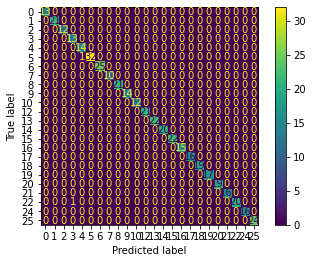

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), new_model.predict(X_train_vec).argmax(axis=1))
ac = accuracy_score(y_train_vec.argmax(axis=1), new_model.predict(X_train_vec).argmax(axis=1))
print(f"accuracy score : {ac}")

Matrice de confusion sur les predictions de données d'entrainement
accuracy score : 0.1


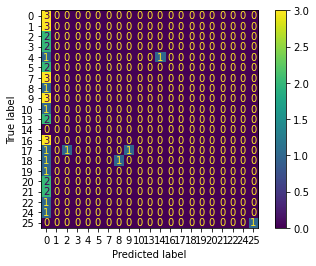

In [19]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), new_model.predict(X_test_vec).argmax(axis=1))
ac = accuracy_score(y_test_vec.argmax(axis=1), new_model.predict(X_test_vec).argmax(axis=1))
print(f"accuracy score : {ac}")

Matrice de confusion sur les PROBABILITES de predictions de données d'entrainement
accuracy score : 0.9954128440366973


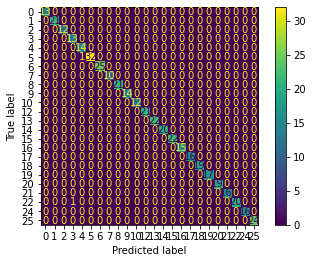

In [26]:
print("Matrice de confusion sur les PROBABILITES de predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), new_model.predict(X_train_vec).argmax(axis=1))
ac = accuracy_score(y_train_vec.argmax(axis=1), new_model.predict(X_train_vec).argmax(axis=1))
print(f"accuracy score : {ac}")

In [33]:
prediction = new_model.predict(X_train_vec).argmax(axis=1)
proba_prediction = new_model.predict_proba(X_train_vec)

print(f"prediction de format {prediction.shape} \n {prediction}\n\n")
print(min(prediction))
print(max(prediction))


print(len(proba_prediction[:][1]))
print(f"prediction de format {len(proba_prediction)} \n {proba_prediction}")

"""
c=0
for phrase_vector in X_train_vec:
    print(phrase_vector)
    print(prediction[c])
    
    if c>3:
        break
    c+=1    
#print(X_train_vec[0])
"""

prediction de format (436,) 
 [ 8  8  8 19 19 19 18 18 18 22 22 22 25  2  2  2  3  3  3 24 24 24 25 25
 13 13 13  6  6  6 24 24 24 13 13 13 17 17 17 22 22 22 17 17 17 17  1  1
  1  8  8  8 19 19 19 10 10 10  8  8  8 21 21 21 10 10 10 10 10 10  5  5
  5 12 12 12 20 20 20 19 19 19 18 18 18 12 12 12 15 15 15 12 12 12 22 22
 22  1  1  1  8  8  8 20 25 25 25  3  3  3 20 20 20  3 25 25 25 19 19 19
  3 22 22 20 20 20  4  4  4  7  3  3  3  9  9  9  5  5  5  0  6  6  6  6
 17 17 17 22 22 22 25 25 25  6  6  6 18 18 18  6  4  4  4  0  0  0 16 16
 16  5  5  5  7  7  7 14 14 14 18 18 18 24 24 24  2  2  2 13 13 13 21 21
 21 25 25 25  9  9  9 15 20 20 20 25 25 25  4  4  4  5  5  5  5  5  4  2
  2  2  0  0  0 18 18 18 15 15 15 18 18 18  1  1  1 16 16 16 20 20 20  6
  6  6  1  1  1 21 21 21 21  9  9  9 19 19 19 21 21 21  5  5  5  7  7  7
  6  6  6 24 24 24  7  7  7 21 21 21 14 14 14 14 14 14 16 16 16 19 14 14
 14 25 25 25 17 17 17  1  1  1  9  9  9 12 12 12  0  0  0  5  5  5 18 15
 15 15  5  5  5 16 16

'\nc=0\nfor phrase_vector in X_train_vec:\n    print(phrase_vector)\n    print(prediction[c])\n    \n    if c>3:\n        break\n    c+=1    \n#print(X_train_vec[0])\n'

In [41]:
#new_model.predict_proba(X_train_vec)
for phrase_vector in X_train_vec:
    print(f"La classification est {new_model.predict(phrase_vector)} .argmax(axis=1) avec une proba de new_model.predict_proba(X_train_vec)")

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## predict probabilités

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# Load the Iris dataset
iris_X, iris_y = datasets.load_iris(return_X_y=True)
# Split Iris dataset into train/test sets randomly
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-10]]
iris_y_train = iris_y[indices[:-10]]
iris_X_test = iris_X[indices[-10:]]
iris_y_test = iris_y[indices[-10:]]
# Instantiate and fit a KNeighbors classifier
knn = KNeighborsClassifier()
knn.fit(iris_X_train, iris_y_train)

KNeighborsClassifier()

In [4]:
predictions = knn.predict(iris_X_test)
print(len(iris_X_test))
print(predictions)

10
[1 2 1 0 0 0 2 1 2 0]


In [5]:
proba = knn.predict_proba(iris_X_test)
print(proba)

[[0.  1.  0. ]
 [0.  0.4 0.6]
 [0.  1.  0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [0.  0.  1. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [1.  0.  0. ]]


## Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
print(f"X_train_vec.shape : {X_train_vec.shape}")
print(f"y_train_vec.shape : {y_train_vec[:,0].shape}")
naive_bayes.fit(X_train_vec, y_train_vec[:,0])

X_train_vec.shape : (426, 336)
y_train_vec.shape : (426,)


GaussianNB()

In [63]:
# Predicting the Test set results
y_pred = naive_bayes.predict(X_test_vec)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
ac = accuracy_score(y_test_vec,y_pred)
cm = confusion_matrix(y_test_vec, y_pred)
ac

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec[:,0].argmax(axis=1), naive_bayes.predict(X_train_vec).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


AxisError: axis 1 is out of bounds for array of dimension 1

### code internet naive bayes

In [45]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, -1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [46]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
print(f"X_train.shape : {X_train.shape}")
print(f"y_train.shape : {y_train.shape}")
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


X_train.shape : (320, 2)
y_train.shape : (320,)


In [39]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
ac = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
ac

0.9125

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train, new_model.predict(X_train_vec).argmax(axis=1))

array([[55,  3],
       [ 4, 18]], dtype=int64)

Matrice de confusion sur les predictions de données d'entrainement


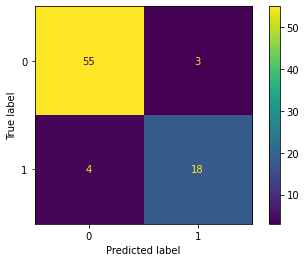

In [38]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## SGDClassifier
Linear SVM OU logistic regression  : https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

In [66]:
from sklearn.linear_model import SGDClassifier

In [106]:
#clf = SGDClassifier(loss="log", penalty="l2")
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train_vec, y_train_vec.argmax(axis=1))

SGDClassifier()

In [107]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_vec.argmax(axis=1), clf.predict(X_test_vec))))

print(f"y_test_vec: \n{y_test_vec.argmax(axis=1)} au format {y_test_vec.argmax(axis=1).shape}")
print(f"\nX_test_vec: \n{X_test_vec} au format {X_test_vec.shape}")
#clf.predict(X_train_vec)#.argmax(axis=1)


ac = accuracy_score(y_train_vec.argmax(axis=1), clf.predict(X_train_vec))
print(f"accuracy score : {ac}")

Accuracy: 0.00
y_test_vec: 
[ 5 18  1 25  0 17 13 20  1 24  2 21 16 17  3 14 10 22 15 10  3 16  6 19
  2 19 20  5  6 19  8  3 25  9 21 14 18  5  0 14] au format (40,)

X_test_vec: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] au format (40, 336)
accuracy score : 0.971830985915493


Matrice de confusion sur les predictions de données d'entrainement


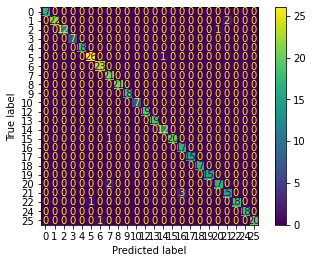

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), clf.predict(X_train_vec))
#ac = accuracy_score(y_train_vec.argmax(axis=1), clf.predict(X_train_vec).argmax(axis=1))
#print(f"accuracy score : {ac}")

Matrice de confusion sur les predictions de données d'entrainement


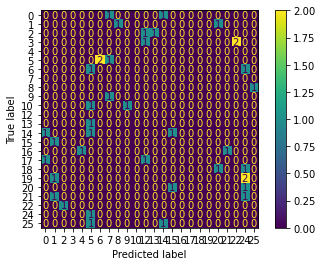

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), clf.predict(X_test_vec))
#ac = accuracy_score(y_train_vec.argmax(axis=1), clf.predict(X_train_vec).argmax(axis=1))
#print(f"accuracy score : {ac}")

In [110]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10)


grid.fit(X_train_vec, y_train_vec.argmax(axis=1))

print(f"best params : {grid.best_params_}") 
print(f"best score : {grid.best_score_}")

best params : {'alpha': 0.0001, 'loss': 'log', 'penalty': 'elasticnet'}
best score : 0.6845514950166113


Matrice de confusion sur les predictions de données d'entrainement


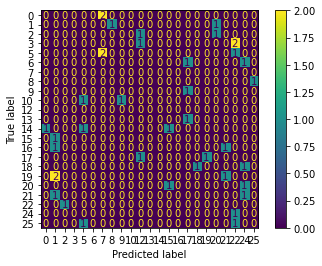

In [111]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), grid.predict(X_test_vec))

## Debuggage
**Voici le format des données après stemming, stop words et vectorisation**

In [9]:
cv = CountVectorizer()
#vect = cv.fit_transform

data = {'Pattern':X_text,"Pattern_fit_transform":cv.fit_transform(X_text), 'tag':y_text, "tag_fit_transform": cv.fit_transform(y_text)}  

df = pd.DataFrame(data)
df[:][0:10]
#on observe avant vectorisation que chaque mot est transformé (exemple : salut correspond à (0,184), tous correspond à (0,205))

,Pattern,Pattern_fit_transform,tag,tag_fit_transform
0,salut,"(0, 184)\t1",bienvenue,"(0, 0)\t1"
1,salut tous,"(0, 184)\t1\n (0, 205)\t1",bienvenue,"(0, 0)\t1"
2,tous,"(0, 205)\t1",bienvenue,"(0, 0)\t1"
3,bonjour,"(0, 27)\t1",bienvenue,"(0, 0)\t1"
4,coucou,"(0, 56)\t1",bienvenue,"(0, 0)\t1"
5,comment ca-v,"(0, 50)\t1\n (0, 32)\t1",bienvenue,"(0, 0)\t1"
6,recherch l'aid,"(0, 172)\t1\n (0, 7)\t1",bienvenue,"(0, 0)\t1"
7,oyez oyez,"(0, 140)\t2",bienvenue,"(0, 0)\t1"
8,hey,"(0, 99)\t1",bienvenue,"(0, 0)\t1"
9,pourquoi ’ isen,"(0, 156)\t1\n (0, 108)\t1",raison_isen,"(0, 13)\t1"


In [10]:
cv = CountVectorizer()
    
vect = cv.fit_transform(X_text)
vect = vect.toarray()
pd.DataFrame(vect)
#on observe qu'il y a 227 mots possibles (index 0 à 226) sur 201 patterns (index 0 à 200)

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


---

---

# Preprocessing

## Code

---

## Code Enrichissement de données sur les données d'entrainements - Data Augmentation

**PISTE D'AMELIORATION - ENRICHISSEMENT DE DONNEES SUR LES DONNEES D'ENTRAINEMENTS ET REGARDER VIDEO PROF ANALYSE SENTIMENTS**


In [9]:
import nlpaug

In [112]:
X_text[25:28]

["comment est-on formé à l'isen?",
 'quelles sont les différentes possibilités suivant mon profil?',
 "quelles sont les enseignements à l'isen?"]

In [18]:
X_text,y_text = extraction_data_X_y('intents.json')
#X_text

In [19]:
X_text_,y_text = extraction_data_X_y('intents.json')


In [177]:
stop_words=stopwords.words("French")
stop_words.append("'")
stop_words.append(".")
stop_words.append("?")


In [20]:
new_sentences = create_set_of_new_sentences("En combien d’années se déroule l’ISEN ?")
#print(new_sentences)

nbr
for sentence in new_sentences:
    print(sentence)
    
    print(clean_text(sentence))
    print("\n")

NameError: name 'nbr' is not defined

In [ ]:
En combien d’années se déroule l’ISEN ?

In [174]:
from deep_translator import LingueeTranslator
word = 'bon'
translated_word = LingueeTranslator(source='french', target='english').translate(word)#, return_all=True)
translated_word

RequestError: Request exception can happen due to an api connection error. Please check your connection and try again

In [133]:
to_translate = "j'aime vraiment beaucoup les pommes de terres"
translated = GoogleTranslator(source='fr', target='en').translate(to_translate)
translated = GoogleTranslator(source='en', target='fr').translate(to_translate)
translated

"j'aime vraiment beaucoup les pommes de terres"

In [132]:
https://neptune.ai/blog/data-augmentation-nlp --> à regarder : Shuffle Sentences Transform

SyntaxError: invalid syntax (Temp/ipykernel_75616/1203705234.py, line 1)

---

In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def preprocessing(X_text, y_text, X, y):
    
    try :
        X_text,y_text = extraction_data_X_y(jsonfile)
    
        X=vectorizer(X_text)
        y=vectorizer(y_text)
        

        label_encoder_y = LabelEncoder()
        y_num = label_encoder_y.fit_transform(y_text) #[0, 0, 0, 0, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1]
        y_text_unique = np.unique(y_text) #['bienvenue', 'campus_ouest', 'cursus_isen', 'raison_isen']
        y_num_unique = label_encoder_y.fit_transform(y_text_unique) #[0,1,2,3]

        y_num_unique=y_num_unique.reshape((y_num_unique.shape[0],1)) #reshape pour avoir le format (nombre,1)

        y_mapping = {}
        y_mapping = dict(enumerate(y_text_unique.flatten(),0)) #{0: 'bienvenue', 1: 'campus_ouest', 2: 'cursus_isen', 3: 'raison_isen'}

        #séparation train dataset et test dataset
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
        
        print(X_train.shape)
        print(y_train.shape)
        
        return X,y,X_train,X_test,y_train,y_test
    
    except:
        print("Le preprocessing a échoué, allez voir la fonction preprocessing")
        
X, y, X_train, X_test, y_train, y_test = preprocessing('intents.json') #'intents_upgrade.json'
#X_test, y_test, X_train_test, X_test_test, y_train_test, y_test_test = preprocessing('intents_upgrade.json') #'intents_upgrade.json'

TypeError: preprocessing() missing 3 required positional arguments: 'y_text', 'X', and 'y'

## Debuggage
**Données prêtes pour l'entrainement**

In [23]:
print(f"X contient {X.shape[0]} patterns contenant {X.shape[1]} mots") 
print(X.shape)
print("\nX\n",X)

X contient 201 patterns contenant 227 mots
(201, 227)

X
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


In [24]:
print(f"y contient le tag de {y.shape[0]} patterns soit {y.shape[1]} mots (ce sont les tag)") 
print(y.shape)
print("\ny\n",y)

y contient le tag de 201 patterns soit 26 mots (ce sont les tag)
(201, 26)

y
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


---
---

In [81]:
k=np.arange(0,1,0.1)
k

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Entrainement du modele

## Reglage du modele

In [70]:
print(f"Voici la liste de tous les paramètres reglables du random forest : \n\n{RandomForestClassifier().get_params().keys()} \n\nPour plus d'infos, allez voir ces sites :") 

print("https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319")
print("https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn")
print("https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot")

Voici la liste de tous les paramètres reglables du random forest : 

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start']) 

Pour plus d'infos, allez voir ces sites :
https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot


**Score en fonction d'un paramètre (affichage graphique)**

## TEST avec données iris pour voir si classification bonne

In [111]:
data = pd.read_csv('iris.csv')
train_iris, test_iris = train_test_split(data, test_size = 0.4, stratify = data['species'], random_state = 42)


In [121]:
X_train_iris = train_iris[['sepal_length','sepal_width','petal_length','petal_width']]
y_train_iris = train_iris.species
X_test_iris = test_iris[['sepal_length','sepal_width','petal_length','petal_width']]
y_test_iris = test_iris.species

In [115]:
start = time.time()

param_grid= {'n_estimators':np.arange(1,30),
            'max_leaf_nodes':np.arange(1,20)}

grid_iris = GridSearchCV(RandomForestClassifier(random_state=123, oob_score=True),param_grid, cv=3) 
grid_iris.fit(X_train_iris,y_train_iris)

end = time.time()
print(end - start)

#permet de bloquer les NOMBREUX warnings avec oob_score
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

95.79060363769531


In [116]:
grid_iris.best_score_

0.9555555555555556

In [117]:
grid_iris.best_params_

{'max_leaf_nodes': 3, 'n_estimators': 3}

In [124]:
model_iris=RandomForestClassifier(random_state=123, oob_score=True,
                       max_leaf_nodes=3, n_estimators=3)
model_iris.fit(X_train_iris,y_train_iris)

RandomForestClassifier(max_leaf_nodes=3, n_estimators=3, oob_score=True,
                       random_state=123)

In [131]:
# grid_iris.oob_score_ --> ne fonctionne pas quand on l'utilise sur le resultat de gridsearchCV
model_iris.oob_score_

0.6888888888888889

Matrice de confusion sur les predictions de données d'entrainement


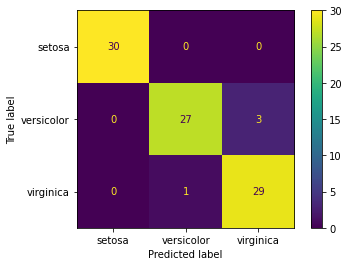

In [128]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_iris, model_iris.predict(X_train_iris))

Matrice de confusion sur les predictions de données d'entrainement


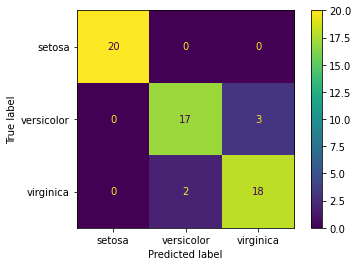

In [129]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_iris, model_iris.predict(X_test_iris))

## Evaluation du modele

grid est ici le "meilleur" modèle qui sort du gridsearchCV

In [77]:
grid.best_score_
#0.17923186344238975

0.1001630561378989

In [86]:
print(f"les meilleurs résultats sont quand on fait varier 3 paramètres : 'max_features': 33, 'max_leaf_nodes': 19, 'n_estimators': 39")
grid.best_params_

les meilleurs résultats sont quand on fait varier 3 paramètres : 'max_features': 33, 'max_leaf_nodes': 19, 'n_estimators': 39


{'max_leaf_nodes': 14, 'n_estimators': 2}

In [90]:
# new_model = grid.best_estimator_ à remettre quand on aura un meilleur gridsearchCV

new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', max_features = 35, n_estimators = 23) #ce sont les meilleurs paramètres
new_model.fit(X_train,y_train)
new_model.oob_score_ #permet de savoir si notre random forest a correctement généraliser (donc pas en overfitting). il faut viser 1.0

0.14375

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1), new_model.predict(X_train).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


AttributeError: 'list' object has no attribute 'argmax'

In [54]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), new_model.predict(X_test).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


AttributeError: 'list' object has no attribute 'argmax'

# Zone de test 

---

In [104]:
new_model_test= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', n_estimators = 23) #, max_features = 35,max_depth = 34, max_leaf_nodes =19) #, max_depth = 35,max_leaf_nodes=35
new_model_test.fit(X_train,y_train)
new_model_test.oob_score_ #permet de savoir si notre random forest a correctement généraliser (donc pas en overfitting). il faut viser 1.0

0.10062893081761007

In [105]:
new_model_test= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', n_estimators = 23) #, max_features = 35,max_depth = 34, max_leaf_nodes =19) #, max_depth = 35,max_leaf_nodes=35
new_model_test.fit(X_train_test,y_train_test)
new_model_test.oob_score_ #permet de savoir si notre random forest a correctement généraliser (donc pas en overfitting). il faut viser 1.0

0.16964285714285715

---

In [20]:
print("new_model.score(X_train, y_train) =",new_model.score(X_train, y_train))
print("new_model.score(X_test, y_test) =",new_model.score(X_test, y_test))

new_model.score(X_train, y_train) = 0.8303571428571429
new_model.score(X_test, y_test) = 0.2857142857142857


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), new_model.predict(X_test).argmax(axis=1))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot

SyntaxError: invalid syntax (Temp/ipykernel_51032/1082711333.py, line 1)

In [ ]:
https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot

------------------

In [ ]:
X=vectorizer(X_text)
y=vectorizer(y_text)

In [ ]:
y

In [ ]:
X


In [ ]:
#train set et test set

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder_y = LabelEncoder()

In [ ]:
y_num = label_encoder_y.fit_transform(y_text) #pour avoir la liste complète pour l'entrainement
y_num

In [ ]:
y_text

In [ ]:
y_text_unique = np.unique(y_text)
y_text_unique

In [ ]:
y_num_unique = label_encoder_y.fit_transform(y_text_unique)
y_num_unique


In [ ]:
print(y_num_unique.shape)
y_num_unique=y_num_unique.reshape((y_num_unique.shape[0],1))
print(y_num_unique.shape)


In [ ]:
STOP

In [ ]:
y_text_unique

In [ ]:
y_mapping = {}

y_mapping = dict(enumerate(y_text_unique.flatten(),0))


#y_text=np.array(y_text)

print(y_mapping)


In [ ]:
print ("X :", X.shape)
print ("y :", X.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
print ("Train set :", X_train.shape)
print ("Test set :", X_test.shape)


In [ ]:
model = RandomForestClassifier(n_estimators=15)

In [ ]:
for i in range (5,20):
    model = RandomForestClassifier(n_estimators=i)
    model.fit(X_train,y_train)
    print("\n i=",i)
    print("Train.score:",model.score(X_train, y_train))
    print("Test.score:",model.score(X_test, y_test))

In [ ]:
print("Train.score:",model.score(X_train, y_train))

In [ ]:
print("Train.score:",model.score(X_test, y_test))

In [ ]:
def test_tag(tag_test,jsonfile): #fonction qui permet de voir l'efficacité du random forest pour un tag donné (exemple : test_tag("raison_isen"))
    nb_reussi=0
    nb_total=0
    
    
    
    X, y, X_train, X_test, y_train, y_test = preprocessing(jsonfile)
    model_entraine = train_model(X_train,y_train)
    
    for doc in intents['intents']:
        if doc['tag'] == tag_test:

            print(f"Liste des patterns pour ce tag {tag_test}: \n")
            for pattern in doc['patterns']:
                print(pattern)
                test_data = pattern #on ne test ici que les phrases venant des patterns du corpus (donc d'entrainement)
                
                # [stemmer.stem(i) for i in nltk.word_tokenize((p.lower()))]
                test_data = " ".join([stemmer.stem(i) for i in nltk.word_tokenize((test_data.lower()))])
                X_cv_test = cv.transform([test_data]).toarray()
                
                
                model_entraine = train_model(X_train,y_train)
                
                #test
                #random_forest = RandomForestClassifier(n_estimators=15)
                #random_forest.fit(X_cv_test, test_data) #entrainement
                result = random_forest.predict(X_cv_test) #prediction
                #result=1 #--> problème, si on force le result sur une valeur, cela ne change rien du resultat final
                predicted_tag = y_mapping[int(result)] 
                #fin test
                
                #print(f"result:{result}\n")
                
                
                if predicted_tag==tag_test:
                    nb_reussi+=1
                nb_total+=1

            print(f"-----------------------------------------------\nListe des reponses pour ce tag {tag_test}:  \n")
            for reponse in doc['responses']:
                print(reponse)
    
    if nb_total==0:
        print(f"Le tag {tag_test} n'est pas dans notre corpus intents")
        return False
    
    print(f"-----------------------------------------------\nSur ces pattern de ce tag {tag_test}, {nb_reussi} ont été associé au bon tag sur {nb_total} après entrainement") 
    return (nb_reussi,nb_total)

preprocessing('intents.json')